In [ ]:
#Missing KIMORE:
#MobileNetV3Small-ViT
top6Kimore={ "Res101-Dense201-ViT",
    "DenseNet201-MobileNetV3Small-ViT",
    "Base ViT",
    "Res50-MobileV3Small-ViT",
    "MobileNetV3Small-ViT",
    "VGG16"
          }
kimoreImp={'DenseNet201-MobileNetV3Small-ViT',
           'Res50-MobileV3Small-ViT',
           'MobV3Large',#not in top 6
           'VGG16',
           'Dense201',#not in top 6
           'ResnNet101',#not in top 6
           'Base ViT',
           'Res101-Dense201-ViT'
           }
#Missing UIPRMD
#Res101-Dense201-ViT
#MobileNetV3Large-ViT
top6ui={
    'DenseNet201-MobileNetV3Small-ViT',
    'Res50-MobileV3Small-ViT',
    'ResNet101-ViT',
    'DenseNet201-ViT',
    'Res101-Dense201-ViT',#not found
    'MobileNetV3Large-ViT'#not found
}
uiImp={
    'DenseNet201-ViT',
    'ResNet101-ViT',
    'DenseNet201-MobileNetV3Small-ViT',
    'ResNet50-ViT',#not in top 6
    'Res50-MobileV3Small-ViT',
    'MobileNetV3Small-ViT',#not in top 6
}

In [ ]:
kimore = {
    'DenseNet201-MobileNetV3Small-ViT',
    'Base ViT',
    'Res50-MobileV3Small-ViT',
    'ResNet101-ViT',
    'DenseNet201-ViT',
    'VGG16-ViT',
    'MobileNetV3Large-ViT'
}

print(kimore)

{'MobileNetV3Large-ViT', 'Base ViT', 'VGG16-ViT', 'DenseNet201-MobileNetV3Small-ViT', 'DenseNet201-ViT', 'ResNet101-ViT', 'Res50-MobileV3Small-ViT'}


In [ ]:
uiprmd = {
    "DenseNet201-MobileNetV3Small-ViT",
    "ResNet101-ViT",
    "DenseNet201-ViT",
    "Res50-MobileV3Small-ViT",
    "ResNet50-ViT",
    "MobileV3Small-ViT"
}
print(uiprmd)


{'DenseNet201-MobileNetV3Small-ViT', 'DenseNet201-ViT', 'ResNet101-ViT', 'ResNet50-ViT', 'MobileV3Small-ViT', 'Res50-MobileV3Small-ViT'}


In [ ]:
# Intersection of the two sets
intersection = uiprmd.intersection(kimore)
print("Intersection:", intersection)

# Difference between the two sets
difference = uiprmd.difference(kimore)
print("Difference (uiprmd - kimore):", difference)

Intersection: {'DenseNet201-MobileNetV3Small-ViT', 'Res50-MobileV3Small-ViT', 'DenseNet201-ViT', 'ResNet101-ViT'}
Difference (uiprmd - kimore): {'ResNet50-ViT', 'MobileV3Small-ViT'}


In [ ]:
import tensorflow as tf

from keras.src.applications import imagenet_utils
# For versions <TF2.13 change the above import to:
# from keras.applications import imagenet_utils

from tensorflow.keras import layers
from tensorflow import keras

import tensorflow_datasets as tfds
import tensorflow_addons as tfa

tfds.disable_progress_bar()

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Values are from table 4.
patch_size = 4  # 2x2, for the Transformer blocks.
expansion_factor = 2  # expansion factor for the MobileNetV2 blocks.
batch_size = 64
num_classes = 20  # Replace with the actual number of classes in your dataset
epochs=150
width=224
height=224
patience=25
img_size=(width, height, 3)
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/MobileTransformer/'
csv_file_path=save_folder+"results.csv"

In [ ]:
def conv_block(x, filters=16, kernel_size=3, strides=2):
    conv_layer = layers.Conv2D(
        filters, kernel_size, strides=strides, activation=tf.nn.swish, padding="same"
    )
    return conv_layer(x)

In [ ]:
def inverted_residual_block(x, expanded_channels, output_channels, strides=1):
    m = layers.Conv2D(expanded_channels, 1, padding="same", use_bias=False)(x)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    if strides == 2:
        m = layers.ZeroPadding2D(padding=imagenet_utils.correct_pad(m, 3))(m)
    m = layers.DepthwiseConv2D(
        3, strides=strides, padding="same" if strides == 1 else "valid", use_bias=False
    )(m)
    m = layers.BatchNormalization()(m)
    m = tf.nn.swish(m)

    m = layers.Conv2D(output_channels, 1, padding="same", use_bias=False)(m)
    m = layers.BatchNormalization()(m)

    if tf.math.equal(x.shape[-1], output_channels) and strides == 1:
        return layers.Add()([m, x])
    return m

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.swish)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
def transformer_block(x, transformer_layers, projection_dim, num_heads=2):
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(x)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=[x.shape[-1] * 2, x.shape[-1]], dropout_rate=0.1,)
        # Skip connection 2.
        x = layers.Add()([x3, x2])

    return x


In [ ]:

def mobilevit_block(x, num_blocks, projection_dim, strides=1):
    # Local projection with convolutions.
    local_features = conv_block(x, filters=projection_dim, strides=strides)
    local_features = conv_block(
        local_features, filters=projection_dim, kernel_size=1, strides=strides
    )

    # Unfold into patches and then pass through Transformers.
    num_patches = int((local_features.shape[1] * local_features.shape[2]) / patch_size)
    non_overlapping_patches = layers.Reshape((patch_size, num_patches, projection_dim))(
        local_features
    )
    global_features = transformer_block(
        non_overlapping_patches, num_blocks, projection_dim
    )

    # Fold into conv-like feature-maps.
    folded_feature_map = layers.Reshape((*local_features.shape[1:-1], projection_dim))(
        global_features
    )

    # Apply point-wise conv -> concatenate with the input features.
    folded_feature_map = conv_block(
        folded_feature_map, filters=x.shape[-1], kernel_size=1, strides=strides
    )
    local_global_features = layers.Concatenate(axis=-1)([x, folded_feature_map])

    # Fuse the local and global features using a convoluion layer.
    local_global_features = conv_block(
        local_global_features, filters=projection_dim, strides=strides
    )

    return local_global_features

In [ ]:
def create_mobilevit(num_classes=5):
    inputs = keras.Input(img_size)
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Initial conv-stem -> MV2 block.
    x = conv_block(x, filters=16)
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=16
    )

    # Downsampling with MV2 block.
    x = inverted_residual_block(
        x, expanded_channels=16 * expansion_factor, output_channels=24, strides=2
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=24
    )

    # First MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=24 * expansion_factor, output_channels=48, strides=2
    )
    x = mobilevit_block(x, num_blocks=2, projection_dim=64)

    # Second MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=64 * expansion_factor, output_channels=64, strides=2
    )
    x = mobilevit_block(x, num_blocks=4, projection_dim=80)

    # Third MV2 -> MobileViT block.
    x = inverted_residual_block(
        x, expanded_channels=80 * expansion_factor, output_channels=80, strides=2
    )
    x = mobilevit_block(x, num_blocks=3, projection_dim=96)
    x = conv_block(x, filters=320, kernel_size=1, strides=1)

    # Classification head.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


# mobilevit_xxs = create_mobilevit()
# mobilevit_xxs.summary()

In [ ]:
pip install tensorflow

In [ ]:
!unzip -q /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Extracted_IMGs.zip -d /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images_extracted/


unzip:  cannot find or open /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Extracted_IMGs.zip, /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Extracted_IMGs.zip.zip or /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Extracted_IMGs.zip.ZIP.


#Paramters

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
batch_size = 64
num_classes = 5  # Replace with the actual number of classes in your dataset
epochs=150
width=224
height=224
patience=30
img_size=(width, height, 3)
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore'
csv_file_path=save_folder+"results.csv"
# create_empty_csv_file(save_folder+"results.csv")

In [ ]:
pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.1 MB/s eta 0:00:00


In [ ]:

!pip install --quiet vit-keras


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications import NASNetLarge, NASNetMobile
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import time

#Functions

In [ ]:

import tensorflow as tf
from tensorflow.keras.utils import plot_model

def visualize_model_architecture(model,filename=save_folder+'model_architecture.png'):
    """
    Visualizes the architecture of a Keras model and saves the visualization to a file.

    Args:
        model (tf.keras.Model): The Keras model to visualize.
        filename (str): The filename to save the visualization. Default is 'model_architecture.png'.
    """
    print(filename)
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
    del model


In [ ]:

import cv2
import numpy as np

def resize_images_cv2(image_array):
    """
    Resize each image in the input numpy array to 224x224 pixels using cv2.

    Parameters:
    - image_array (numpy.ndarray): Input array of images.

    Returns:
    - resized_images (numpy.ndarray): Array of resized images.
    """
    resized_images = []

    for image in image_array:
        # Resize the image to 224x224 pixels using cv2
        resized_image = cv2.resize(image, (width, height))

        resized_images.append(resized_image)

    return np.array(resized_images)

# Example usage:
# Assuming you have a numpy array named 'original_images' containing your images
# resized_images = resize_images_cv2(original_images)

In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np


def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in tqdm(os.listdir(folder_path), desc="Loading Images"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        # Assuming the label is the prefix before the first underscore
        label = filename.split('_')[0]
        if(filename.endswith("png")):

          # Check if label ends with "_inc" and modify accordingly
          if filename.endswith('_inc.png'):
              # label = filename[:-4]  # Remove "_inc"
              label += "_inc"

          images.append(img)
          labels.append(label)
    images = np.array(images)

    return images, labels

In [ ]:


import cv2
import os
from tqdm import tqdm
import numpy as np

def load_images_and_labels_f(folder_path):
    images = []
    labels = []

    for filename in tqdm(os.listdir(folder_path), desc="Loading Images"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        # Assuming the label is the prefix before the first underscore
        label = filename.split('_')[0]
        if(filename.endswith("png")):
          images.append(img)
          labels.append(label)
    images = np.array(images)

    return images, labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    encoded_labels= to_categorical(encoded_labels)
    return encoded_labels


In [ ]:
from sklearn.model_selection import train_test_split

def split_data(images, labels, test_size=0.2, validation_size=0.1, random_state=42):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_state,stratify=labels)

    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state,stratify=y_train)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
import pandas as pd

def append_to_csv(file_path, model_name, accuracy, precision, recall, f1_score, testing_time, training_time):
    """
    Append a row with evaluation metrics to an existing CSV file.

    Parameters:
    - file_path: The path to the CSV file.
    - model_name: Name of the model.
    - accuracy: Accuracy value.
    - precision: Precision value.
    - recall: Recall value.
    - f1_score: F1 score value.
    - testing_time: Time taken for testing in seconds.
    - training_time: Time taken for training in seconds.
    """

    headers = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Testing Time', 'Training Time']

    # Check if the file exists
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        # If the file doesn't exist, create a new one with headers
        df = pd.DataFrame(columns=headers)

    # Append a new row with the specified values
    new_row = pd.DataFrame([[model_name, accuracy, precision, recall, f1_score, testing_time, training_time]], columns=headers)
    df = pd.concat([df, new_row], ignore_index=True)

    # Save to the same CSV file
    df.to_csv(file_path, index=False)

    print(f"Row appended to '{file_path}' successfully.")

# Example usage:
# csv_file_path = "evaluation_metrics.csv"
# append_to_csv(csv_file_path, "ExampleModel", 0.85, 0.88, 0.82, 0.85, 30, 120)


##Create Model

### Transfer ViT

In [ ]:


# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
# from vit_keras import vit

# def createTransferViT(imagesize,num_classes,pretrained_model):
#   # Vision Transformer model
#   vit_model = vit.vit_b32(
#         image_size=width,
#         pretrained=True,
#         activation='softmax',
#         include_top=False,
#         pretrained_top=False,
#         classes=num_classes
#   )
#   match pretrained_model:
#     case "DenseNet121":
#         base_model = tf.keras.applications.DenseNet121(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "DenseNet169":
#       base_model = tf.keras.applications.DenseNet169(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "DenseNet201":
#       base_model = tf.keras.applications.DenseNet201(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "InceptionV3":
#        base_model = tf.keras.applications.InceptionV3(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "InceptionResNetV2":
#        base_model = tf.keras.applications.InceptionResNetV2(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "MobileNet":
#        base_model = tf.keras.applications.MobileNet(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "MobileNetV2":
#        base_model = tf.keras.applications.MobileNetV2(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "MobileNetV3Small":
#       base_model = tf.keras.applications.MobileNetV3Small(
#                 include_top=False,
#                 weights='imagenet',
#                 input_shape=imagesize,
#             )
#     case "MobileNetV3Large":
#       base_model = tf.keras.applications.MobileNetV3Large(
#                 include_top=False,
#                 weights='imagenet',
#                 input_shape=imagesize,
#             )
#     case "NASNetLarge":
#        base_model = tf.keras.applications.NASNetLarge(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "NASNetMobile":
#        base_model = tf.keras.applications.NASNetMobile(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "ResNet50":
#       base_model = tf.keras.applications.ResNet50(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "ResNet101":
#        base_model = tf.keras.applications.ResNet101(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "ResNet152":
#        base_model = tf.keras.applications.ResNet152(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "ResNet50V2":
#        base_model = tf.keras.applications.ResNet50V2(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "ResNet101V2":
#        base_model = tf.keras.applications.ResNet101V2(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "ResNet152V2":
#        base_model = tf.keras.applications.ResNet152V2(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "VGG16":
#        base_model = tf.keras.applications.VGG16(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "VGG19":
#        base_model = tf.keras.applications.VGG19(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case "Xception":
#        base_model = tf.keras.applications.Xception(
#       include_top=False,
#       weights='imagenet',
#       input_shape=imagesize,#(224, 224, 3),
#       )
#     case _ :
#       exit()


#   for layer in base_model.layers:
#     layer.trainable = False

#   # Combined model
#   inputs = tf.keras.layers.Input(shape=imagesize)
#   vit_output = vit_model(inputs)
#   base_model_output = base_model(inputs)

#     # Flatten and concatenate ViT and ResNet101 outputs
#   vit_output = layers.Flatten()(vit_output)
#   base_model_output = layers.GlobalAveragePooling2D()(base_model_output)
#   combined_output = layers.concatenate([vit_output, base_model_output])

#     # Dense layers
#   dense_units= 352
#   dropout_rate= 0.2
#   dense_layers= 2
#   dense_regularizer_type= None
#   dense_regularizer_strength= 0.004814608694184414
#     # Dense layers
#   for i in range(dense_layers):
#     current_dense_units = int(dense_units / (2 ** i))
#     dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

#         # Apply BatchNormalization only to the first dense layer
#     if i == 0:
#       x = dense_layer(combined_output)
#       x = BatchNormalization()(x)
#       x = Dropout(dropout_rate)(x)
#     else:
#       x = dense_layer(x)
#       x = Dropout(dropout_rate)(x)
#   # Combined Model
#   inputs = tf.keras.layers.Input(shape=imagesize)
#   vit_output = vit_model(inputs)
#   transfer_output = base_model(inputs)
#   # Flatten and concatenate ViT and ResNet101 outputs
#   vit_output = layers.Flatten()(vit_output)
#   transfer_output = layers.GlobalAveragePooling2D()(transfer_output)
#   combined_output = layers.concatenate([vit_output, transfer_output])


#   dense_units= 352
#   dropout_rate= 0.2
#   dense_layers= 2
#   dense_regularizer_type= None
#   dense_regularizer_strength= 0.004814608694184414

#   # Dense layers
#   for i in range(dense_layers):
#     current_dense_units = int(dense_units / (2 ** i))
#     dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

#         # Apply BatchNormalization only to the first dense layer
#     if i == 0:
#       x = BatchNormalization()(combined_output)
#       x = dense_layer(x)
#       x = Dropout(dropout_rate)(x)
#     else:
#       x = dense_layer(x)
#       x = Dropout(dropout_rate)(x)
#   output_layer = layers.Dense(num_classes, activation='softmax')(x)

#   model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')


#   model.compile(
#       optimizer=Adam(learning_rate=0.001),
#       loss='categorical_crossentropy',
#       metrics=['accuracy']
#   )
#   return model
# #createModel(imagesize,num_classes,pretrained_model)
# #createDenseNet121((224, 224, 3),num_classes)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from vit_keras import vit

def createTransferViT(imagesize,num_classes,pretrained_model):
  # Vision Transformer model
  vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
  )
  match pretrained_model:
    case "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet169":
      base_model = tf.keras.applications.DenseNet169(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet201":
      base_model = tf.keras.applications.DenseNet201(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionV3":
       base_model = tf.keras.applications.InceptionV3(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionResNetV2":
       base_model = tf.keras.applications.InceptionResNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNet":
       base_model = tf.keras.applications.MobileNet(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNetV2":
       base_model = tf.keras.applications.MobileNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNetV3Small":
      base_model = tf.keras.applications.MobileNetV3Small(
                include_top=False,
                weights='imagenet',
                input_shape=imagesize,
            )
    case "MobileNetV3Large":
      base_model = tf.keras.applications.MobileNetV3Large(
                include_top=False,
                weights='imagenet',
                input_shape=imagesize,
            )
    case "NASNetLarge":
       base_model = tf.keras.applications.NASNetLarge(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "NASNetMobile":
       base_model = tf.keras.applications.NASNetMobile(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50":
      base_model = tf.keras.applications.ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet101":
       base_model = tf.keras.applications.ResNet101(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet121":
       base_model = tf.keras.applications.ResNet121(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152":
       base_model = tf.keras.applications.ResNet152(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50V2":
       base_model = tf.keras.applications.ResNet50V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet101V2":
       base_model = tf.keras.applications.ResNet101V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152V2":
       base_model = tf.keras.applications.ResNet152V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG16":
       base_model = tf.keras.applications.VGG16(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG19":
       base_model = tf.keras.applications.VGG19(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "Xception":
       base_model = tf.keras.applications.Xception(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case _ :
      exit()


  for layer in base_model.layers:
    layer.trainable = False

  # Combined Model
  inputs = tf.keras.layers.Input(shape=imagesize)
  vit_output = vit_model(inputs)
  transfer_output = base_model(inputs)
  # Flatten and concatenate ViT and ResNet101 outputs
  vit_output = layers.Flatten()(vit_output)
  transfer_output = layers.GlobalAveragePooling2D()(transfer_output)
  combined_output = layers.concatenate([vit_output, transfer_output])


  dense_units= 352
  dropout_rate= 0.2
  dense_layers= 2
  dense_regularizer_type= None
  dense_regularizer_strength= 0.004814608694184414

  # Dense layers
  for i in range(dense_layers):
    current_dense_units = int(dense_units / (2 ** i))
    dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
    if i == 0:
      x = BatchNormalization()(combined_output)
      x = dense_layer(x)
      x = Dropout(dropout_rate)(x)
    else:
      x = dense_layer(x)
      x = Dropout(dropout_rate)(x)
  output_layer = layers.Dense(num_classes, activation='softmax')(x)

  model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')


  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model
#createModel(imagesize,num_classes,pretrained_model)
#createDenseNet121((224, 224, 3),num_classes)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# mv = createTransferViT(img_size,num_classes,"MobileNetV3Small")


In [ ]:
# visualize_model_architecture(mv,"/content/mobilevit.png")

### batch Before Dense

In [ ]:
# model=createTransferViTBatch(img_size,num_classes,"MobileNetV3Small")
# visualize_model_architecture(model,filename='MobileNetV3Small.png')



### ViT

In [ ]:
import tensorflow as tf

def createModelBaseViT(imagesize,num_classes):
  dense_units= 352
  dropout_rate= 0.2
  dense_layers= 2
  dense_regularizer_type= None
  dense_regularizer_strength= 0.004814608694184414
  vit_model = vit.vit_b32(
      image_size = width,
      pretrained = True,
      activation = 'softmax',
      include_top = False,
      pretrained_top = False,
      classes = num_classes)

  model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=img_size),
        vit_model,
      layers.Flatten(),
      ],name = 'vision_transformer')

  for i in range(dense_layers):
    current_dense_units = int(dense_units / (2 ** i))
    if dense_regularizer_type == 'l2':
      regularizer = tf.keras.regularizers.l2(dense_regularizer_strength)
    elif dense_regularizer_type == 'l1':
      regularizer = tf.keras.regularizers.l1(dense_regularizer_strength)
    else:
      regularizer = None
    dense_layer = layers.Dense(current_dense_units, activation='relu', kernel_regularizer=regularizer)
    # Apply BatchNormalization only to the first dense layer
    if i == 0:
      model.add(layers.BatchNormalization())
    model.add(dense_layer)
    model.add(layers.Dropout(dropout_rate))

  model.add(layers.Dense(num_classes, activation='softmax'))




  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model
#createModel(imagesize,num_classes,pretrained_model)
#createDenseNet121((224, 224, 3),num_classes)

### CNN VIT

In [ ]:
from vit_keras import vit
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout


def createModelCNNViT(imagesize,num_classes):
    # Input layer
    input_layer = Input(shape=imagesize)

    # CNN for feature extraction
    x = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Vision Transformer
    vit_model = vit.vit_b32(
        image_size=img_size[0],  # Assuming square images
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Connect CNN and ViT outputs
    cnn_output = x
    vit_output = vit_model(input_layer)

    # Flatten the ViT output if needed
    vit_output = Flatten()(vit_output)

    # Concatenate or add the outputs
    combined_output = tf.keras.layers.concatenate([cnn_output, vit_output])

    dense_units = 352
    dropout_rate = 0.2
    dense_layers = 2
    dense_regularizer_type = None
    dense_regularizer_strength = 0.004814608694184414

    # Dense layers
    for i in range(dense_layers):
        current_dense_units = int(dense_units / (2 ** i))
        dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
        if i == 0:
            x = BatchNormalization()(combined_output)
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
        else:
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='hybrid_model')

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
#createModel(imagesize,num_classes)

In [ ]:
# cv = createModelCNNViT(img_size,num_classes)

In [ ]:
# visualize_model_architecture(cv,"/content/cnnVit.png")

### Hybrid

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, MobileNetV3Small
from vit_keras import vit

def createCombinedModel(imagesize, num_classes):
    # ResNet50 model
    resnet_model = ResNet50(input_shape=imagesize, include_top=False, weights='imagenet')
    resnet_model.trainable = False

    # MobileNetV3Small model
    mobilenet_model = MobileNetV3Small(input_shape=imagesize, include_top=False, weights='imagenet')
    mobilenet_model.trainable = False

    # ViT model
    vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Inputs
    inputs = tf.keras.layers.Input(shape=imagesize)

    # ResNet50 output
    resnet_output = resnet_model(inputs)
    resnet_output = layers.GlobalMaxPool2D()(resnet_output)
    resnet_output = layers.Flatten()(resnet_output)

    # MobileNetV3Small output
    mobilenet_output = mobilenet_model(inputs)
    mobilenet_output = layers.GlobalMaxPool2D()(mobilenet_output)
    mobilenet_output = layers.Flatten()(mobilenet_output)

    # ViT output
    vit_output = vit_model(inputs)
    vit_output = layers.Flatten()(vit_output)

    # Concatenate outputs
    combined_output = layers.concatenate([resnet_output, mobilenet_output, vit_output])

    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    # Dense layers
    for i in range(dense_layers):
        current_dense_units = int(dense_units / (2 ** i))
        dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
        if i == 0:
            x = BatchNormalization()(combined_output)
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
        else:
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    # Model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet201, MobileNetV3Small,ResNet101
from vit_keras import vit

def createCombinedModel2(imagesize, num_classes):
    # DenseNet201 model
    dense_model = DenseNet201(input_shape=imagesize, include_top=False, weights='imagenet')
    dense_model.trainable = False

    # ResNet101 model
    res_model = ResNet101(input_shape=imagesize, include_top=False, weights='imagenet')
    res_model.trainable = False

    # ViT model
    vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Inputs
    inputs = tf.keras.layers.Input(shape=imagesize)

    # DenseNet201 output
    dense_output = dense_model(inputs)
    dense_output = layers.GlobalMaxPool2D()(dense_output)
    dense_output = layers.Flatten()(dense_output)

    # ResNet101 output
    resenet_output = res_model(inputs)
    resenet_output = layers.GlobalMaxPool2D()(resenet_output)
    resenet_output = layers.Flatten()(resenet_output)

    # ViT output
    vit_output = vit_model(inputs)
    vit_output = layers.Flatten()(vit_output)

    # Concatenate outputs
    combined_output = layers.concatenate([dense_output, resenet_output, vit_output])

    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    # Dense layers
    for i in range(dense_layers):
        current_dense_units = int(dense_units / (2 ** i))
        dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
        if i == 0:
            x = BatchNormalization()(combined_output)
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
        else:
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    # Model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, MobileNetV3Small
from vit_keras import vit

def createCombinedModel3(imagesize, num_classes):
    # DenseNet201 model
    dense_model = DenseNet201(input_shape=imagesize, include_top=False, weights='imagenet')
    dense_model.trainable = False

    # MobileNetV3Small model
    mobilenet_model = MobileNetV3Small(input_shape=imagesize, include_top=False, weights='imagenet')
    mobilenet_model.trainable = False

    # ViT model
    vit_model = vit.vit_b32(
        image_size=width,
        pretrained=True,
        activation='softmax',
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Inputs
    inputs = tf.keras.layers.Input(shape=imagesize)

    # ResNet50 output
    dense_output = dense_model(inputs)
    dense_output = layers.GlobalMaxPool2D()(dense_output)
    dense_output = layers.Flatten()(dense_output)

    # MobileNetV3Small output
    mobilenet_output = mobilenet_model(inputs)
    mobilenet_output = layers.GlobalMaxPool2D()(mobilenet_output)
    mobilenet_output = layers.Flatten()(mobilenet_output)

    # ViT output
    vit_output = vit_model(inputs)
    vit_output = layers.Flatten()(vit_output)

    # Concatenate outputs
    combined_output = layers.concatenate([dense_output, mobilenet_output, vit_output])

    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    dense_units= 352
    dropout_rate= 0.2
    dense_layers= 2
    dense_regularizer_type= None
    dense_regularizer_strength= 0.004814608694184414
    # Dense layers
    # Dense layers
    for i in range(dense_layers):
        current_dense_units = int(dense_units / (2 ** i))
        dense_layer = Dense(current_dense_units, activation='relu', kernel_regularizer=None)

        # Apply BatchNormalization only to the first dense layer
        if i == 0:
            x = BatchNormalization()(combined_output)
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
        else:
            x = dense_layer(x)
            x = Dropout(dropout_rate)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    # Model
    model = tf.keras.Model(inputs=inputs, outputs=output_layer, name='combined_model')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# cmv = createCombinedModel(img_size,num_classes)
# visualize_model_architecture(cmv,"/content/3hybridDenseMobileViT.png")

In [ ]:
# cmv.summary()

In [ ]:
import math

def trainModel(mdl,X_train,y_train,X_val,y_val,cllbk,save_dir):
  steps_per_epoch = math.ceil(len(X_train) / batch_size)
  validation_steps = math.ceil(len(X_val) / batch_size)
  # X_train, X_val, X_test, y_train, y_val, y_test = split_data(Oimages, labels, test_size=0.2, validation_size=0.1, random_state=42)

  # Train the model
  history= mdl.fit(
      X_train,
      y_train,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_data=(X_val,y_val),
      validation_steps=validation_steps,
      callbacks=cllbk
  )

  # Save the fine-tuned model
  model.save(save_dir)
  return mdl,history
# callbacks=addCallbacks()
#save_dir = model.save('/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial1-transfer/fine_tuned_densenet121_extracted.h5')
# trainModel(model,X_train,y_train,X_val,y_val,cllbks,save_dir)
#testModel(X_test,y_test)
# testModel(mdl,X_test,y_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def testModel(mdl,X_test,y_test):
  # Assuming you have trained your model and you have X_test and y_test
  # If you have used one-hot encoding for your labels, you might need to convert predictions to class labels
  # Predictions from the model
  y_pred = mdl.predict(X_test)

  # Convert predictions to class labels
  y_pred_labels = np.argmax(y_pred, axis=1)
  y_test_labels = np.argmax(y_test, axis=1)

  # Calculate metrics
  accuracy = accuracy_score(y_test_labels, y_pred_labels)
  precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
  recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
  f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
  auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

  # Confusion matrix
  conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("AUC:", auc)
  print("Confusion Matrix:\n", conf_matrix)
  return conf_matrix,accuracy,precision,recall,f1
#testModel(X_test,y_test)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard,CSVLogger

def addCallbacks():
  cllbks=[]
  # Define the callback
  reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',  # You can use 'val_accuracy' or other metrics
      factor=0.1,           # Factor by which the learning rate will be reduced. new_lr = lr * factor
      patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
      min_lr=1e-6,          # Lower bound on the learning rate
      verbose=1
  )
  cllbks.append(reduce_lr)
  # Define the EarlyStopping callback
  early_stopping = EarlyStopping(
          monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
          patience=patience,          # Number of epochs with no improvement before stopping
          verbose=1,            # Verbosity level (1 for updates, 0 for silent)
          restore_best_weights=True  # Restore model weights to the best observed during training
          )
  cllbks.append(early_stopping)
  log_dir = save_folder+"Logs/"+model_name
  if not os.path.exists(log_dir):
        os.makedirs(log_dir)
  csv_logger_callback = CSVLogger(log_dir+'/logs.csv')
  cllbks.append(csv_logger_callback)
  # log_dir = save_folder+"Logs/"+model_name
  # tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
  # # cllbks.append(tensorboard_callback)
  return cllbks
# callbacks=addCallbacks()

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(confusion_matrix, save_path=None):
    """
    Plot a confusion matrix as a heatmap.

    Parameters:
    - confusion_matrix (numpy.ndarray): Confusion matrix.
    - save_path (str): Path to save the heatmap plot. If None, the plot is displayed but not saved.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))

    # Using Seaborn heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class {}'.format(i) for i in range(confusion_matrix.shape[0])],
                yticklabels=['Class {}'.format(i) for i in range(confusion_matrix.shape[1])])

    plt.titlede('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# Assuming you have a confusion matrix named 'conf_matrix'
# and you want to save the heatmap to a file named 'confusion_matrix_heatmap.png'
# plot_confusion_matrix(conf_matrix, save_path='confusion_matrix_heatmap_extracted.png')


In [ ]:
def runModel(model_name):
  save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
  model=createModel(img_size,num_classes)
  callbacks=addCallbacks()
  model.summary()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  print(f"Training Time taken: {durationt} seconds")
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
  append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)
#runModel("X")

# Transformer on Images from Extracted Features

In [ ]:
# Example usage:
Oimagesf, Olabelsf = load_images_and_labels_f('/content/drive/MyDrive/Transformers/Extracted_IMGs/')
labelsf = encode_labels(Olabelsf)  # Add your label encoding function
resized_imagesf = resize_images_cv2(Oimagesf)


Loading Images: 100%|██████████| 2001/2001 [00:32<00:00, 60.94it/s] 


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(resized_imagesf, labelsf, test_size=0.2, validation_size=0.1, random_state=42)

In [ ]:
del Oimagesf, Olabelsf ,resized_imagesf,labelsf#,model

In [ ]:
# del model

## ViT

In [ ]:
model_name="VisionTransformerExtractedData"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModelBaseViT(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 352)               270688    
                                                                 
 dropout_4 (Dropout)         (None, 352)               0         
                                                                 
 dense_7 (Dense)             (None, 176)               62128     
                                                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1922.4110751152039 seconds


In [ ]:
visualize_model_architecture(model,filename=save_folder+'vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/vit_model_architecture.png


13/13 [==============================] - 4s 116ms/step
Accuracy: 0.7175
Precision: 0.7238395898850705
Recall: 0.7175
F1 Score: 0.707403803462854
AUC: 0.9825986842105264
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  3]
 [ 2  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  2  0  0  0  8  0  0  0  0  1  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  1  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  2  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  2  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  1 10  0  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  1  0  0 14  0  1  0  0  0  0  1  0  3]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  3  0  4  0  4  0  0  0  0  4 

<ipython-input-12-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


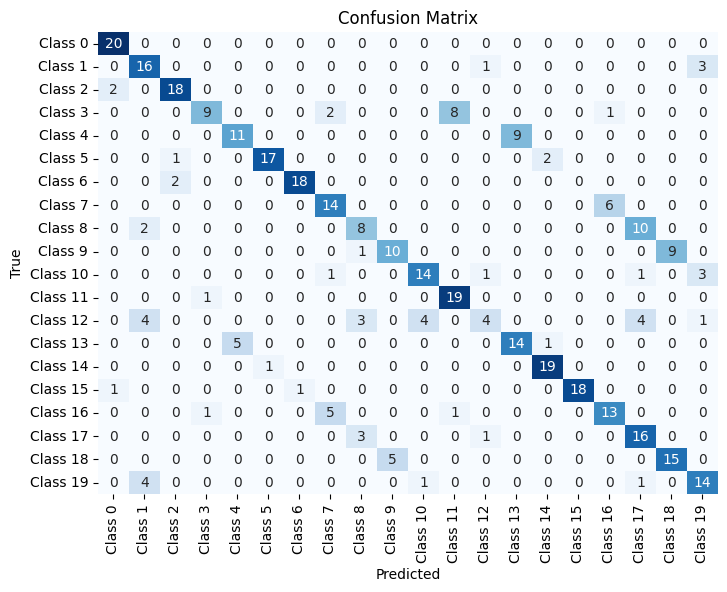

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

## CNN ViT

In [ ]:
del model

In [ ]:
model_name="HybridCNNVisionTransformer"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModelCNNViT(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_36 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 222, 222, 32)         896       ['input_36[0][0]']            
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d_6[0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1264.9309780597687 seconds


In [ ]:
visualize_model_architecture(model,filename=save_folder+'cnn_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/cnn_vit_model_architecture.png


13/13 [==============================] - 5s 128ms/step
Accuracy: 0.5675
Precision: 0.6354401655337429
Recall: 0.5675
F1 Score: 0.5372882283955203
AUC: 0.9702894736842105
Confusion Matrix:
 [[16  0  1  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  9  0  3  0  0  0  0  0  0  0  0  0]
 [ 3  0  9  0  0  0  7  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  3  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  1  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  1  2 10  0  0  2  1  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  4  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  2  4  0  0  0  0  0  0  0  0 14  0]
 [ 0  0  0  0  0  0  0  0  1  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0 11  0  4  0  0  0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-31-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


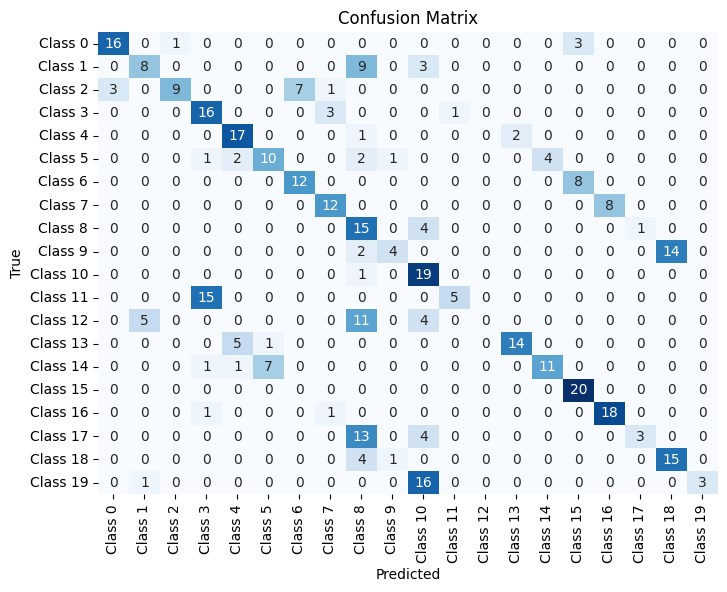

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


## MobileV2ViT

In [ ]:
model_name="MobileNetV2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


9406464/9406464 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_40[0][0]']            
                                                          2                                       
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_40[0][0]']            
 tional)                                                                                          
                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1571.5877876281738 seconds


13/13 [==============================] - 7s 176ms/step
Accuracy: 0.8425
Precision: 0.8463526290344165
Recall: 0.8425
F1 Score: 0.8390855919187693
AUC: 0.9928750000000001
Confusion Matrix:
 [[19  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 1  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  1  1  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  1 16  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 16  0  0  0  1  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  1  0  2  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0]
 [ 0  1  0  0  0  0  0  0  2  0 12  0  2  0  0  0  0  0  0  3]
 [ 0  0  0  2  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  1  1  0  0 12  0  0  0  0  0

<ipython-input-31-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


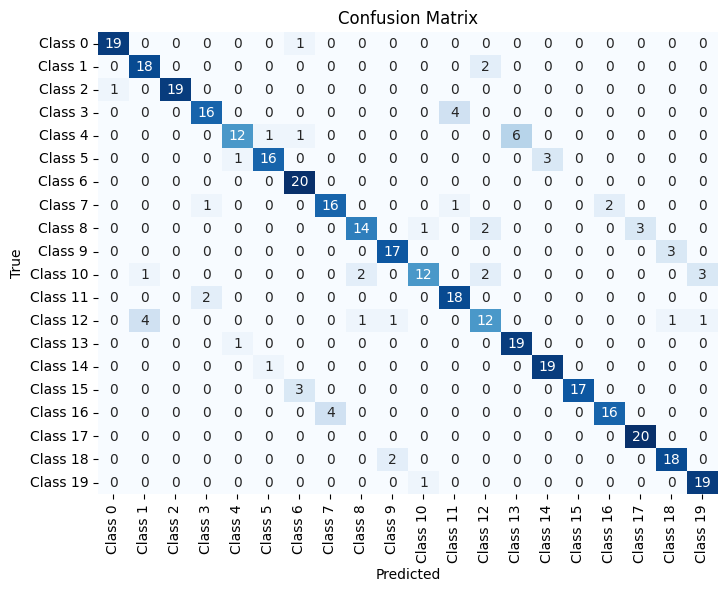

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration,durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'mobilev2_vit_model_architecture.png')


/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/mobilev2_vit_model_architecture.png


## ResNet101-VIT

In [ ]:
model_name="ResNet101"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_43 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_43[0][0]']            
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_43[0][0]']            
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 2145.7322869300842 seconds


13/13 [==============================] - 11s 325ms/step
Accuracy: 0.9075
Precision: 0.915482059892815
Recall: 0.9075
F1 Score: 0.9067398682397786
AUC: 0.9981644736842107
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  1  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  1  0  0 15  0  0  0  0  0

<ipython-input-31-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


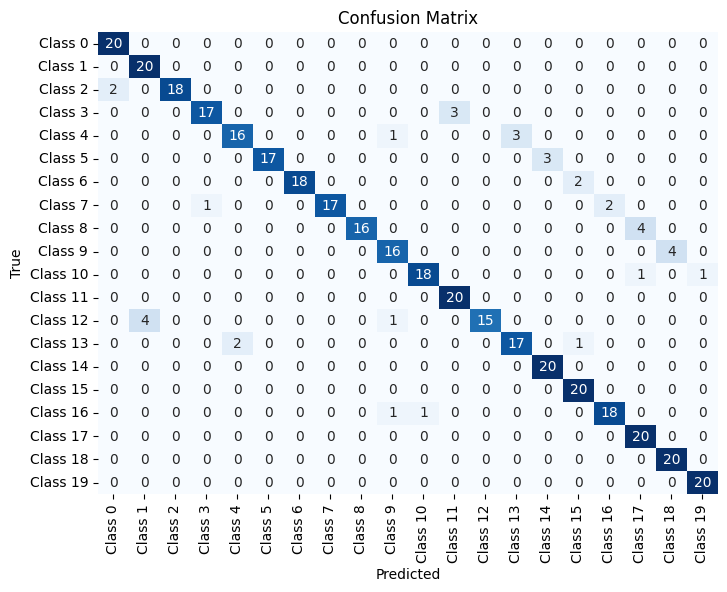

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


In [ ]:
visualize_model_architecture(model,filename=save_folder+'res101_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/res101_vit_model_architecture.png


## ResNet50

In [ ]:
del model

In [ ]:
model_name="ResNet50"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_46 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_46[0][0]']            
                                                          2                                       
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_46[0][0]']            
                                                          2                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1606.4550693035126 seconds


13/13 [==============================] - 7s 202ms/step
Accuracy: 0.8825
Precision: 0.8917516005280173
Recall: 0.8825
F1 Score: 0.8796586947015064
AUC: 0.9959473684210526
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 16  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0 13  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  1  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  1  0 16  0  1  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  1  0  0 12  0  0  0  0  0

<ipython-input-31-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


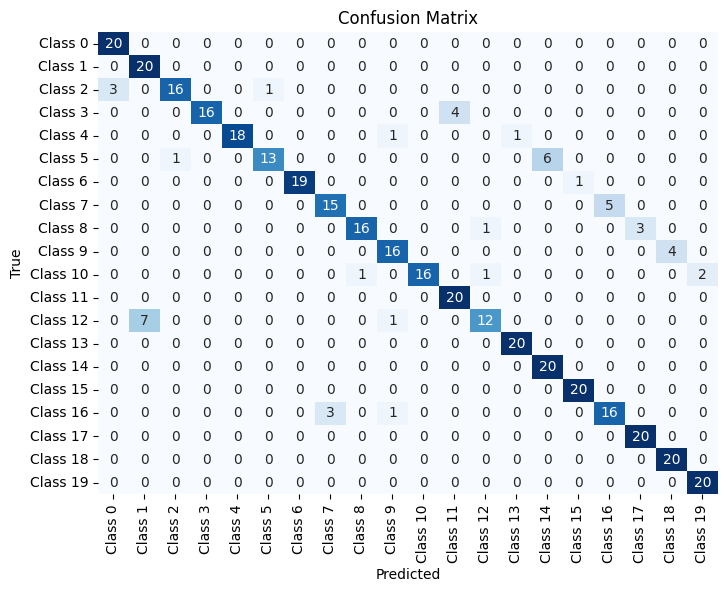

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


In [ ]:
visualize_model_architecture(model,filename=save_folder+'res50_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/res50_vit_model_architecture.png


## Hybrid ViT,ResNet50,MobileV3Small

In [ ]:
del model

In [ ]:
model_name="Res_Mob_ViT_best_arc"
save_model_dir = save_folder+model_name+'_extracted.h5'
model=createCombinedModel(img_size,num_classes)
visualize_model_architecture(model,filename=save_folder+'res50_mobv3_vit_model_architecture.png')
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

4334752/4334752 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/res50_mobv3_vit_model_architecture.png
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_5[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_5[0][0]']             
 al)                                                        

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1409.3527150154114 seconds


13/13 [==============================] - 13s 335ms/step
Accuracy: 0.9125
Precision: 0.9185779857061322
Recall: 0.9125
F1 Score: 0.9101924616231531
AUC: 0.9963684210526313
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 16  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  1  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  2  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0]
 [ 0  1  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0  1  2  0 12  0  0  0  0  

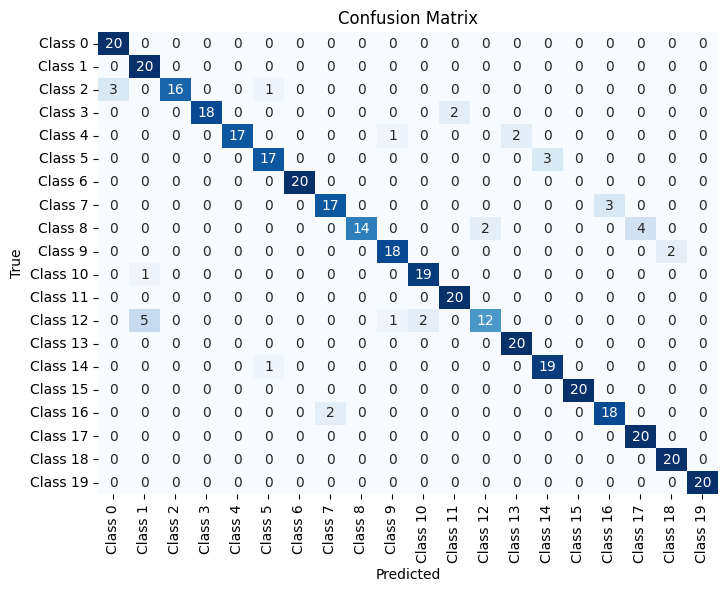

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


In [ ]:
# visualize_model_architecture(model,filename=save_folder+'res50_mobv3_vit_model_architecture.png')

## MobileNetV3Small

In [ ]:
del model

In [ ]:
model_name="MobileNetV3Small"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_38 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_38[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_38[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1316.2517154216766 seconds


13/13 [==============================] - 12s 162ms/step
Accuracy: 0.6825
Precision: 0.6818177432751064
Recall: 0.6825
F1 Score: 0.6727092956522271
AUC: 0.9782828947368423
Confusion Matrix:
 [[18  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  3]
 [ 4  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  1  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  0  8  1  0  0  0  0  0]
 [ 0  0  0  0  1 12  0  0  0  0  0  0  0  0  6  1  0  0  0  0]
 [ 0  0  1  0  0  0 18  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0 14  0  0  0  1  0  0  0  0  4  0  0  0]
 [ 0  2  0  0  0  0  0  0  7  0  3  0  1  0  0  0  0  6  0  1]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  2  0  0  0  1  0  6  0]
 [ 0  0  0  0  0  0  0  1  1  0  9  0  0  0  0  0  0  3  0  6]
 [ 0  0  0  2  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  7  0  1  0  3  0  0  0  0  

<ipython-input-15-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


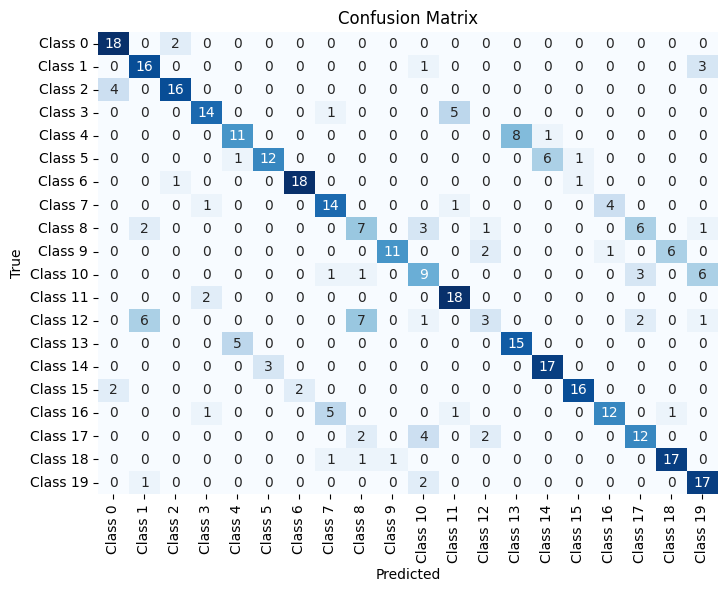

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'mobilev3s_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/mobilev3s_vit_model_architecture.png


#### test

In [ ]:
createTransferViTBatch

In [ ]:
del model

In [ ]:
model_name="MobileNetV3Small"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViTBatch(img_size,num_classes,model_name)
visualize_model_architecture(model,filename=save_folder+'mobilev3s_vit_model_architecture_batch.png')
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/mobilev3s_vit_model_architecture_batch.png
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_52 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_52[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_52[0][0]']            
 al)                                                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1323.0489978790283 seconds


13/13 [==============================] - 6s 161ms/step
Accuracy: 0.8625
Precision: 0.8700786517615837
Recall: 0.8625
F1 Score: 0.8566278758633135
AUC: 0.9964868421052632
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  1  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 14  1  0  0  0  1  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  1  0  0  0  0  0  0 12  0  4  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  1  1  1  0  9  0  0  0  0  0

<ipython-input-50-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


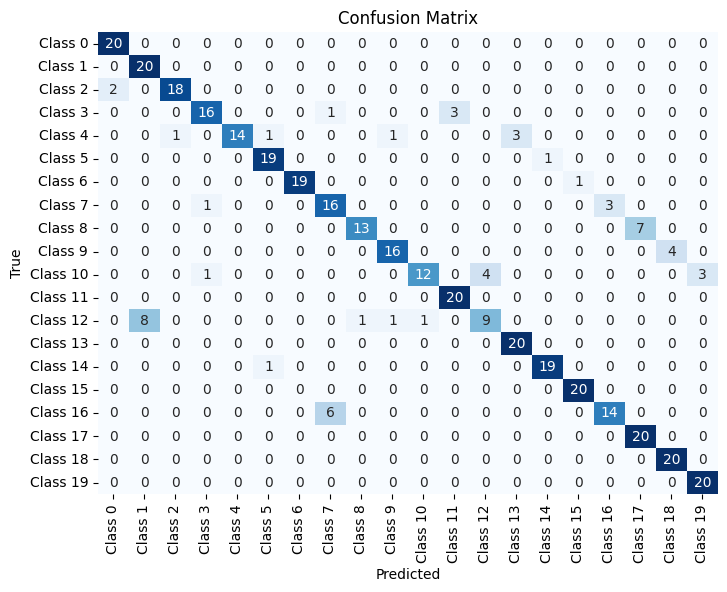

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

## Hybrid Res101,Dense201,ViT

In [ ]:
del model

In [ ]:
model_name="Den_Res101_ViT_best_arc"
save_model_dir = save_folder+model_name+'_extracted.h5'
model=createCombinedModelDense(img_size,num_classes)
visualize_model_architecture(model,filename=save_folder+'dense201_mobv3_vit_model_architecture.png')
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

171446536/171446536 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/dense201_mobv3_vit_model_architecture.png
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_13[0][0]']            
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_13[0][0]']            
                                                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 2103.3400399684906 seconds


13/13 [==============================] - 23s 712ms/step
Accuracy: 0.9025
Precision: 0.9087938244806598
Recall: 0.9025
F1 Score: 0.9000846720093965
AUC: 0.9979078947368422
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  1  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  1  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  1  0 17  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  1  3  0 12  0  0  0  0  

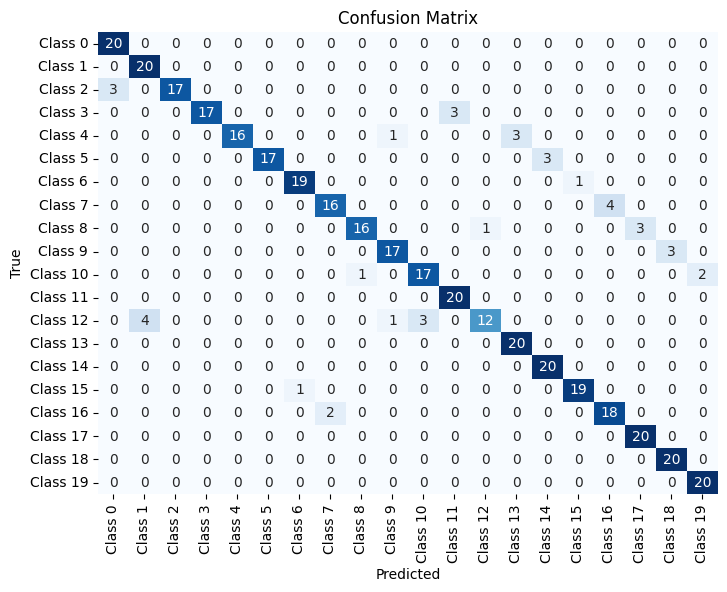

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

## DenseNet201

In [ ]:
del model

In [ ]:
model_name="DenseNet201"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


74836368/74836368 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_9[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_9[0][0]']             
                                                          4                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 2318.596638917923 seconds


13/13 [==============================] - 17s 510ms/step
Accuracy: 0.91
Precision: 0.9190125931044121
Recall: 0.91
F1 Score: 0.907374140855662
AUC: 0.9980789473684212
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  1  0 15  0  1  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  1  1  0 11  0  0  0  0  0  0 

<ipython-input-13-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/results.csv' successfully.


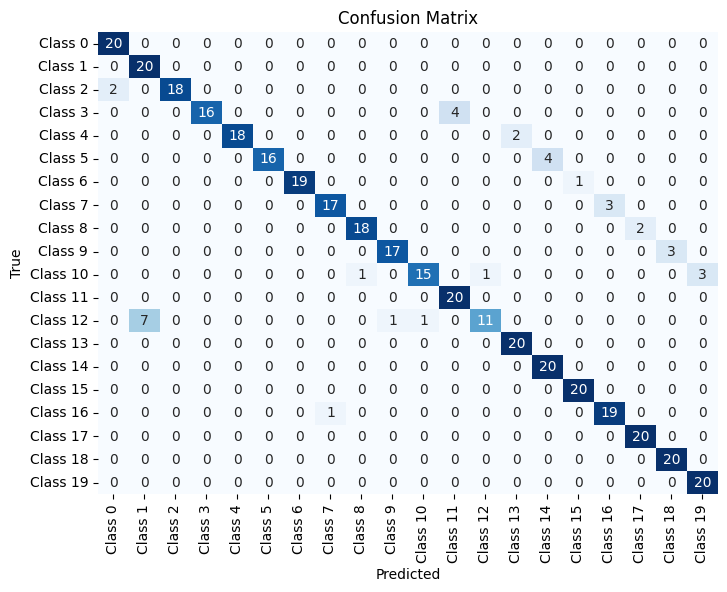

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'dense201_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer-NewDense/dense201_vit_model_architecture.png


## DenseNet121

In [ ]:
del model

In [ ]:
model_name="DenseNet121"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'dense121_vit_model_architecture.png')

## VGG16

In [ ]:
del model

In [ ]:
model_name="VGG16"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'vgg16_vit_model_architecture.png')

## MobileNetV3Large

In [ ]:
del model

In [ ]:
model_name="MobileNetV3Large"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

In [ ]:
visualize_model_architecture(model,filename=save_folder+'mobilev3l_vit_model_architecture.png')

# Cross Validation

In [ ]:
def load_fold_indexes(foldNumber,path):
    try:
        train_indexes = np.load(f'{path}/fold{foldNumber}_train_indexes.npy')
        test_indexes = np.load(f'{path}/fold{foldNumber}_test_indexes.npy')

        return train_indexes,test_indexes
    except FileNotFoundError:
        print(f"Error: Files for fold {foldNumber} not found.")
        return None, None

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard,CSVLogger

def addCallbacks(fold):
  cllbks=[]
  # Define the callback
  reduce_lr = ReduceLROnPlateau(
      monitor='val_loss',  # You can use 'val_accuracy' or other metrics
      factor=0.1,           # Factor by which the learning rate will be reduced. new_lr = lr * factor
      patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
      min_lr=1e-6,          # Lower bound on the learning rate
      verbose=1
  )
  cllbks.append(reduce_lr)
  # Define the EarlyStopping callback
  early_stopping = EarlyStopping(
          monitor='val_loss',  # Metric to monitor (e.g., validation loss)
          patience=patience,          # Number of epochs with no improvement before stopping
          verbose=1,            # Verbosity level (1 for updates, 0 for silent)
          restore_best_weights=True  # Restore model weights to the best observed during training
          )
  cllbks.append(early_stopping)
  log_dir = save_folder+"Logs/"+model_name+"_"+str(fold)
  if not os.path.exists(log_dir):
        os.makedirs(log_dir)
  csv_logger_callback = CSVLogger(log_dir+'/logs.csv')
  cllbks.append(csv_logger_callback)
  # log_dir = save_folder+"Logs/"+model_name
  # tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
  # # cllbks.append(tensorboard_callback)
  return cllbks
# callbacks=addCallbacks()

In [ ]:
import pandas as pd

def append_to_csv_epochs(file_path, model_name,fold_number, accuracy, precision, recall, f1_score, testing_time, training_time,epochs):
    """
    Append a row with evaluation metrics to an existing CSV file.

    Parameters:
    - file_path: The path to the CSV file.
    - model_name: Name of the model.
    - accuracy: Accuracy value.
    - precision: Precision value.
    - recall: Recall value.
    - f1_score: F1 score value.
    - testing_time: Time taken for testing in seconds.
    - training_time: Time taken for training in seconds.
    """

    # Check if the file exists
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        # If the file doesn't exist, create a new one with headers
        headers = ['Model Name','Fold Number', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Testing Time', 'Training Time','Epochs']
        df = pd.DataFrame(columns=headers)

    # Append a new row with the specified values
    new_row = pd.DataFrame({'Model Name': [model_name],
                         'Fold Number': [fold_number],
                        'Accuracy': [accuracy],
                        'Precision': [precision],
                        'Recall': [recall],
                        'F1-Score': [f1_score],
                        'Testing Time': [testing_time],
                        'Training Time': [training_time],
                        'Epochs': [epochs]})

    # df=pd.concat(new_row, ignore_index=True)
    df = pd.concat([df, new_row], ignore_index=True)


    # Save to the same CSV file
    df.to_csv(file_path, index=False)

    print(f"Row appended to '{file_path}' successfully.")

# Example usage:
# csv_file_path = "evaluation_metrics.csv"
# append_to_csv(csv_file_path, "ExampleModel", 0.85, 0.88, 0.82, 0.85, 30, 120)



In [ ]:
def create_model_cv(img_size,num_classes,model_name,f):
  match model_name:
    case "vit":
      m=createModelBaseViT(img_size,num_classes)
    case "cnn_vit":
      m=createModelCNNViT(img_size,num_classes)
    case "Res_Mob_ViT_best_arc":
      m=createCombinedModel(img_size,num_classes)

    case "Den_Mob_ViT_best_arc":
      m=createCombinedModel2(img_size,num_classes)
    case "DenseNet201-MobileNetV3Small-ViT":
      m=createCombinedModel3(img_size,num_classes)
    case "Res101-Dense201-ViT":
      m=createCombinedModel2(img_size,num_classes)
    case _ :
      m=createTransferViT(img_size,num_classes,model_name)

      exit()
  c=addCallbacks(f)
  m.summary()
  return m,c

In [ ]:
def load_split_data(f,Oimages, Olabels,fold_path):
  train_indexes,test_indexes = load_fold_indexes(f,fold_path)
  if train_indexes is not None and test_indexes is not None:
    # Now you have the indexes for training and validation
    # You need to extract the actual data from your original data arrays
    all_X_train = Oimages[train_indexes]
    all_y_train = Olabels[train_indexes]
    X_test = Oimages[test_indexes]
    y_test = Olabels[test_indexes]
    X_train, X_val, y_train, y_val = train_test_split(all_X_train, all_y_train, test_size=0.2, random_state=42,stratify=all_y_train)
    y_train = encode_labels(y_train)
    y_test = encode_labels(y_test)
    y_val = encode_labels(y_val)
  return X_train,y_train,X_test,y_test,X_val,y_val

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_dic(confusion_matrix, class_label_mapping, save_path=None):
    """
    Plot a confusion matrix as a heatmap.

    Parameters:
    - confusion_matrix (numpy.ndarray): Confusion matrix.
    - class_label_mapping (dict): Mapping of class indices to class labels.
    - save_path (str): Path to save the heatmap plot. If None, the plot is displayed but not saved.

    Returns:
    - None
    """
    plt.figure(figsize=(10, 8))

    # Using Seaborn heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[class_label_mapping[i] for i in range(1, confusion_matrix.shape[0] + 1)],
                yticklabels=[class_label_mapping[i] for i in range(1, confusion_matrix.shape[1] + 1)])

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()

# Example usage:
# Assuming you have a confusion matrix named 'conf_matrix'
# and you want to save the heatmap to a file named 'confusion_matrix_heatmap.png'
# plot_confusion_matrix(conf_matrix, class_label_mapping, save_path='confusion_matrix_heatmap_extracted.png')


In [ ]:
import cv2
import numpy as np

def resize_images_cv2(image_array,wdith,height):
    """
    Resize each image in the input numpy array to 224x224 pixels using cv2.

    Parameters:
    - image_array (numpy.ndarray): Input array of images.

    Returns:
    - resized_images (numpy.ndarray): Array of resized images.
    """
    resized_images = []

    for image in image_array:
        # Resize the image to 224x224 pixels using cv2
        resized_image = cv2.resize(image, (wdith,height))

        resized_images.append(resized_image)

    return np.array(resized_images)

# Example usage:
# Assuming you have a numpy array named 'original_images' containing your images
# resized_images = resize_images_cv2(original_images)

## Paramters

In [ ]:
# create top 6 models
model_names=['DenseNet201','ResNet101',
             'Den_Mob_ViT_best_arc','ResNet50',
             'Res_Mob_ViT_best_arc','MobileNetV3Small']
class_label_mapping = {
    1: 'Deep Squat',
    2: 'Hurdle Step',
    3: 'Inline Lunge',
    4: 'Side Lunge',
    5: 'Sit to Stand',
    6: 'Standing Leg Raise',
    7: 'Shoulder Abudction',
    8: 'Shoulder Extension',
    9: 'Shoulder Internal-External Rotation',
    10: 'Shoulder Scaption',
    11: 'Incorrect - Deep Squat',
    12: 'Incorrect - Hurdle Step',
    13: 'Incorrect - Inline Lunge',
    14: 'Incorrect - Side Lunge',
    15: 'Incorrect - Sit to Stand',
    16: 'Incorrect - Standing Leg Raise',
    17: 'Incorrect - Shoulder Abudction',
    18: 'Incorrect - Shoulder Extension',
    19: 'Incorrect - Shoulder Internal-External Rotation',
    20: 'Incorrect - Shoulder Scaption'

}

In [ ]:
batch_size = 64
num_classes = 20  # Replace with the actual number of classes in your dataset
epochs=150
width=224
height=224
patience=30
img_size=(width, height, 3)
num_folds=5
dataset_path='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images_extracted/Extracted_IMGs/'
fold_path='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images_extracted/folds'
save_folder=save_folder+'cv/'
csv_file_path=save_folder+"results_cv.csv"
# create_empty_csv_file(save_folder+"results.csv")

In [ ]:
from sklearn.preprocessing import LabelEncoder

#load data
Oimages, Olabels = load_images_and_labels_f(dataset_path)
# Convert labels from string to numbers
label_encoder = LabelEncoder()
Olabels_numeric = label_encoder.fit_transform(Olabels)


In [ ]:
Oimages = resize_images_cv2(Oimages,width, height)
Oimages[0].shape

In [ ]:
fold_path

'/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images_extracted/folds'

In [ ]:
load_split_data(1,Oimages, Olabels_numeric,fold_path)

(array([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         ...,
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
   

In [ ]:
# epochs=1

## Fold 1

Processing Model 1 of 7 : DenseNet201
353253686/353253686 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


74836368/74836368 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_3[0][0]']             
                                                          4                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 22s 736ms/step
Accuracy: 0.8575
Precision: 0.8660349201396111
Recall: 0.8575
F1 Score: 0.8549011554483386
AUC: 0.9945765583090956
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 18  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 14  2  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  1  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  1  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  1  0 16  0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  1  0 15  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0  3  0 10  0  0  0  0  

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


171446536/171446536 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_6[0][0]']             
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_6[0][0]']             
                                                          6                                       
                  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 13s 410ms/step
Accuracy: 0.88
Precision: 0.8854085628732031
Recall: 0.88
F1 Score: 0.8777273535456664
AUC: 0.9968717677528977
Confusion Matrix:
 [[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  1  0  0  0  1  0  0  0  5  1  0  0  0  0  0]
 [ 0  0  0  0  1 16  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  2  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  1  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  2  0 13  0  0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_10[0][0]']            
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_10[0][0]']            
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 16s 415ms/step
Accuracy: 0.89
Precision: 0.8926511553237896
Recall: 0.89
F1 Score: 0.8887365827338216
AUC: 0.9959879465561803
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 20  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  1  0  0  0  1  0  0  0  5  1  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  1  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  1  0 18  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  1  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  1

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


94765736/94765736 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_13[0][0]']            
                                                          2                                       
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_13[0][0]']            
                                                          2                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 7s 204ms/step
Accuracy: 0.8825
Precision: 0.8863721294512535
Recall: 0.8825
F1 Score: 0.8818905863747385
AUC: 0.9968266843614192
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0 19  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  1  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  1  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0 18  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  1  0  0  0  0  0  0  4]
 [ 0  0  0  1  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  1  1  0 14  0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_17[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_17[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 11s 361ms/step
Accuracy: 0.8925
Precision: 0.8967973695112189
Recall: 0.8925
F1 Score: 0.8891606815824282
AUC: 0.9979695975589312
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 18  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  1  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  1  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  1  0 19  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0 14  0  1  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  1  1  2  0 10  0  0  0  0  

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_20[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_20[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 5s 126ms/step
Accuracy: 0.83
Precision: 0.840616361669806
Recall: 0.83
F1 Score: 0.8277645850113028
AUC: 0.9928300011915834
Confusion Matrix:
 [[19  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  1  0  3  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 1  0  1  0  0  0 15  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  1  0  0  0  0 17  1  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 11  0  0  0  1  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  1  0 15  0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  1  0  6]
 [ 0  0  0  1  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  1  0  2  0 12  0  0  0  0  1  0  

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_10 (Flatten)        (None, 768)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_18 (Dense)            (None, 352)               270688    
                                                                 
 dropout_12 (Dropout)        (None, 352)               0         
                                                                 
 dense_19 (Dense)            (None, 176)               62128     
                                                

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 4s 117ms/step
Accuracy: 0.63
Precision: 0.6421971629890427
Recall: 0.63
F1 Score: 0.6215204948670362
AUC: 0.9773874863969709
Confusion Matrix:
 [[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  6]
 [ 2  0 18  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0]
 [ 0  0  2  0 11  1  0  0  0  0  0  0  0  5  1  0  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0  0  0  0  0  7  0  0  0  1  0]
 [ 1  0  1  0  1  0  9  0  0  0  0  0  0  0  0  7  0  0  0  0]
 [ 0  0  0  1  0  0  0 13  1  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  1  0  0  0  0  4  0  0  0  3  0  0  0  0  7  0  3]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  1  0  0  0  0  0  7  0]
 [ 0  3  0  0  0  0  0  0  0  0  6  0  1  0  0  0  0  5  0  5]
 [ 0  0  0  1  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  3  2  0  0  4  0  0  0  0  4  0 

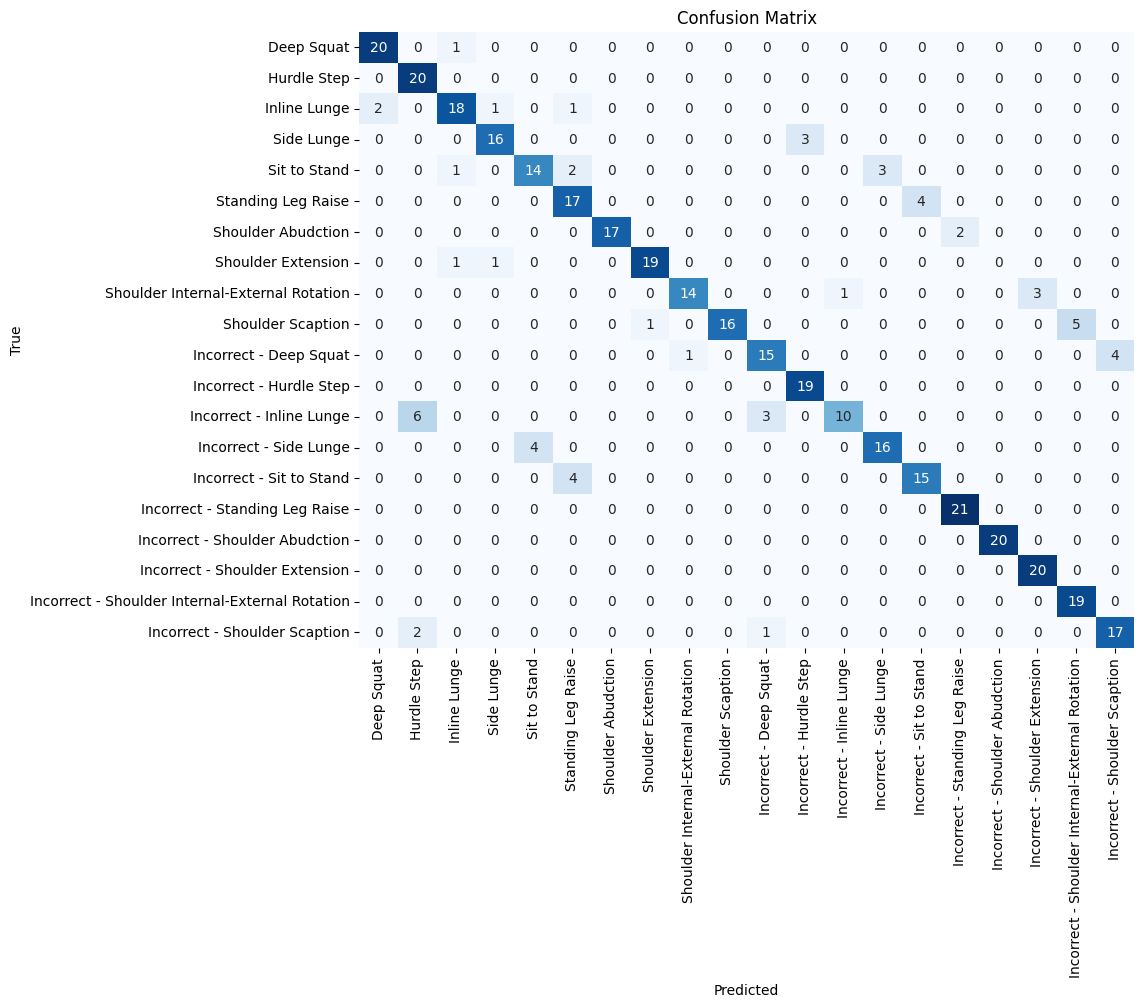

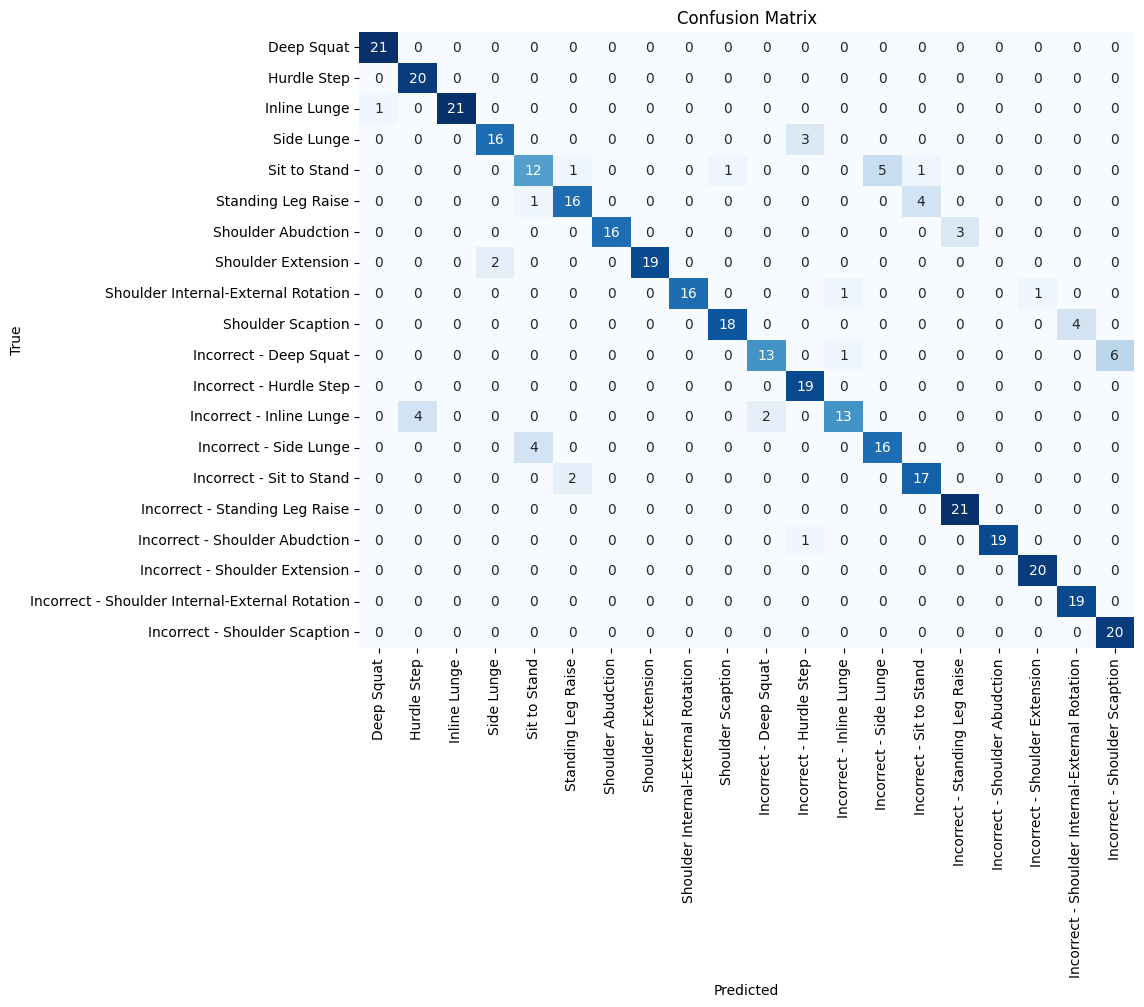

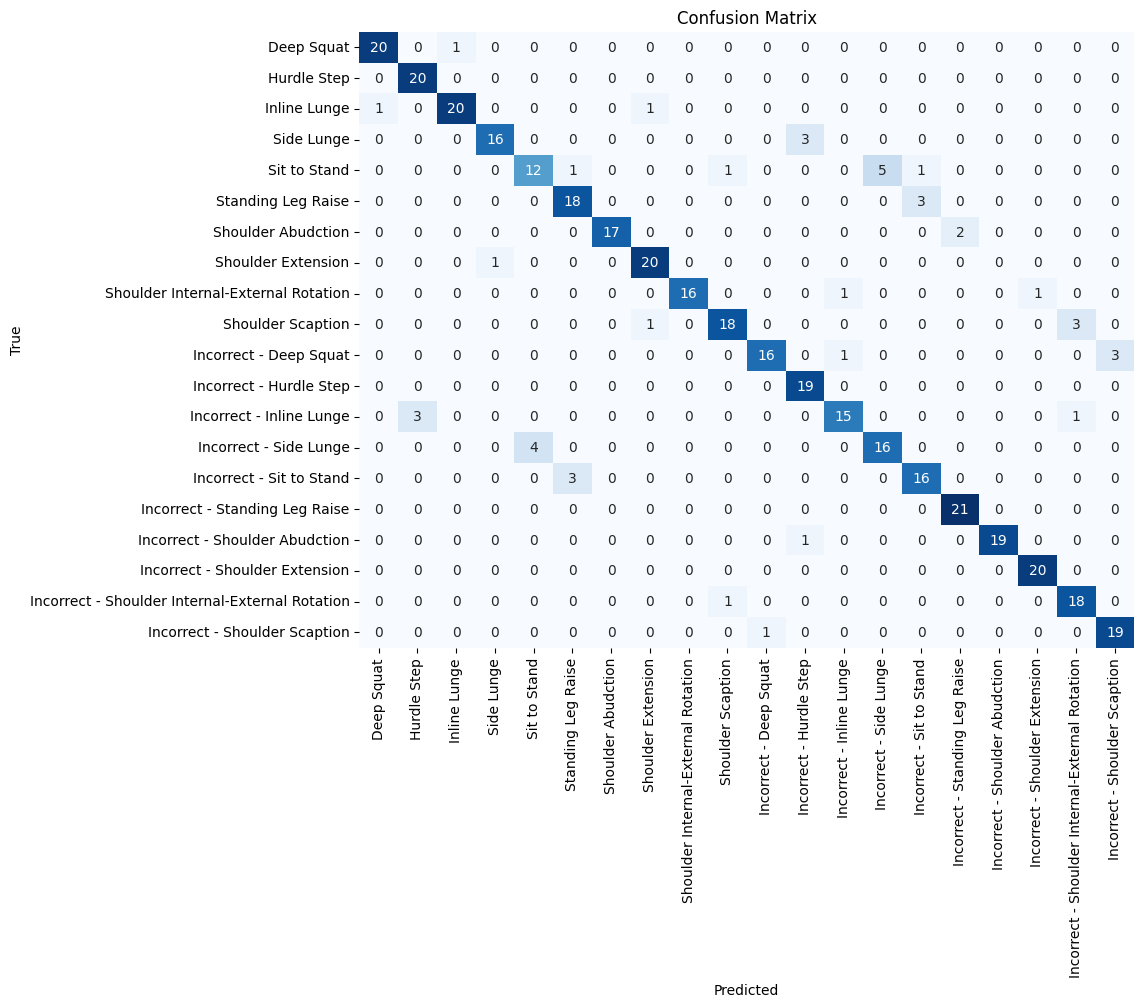

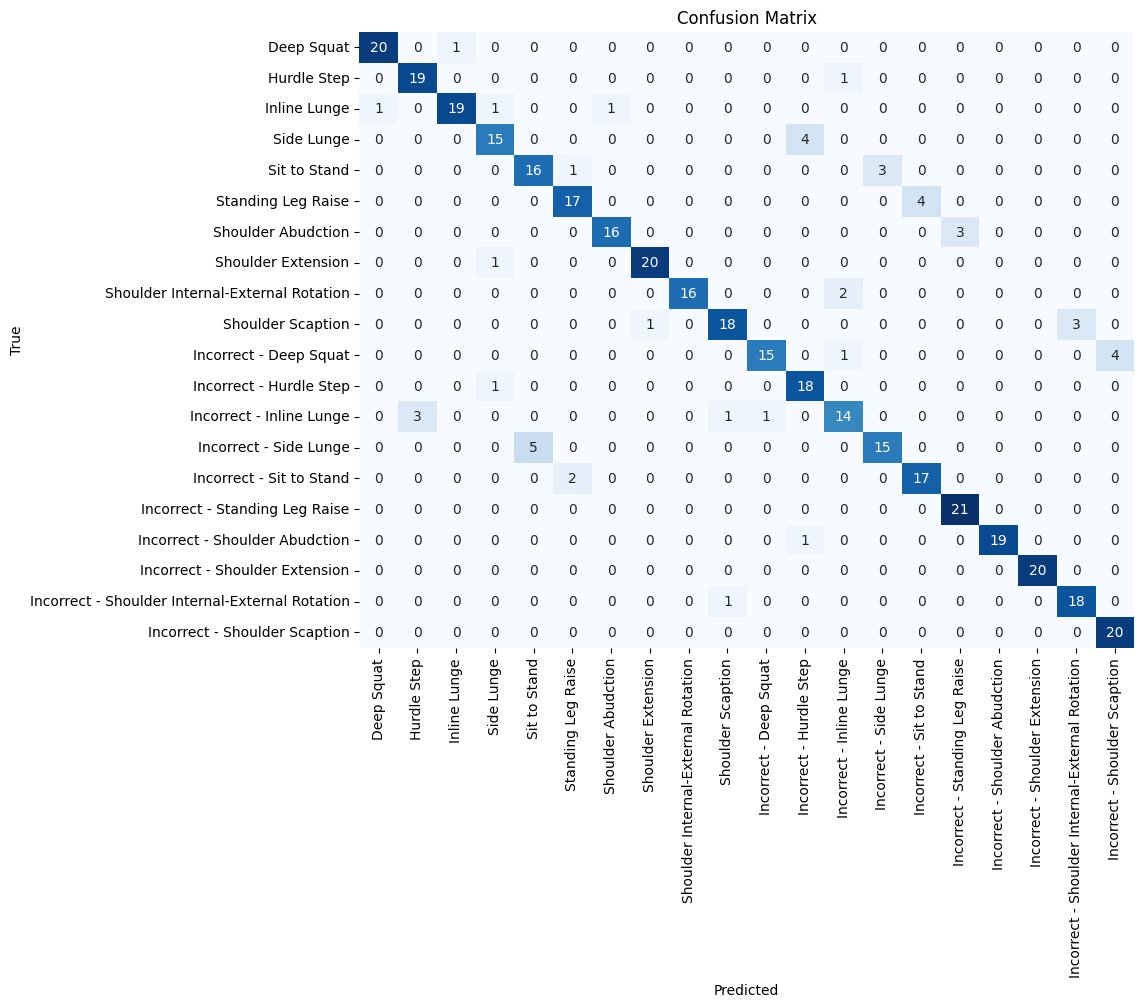

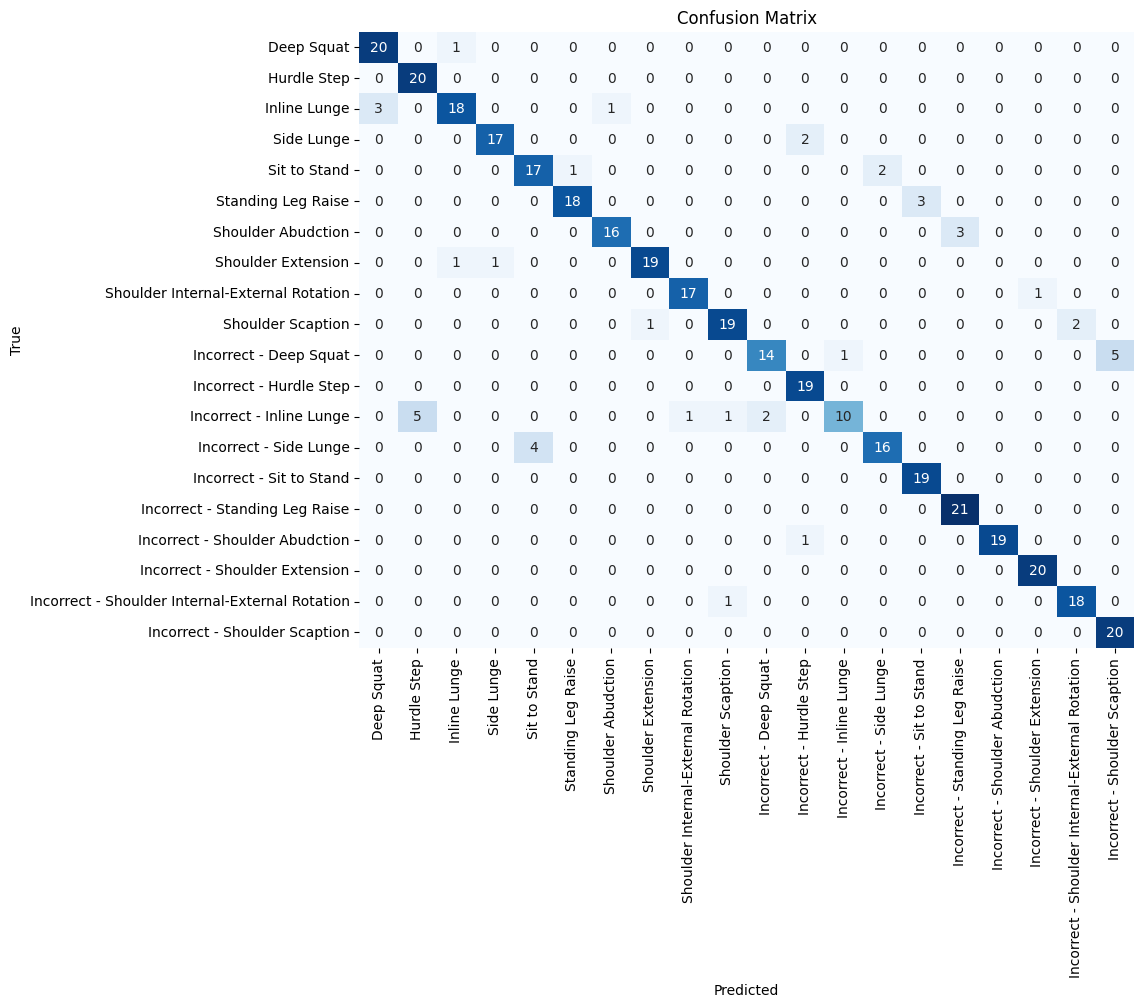

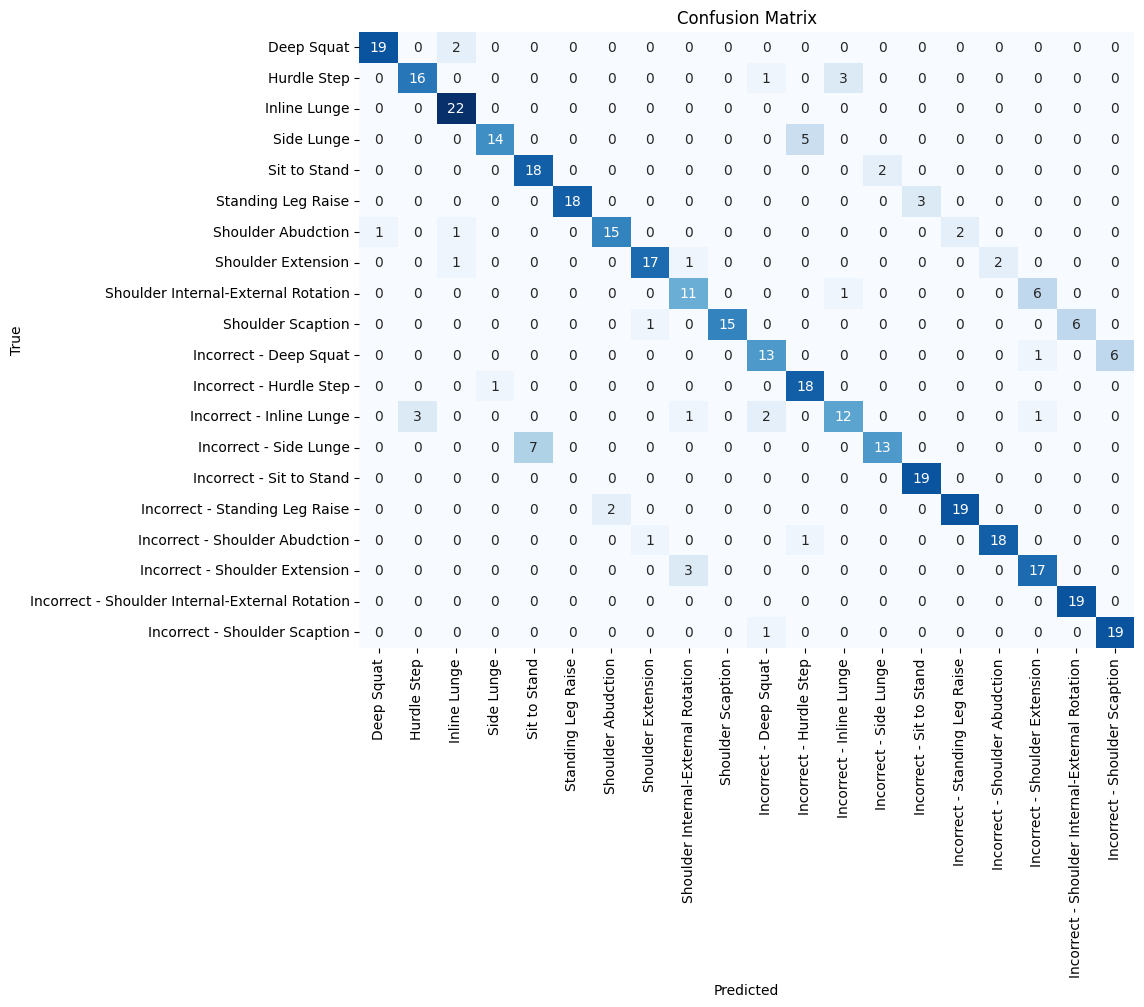

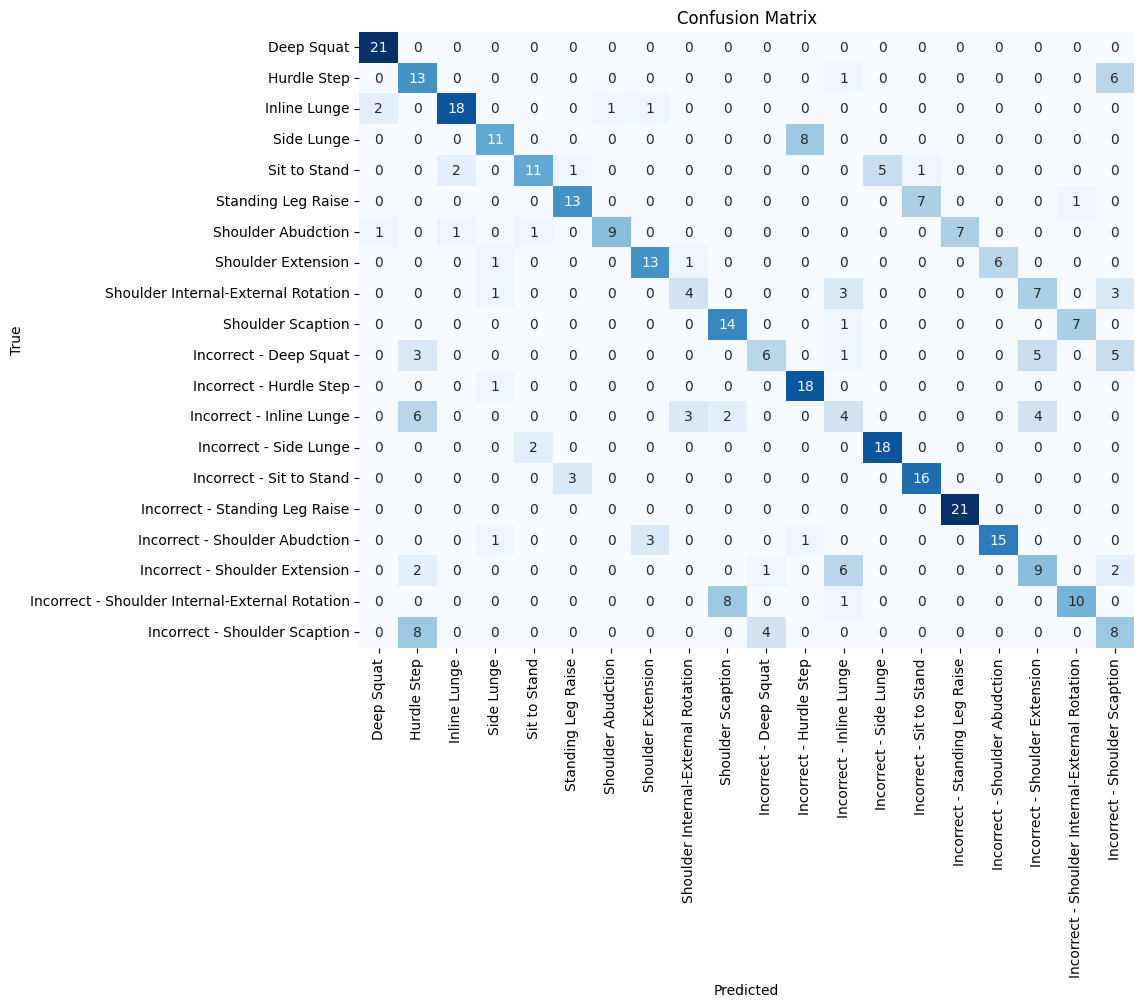

In [ ]:
fold_number = 1
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Fold 2

Processing Model 1 of 7 : DenseNet201


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_25[0][0]']            
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_25[0][0]']            
                                                          4                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 11s 257ms/step
Accuracy: 0.8825
Precision: 0.891061950013239
Recall: 0.8825
F1 Score: 0.8804168781142591
AUC: 0.9971788083227804
Confusion Matrix:
 [[18  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  1]
 [ 1  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  3  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  1  0  0  0 14  0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_28 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_28[0][0]']            
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_28[0][0]']            
                                                          6                                       
                                                                                     

ResourceExhaustedError: ignored

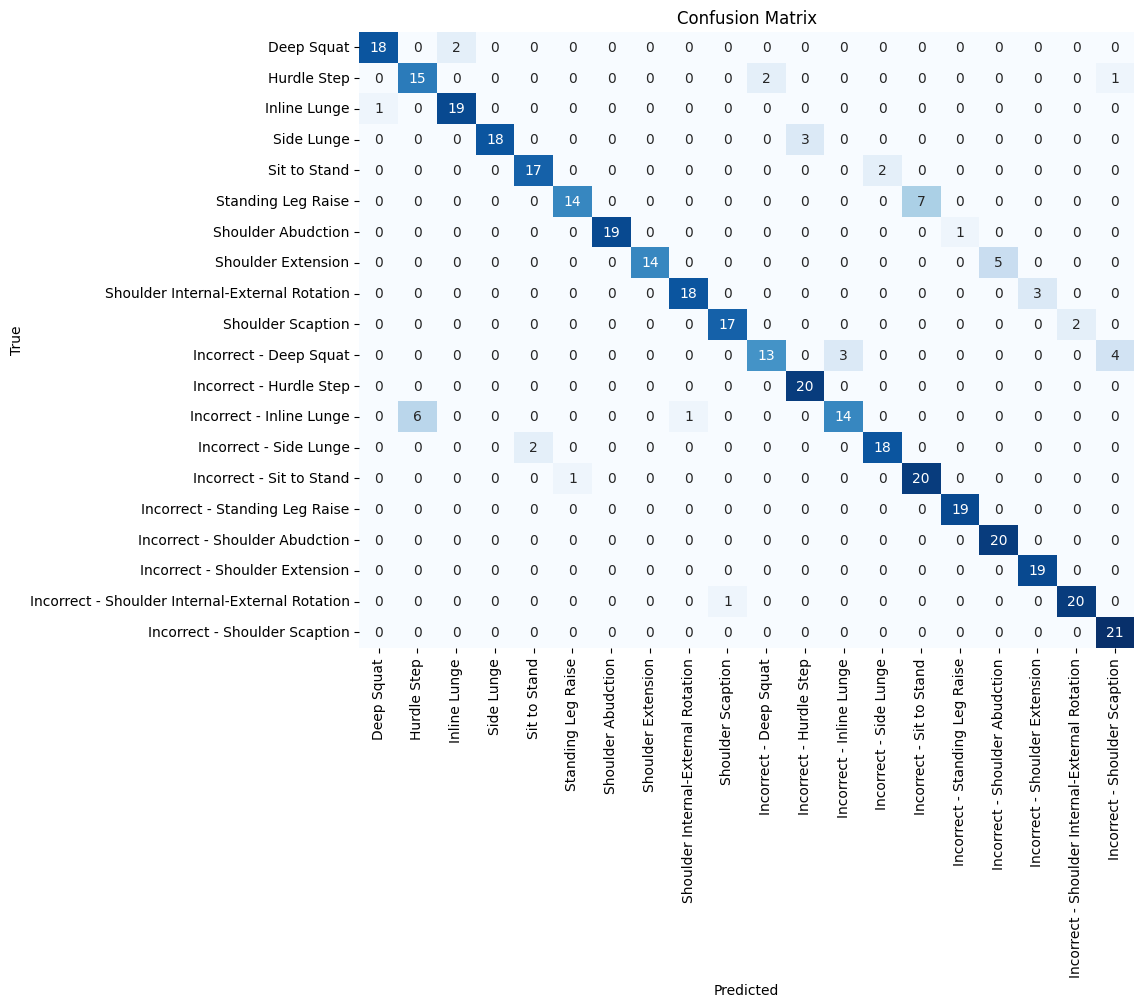

In [ ]:
fold_number = 2
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Fold 3

In [ ]:
fold_number = 3
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Fold 4

Processing Model 1 of 6 : DenseNet201
353253686/353253686 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


74836368/74836368 [==============================] - 4s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_3[0][0]']             
                                                          4                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 22s 688ms/step
Accuracy: 0.8575
Precision: 0.8690448923097384
Recall: 0.8575
F1 Score: 0.8532112394200762
AUC: 0.9943529068816703
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 3  0 15  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 14  0  0  1  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  1 13  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  1  0  4  0  0  0  0]
 [ 0  0  0  1  0  0  0 15  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  2  0  0  0  0  0  0 14  1  1  0  1  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  1  0  0  0 16  0  0  0  0  

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


171446536/171446536 [==============================] - 9s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_6[0][0]']             
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_6[0][0]']             
                                                          6                                       
                  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 13s 380ms/step
Accuracy: 0.8475
Precision: 0.8532365893922463
Recall: 0.8475
F1 Score: 0.8411948987767753
AUC: 0.9949680335589083
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 15  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  1  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  1  0  0  0  0  0  0  0  4  1  0  0  0  0  0]
 [ 0  0  0  0  2  9  0  1  0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  1  0  0  0 14  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  1  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  3  0 11  0  0  0  0  0  0  0  0  7]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  3  0 14  0  0  0  0  

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_10[0][0]']            
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_10[0][0]']            
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 15s 390ms/step
Accuracy: 0.8875
Precision: 0.8947691394843771
Recall: 0.8875
F1 Score: 0.8845014052648291
AUC: 0.9939028152810504
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0 15  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  2  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  1  0  0  0 15  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0 16  0  0  0  3  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  1  0 13  0  1  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0  1  0 17  0  0  0  0  

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


94765736/94765736 [==============================] - 5s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_13[0][0]']            
                                                          2                                       
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_13[0][0]']            
                                                          2                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 6s 196ms/step
Accuracy: 0.8625
Precision: 0.8684947888495945
Recall: 0.8625
F1 Score: 0.8602890684754929
AUC: 0.9944630745456887
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 16  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  1  0  0  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 14  2  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 1  0  0  0  0  0 17  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  1  0  0  0 15  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  1  0  0  0  0  0  0 15  0  0  0  2  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  1  0 14  0  1  0  0  0  0  0  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_17[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_17[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 13s 320ms/step
Accuracy: 0.8675
Precision: 0.8758961567328438
Recall: 0.8675
F1 Score: 0.864615440293715
AUC: 0.9948578600201892
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0 15  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  1  1  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  1  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 1  0  0  0  0  0 17  0  0  0  0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  1  0  0  0 16  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  2  0  0  0  0  0  0 16  0  0  0  1  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0 14  0  1  0  0  0  0  1  0  5]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  1  0  1  0 16  0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_20[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_20[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 5s 125ms/step
Accuracy: 0.85
Precision: 0.8588184138676632
Recall: 0.85
F1 Score: 0.8450506516479139
AUC: 0.9946670706239938
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  1  0  1  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  1  0  0  0  0  0  0  0  4  1  0  0  0  0  0]
 [ 0  0  0  0  2 12  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  1  0  0  0 15  0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  1  0  0  0 13  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  2  0  0  0  0  0  0 16  0  0  0  1  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  1  0 12  0  1  0  0  0  0  0  0  7]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  1  0  2  0 14  0  0  0  0  0  0 

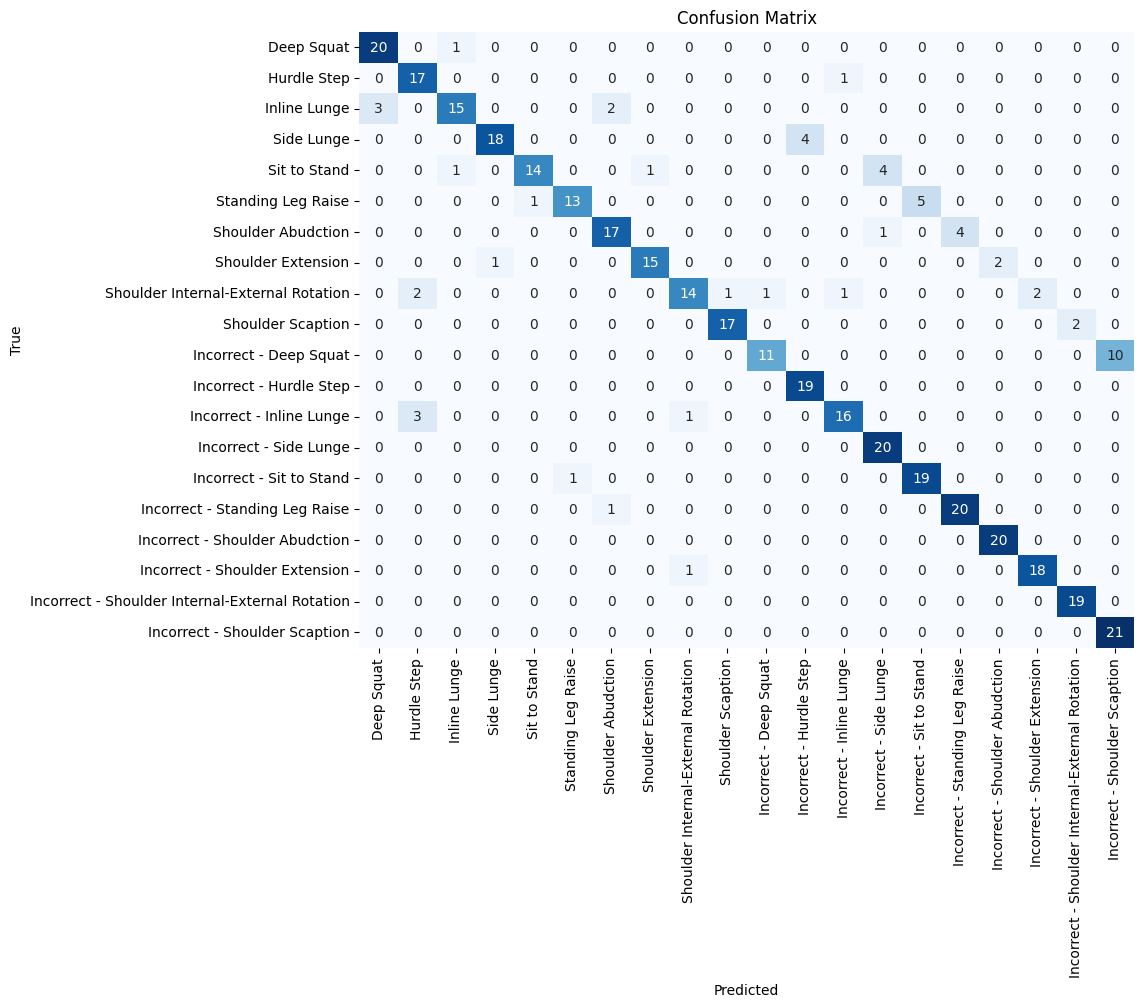

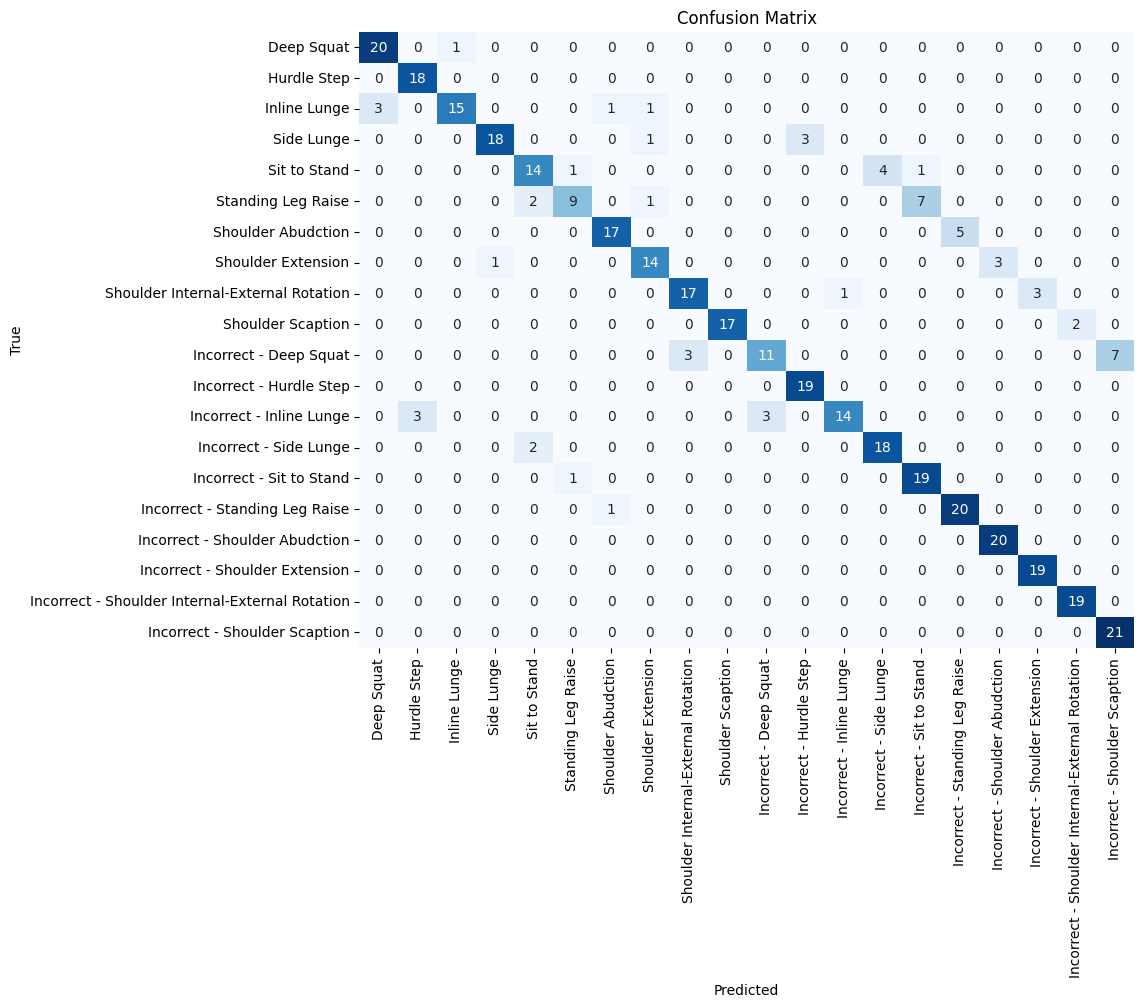

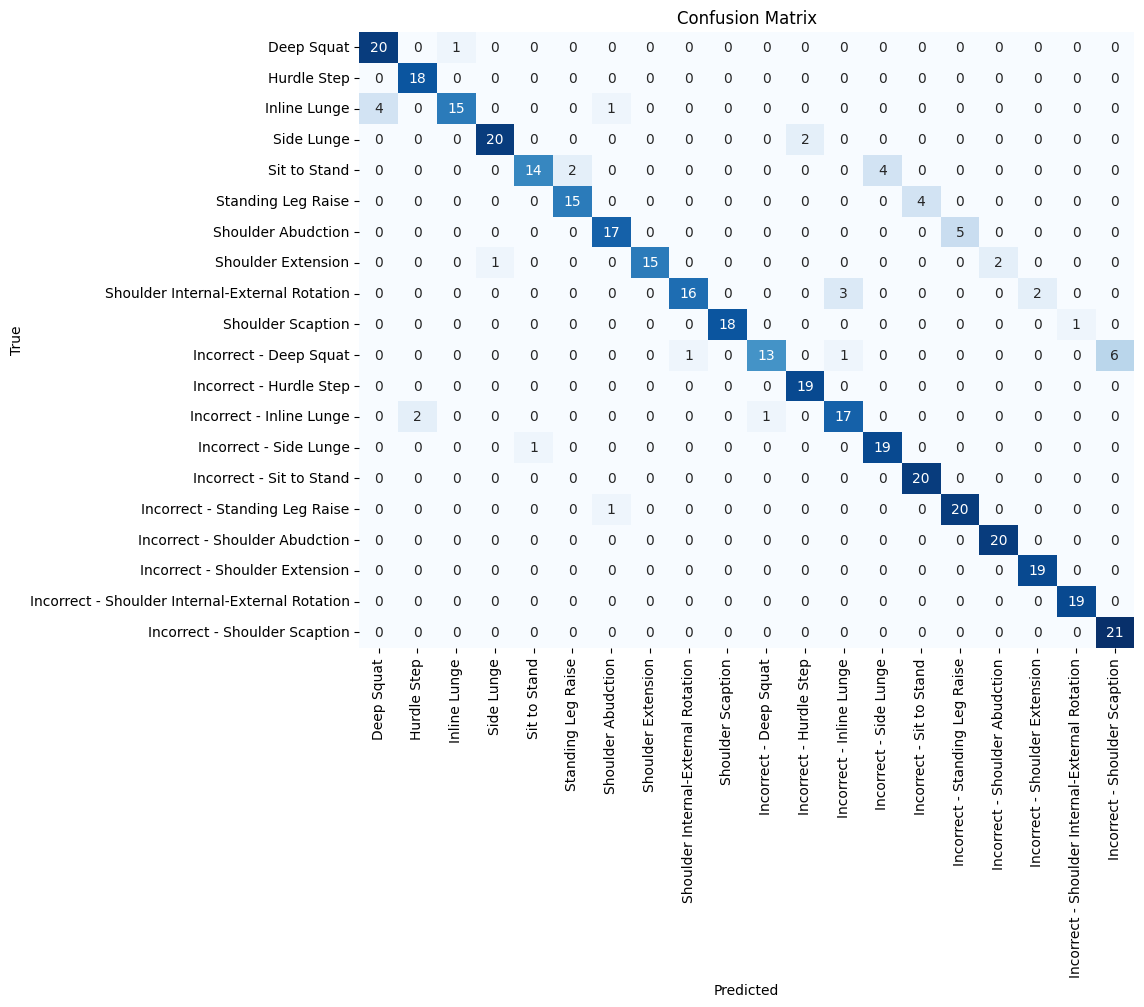

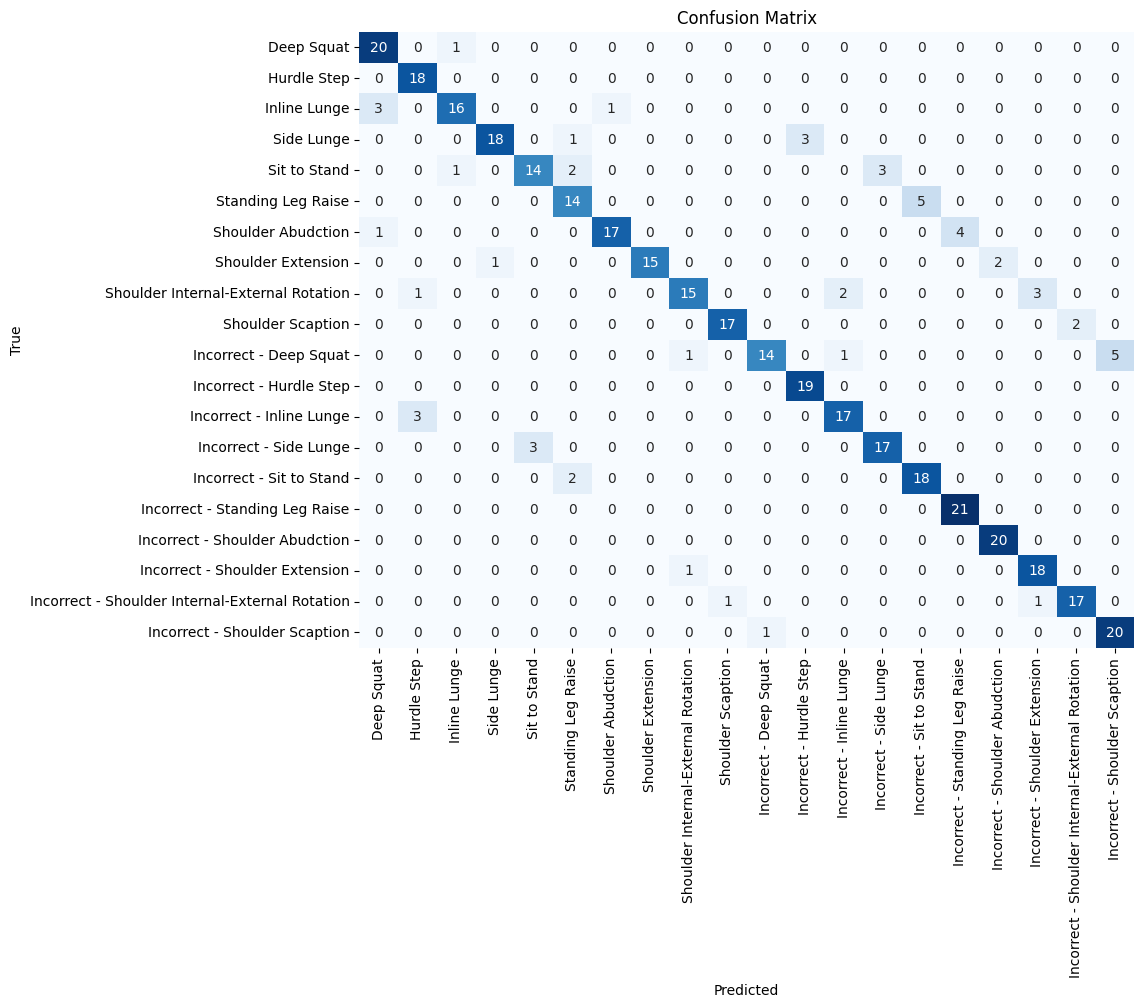

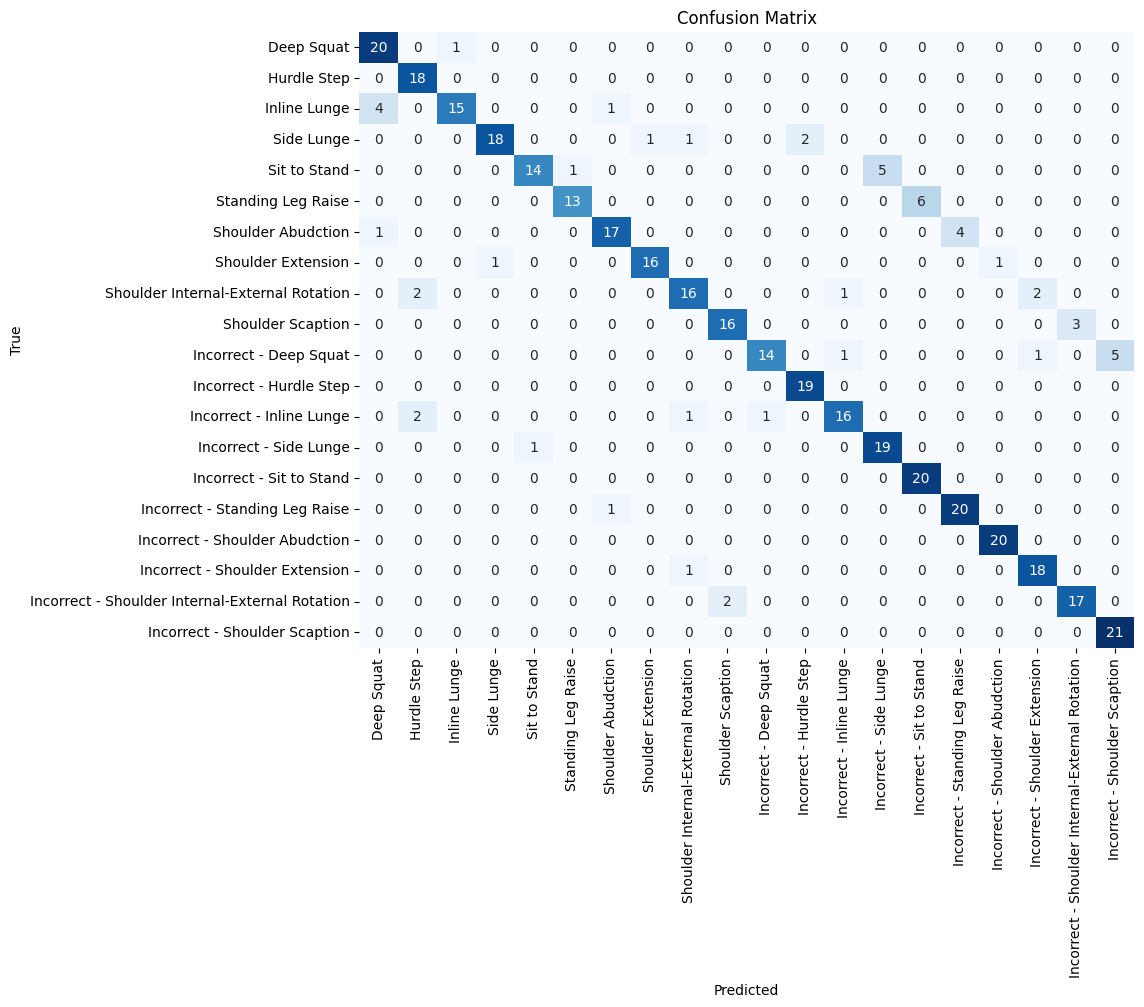

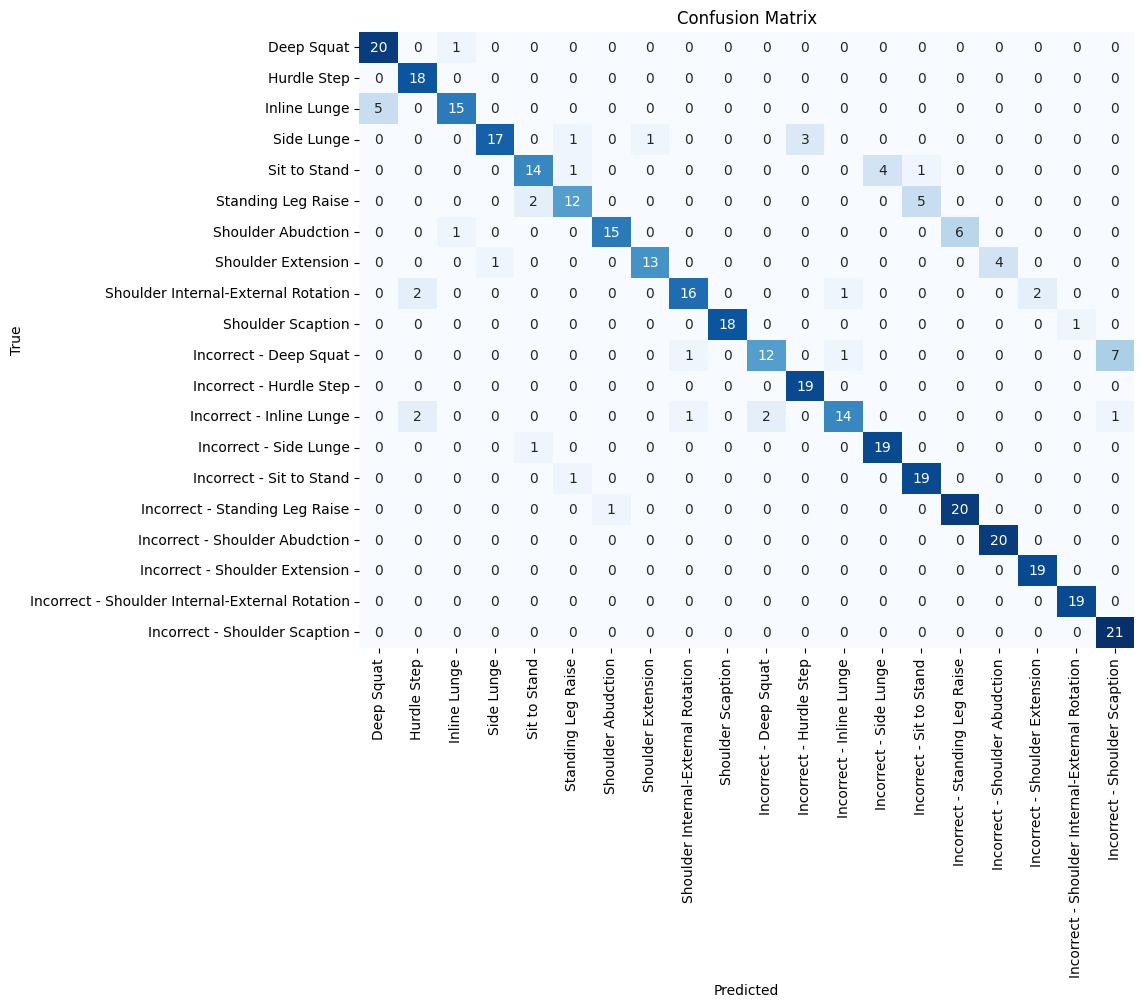

In [ ]:
fold_number = 4
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Fold 5

In [ ]:
fold_number = 5
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 6 : DenseNet201
353253686/353253686 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


74836368/74836368 [==============================] - 4s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_3[0][0]']             
                                                          4                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 24s 747ms/step
Accuracy: 0.8425
Precision: 0.8412768492732049
Recall: 0.8425
F1 Score: 0.834817311908777
AUC: 0.9946306222871554
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 2  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 16  0  0  0  0  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  2  0  0  0 13  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0 13  1  0  0  2  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  2  0 13  0  0  0  0  0  0  0  0  4  0]
 [ 0  1  0  0  0  0  0  0  0  0  8  0  2  0  0  0  0  0  0  8]
 [ 0  0  0  3  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  4  0  4  0  9  0  0  0  0  1

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


171446536/171446536 [==============================] - 8s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_6[0][0]']             
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_6[0][0]']             
                                                          6                                       
                  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 13s 407ms/step
Accuracy: 0.87
Precision: 0.8775145593743275
Recall: 0.87
F1 Score: 0.8688867817552215
AUC: 0.996066318206268
Confusion Matrix:
 [[18  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 2  0 16  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  1  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  1  0  1  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  1  0 13  0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  0  0 15  0  1  0  0  0  0  1  0  2]
 [ 0  0  0  1  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  2  0  1  0  0  0  0  1  0  0  0 15  0  0  0  0  2  0 

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_10[0][0]']            
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_10[0][0]']            
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 15s 397ms/step
Accuracy: 0.915
Precision: 0.9181882777814684
Recall: 0.915
F1 Score: 0.9144313106067925
AUC: 0.9973117554028974
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 1  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  1  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  1  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  2  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  2  0  0  0  0  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  2  0  1  0 16  0  0  0  0  0 

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


94765736/94765736 [==============================] - 5s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_13[0][0]']            
                                                          2                                       
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_13[0][0]']            
                                                          2                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 6s 207ms/step
Accuracy: 0.8975
Precision: 0.8995803983154528
Recall: 0.8975
F1 Score: 0.8957073849899541
AUC: 0.9958576333811655
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  1  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 14  0  1  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  1  0  3  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  1 15  0  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  0  0  1  0 14  0  2  0  0  0  0  0  0  2]
 [ 0  0  0  2  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  4  0  0  0 15  0  0  0  0  1

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_17[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_17[0][0]']            
 al)                                                                                              
                                                                                     

In [ ]:
model_names=['MobileNetV3Small']

Processing Model 1 of 1 : MobileNetV3Small


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_3[0][0]']             
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 8s 200ms/step
Accuracy: 0.8475
Precision: 0.8556167026623263
Recall: 0.8475
F1 Score: 0.8426536962358866
AUC: 0.9956751296782536
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 1  0 17  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  0  0  0  1  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  1 15  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 1  0  1  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  1  1  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  2  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  7  0]
 [ 0  1  0  0  0  0  0  1  0  0  9  0  2  0  0  0  0  0  0  6]
 [ 0  0  0  2  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  3  0  0  0 13  0  0  0  0  2

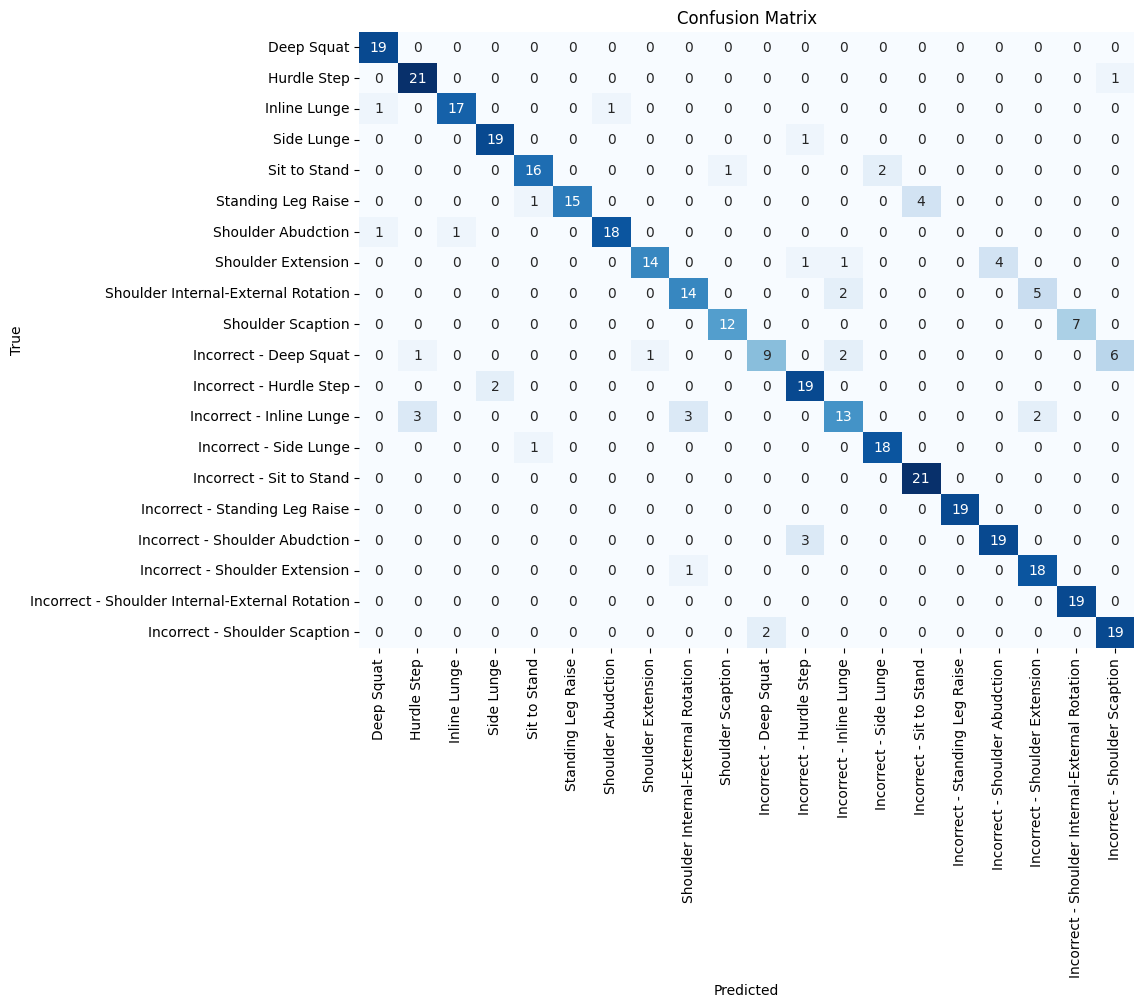

In [ ]:
fold_number = 5
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

In [ ]:
import pandas as pd
def calculate_metrics_and_save(csv_file_path, output_csv_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)
    print(df.columns)
    # Group the DataFrame by 'Model Name'
    grouped_df = df.groupby('Model Name')

    # Calculate mean, median, and max for specific columns
    result = grouped_df.agg({
        'Accuracy': ['mean', 'median', 'max'],
        'Testing Time': ['mean', 'median', 'max'],
        'Epochs': ['mean', 'median', 'max'],
        'Training Time': ['mean', 'median', 'max']
    })

    # Print the result
    print(result)

    # Save the result to a new CSV file
    result.to_csv(output_csv_path)

In [ ]:
csv_output_path=save_folder+"summary_results_cv.csv"

# Example usage
calculate_metrics_and_save(csv_file_path,csv_output_path)


# Missing Algos

In [ ]:
def draw_graphs(history):
  # Setup the figure and axes for plotting
  fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

  # Plot training & validation accuracy values
  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title('Model accuracy')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['Train', 'Validation'], loc='lower right')

  # Plot training & validation loss values
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model loss')
  ax[1].set_ylabel('Loss')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['Train', 'Validation'], loc='upper right')

  # Show the plot
  plt.tight_layout()
  plt.show()
  plt.close()

## KIMORE

In [ ]:
# createTransferViT

In [ ]:
# Example usage:
Oimagesf, Olabelsf = load_images_and_labels_f('/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/KIMORE/images_extracted')
labelsf = encode_labels(Olabelsf)  # Add your label encoding function
resized_imagesf = resize_images_cv2(Oimagesf)


Loading Images: 100%|██████████| 386/386 [00:12<00:00, 30.52it/s]


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(resized_imagesf, labelsf, test_size=0.2, validation_size=0.1, random_state=42)

In [ ]:
del Oimagesf, Olabelsf ,resized_imagesf,labelsf#,model

### Model Res101-Dense201-ViT


In [ ]:
model_name="Res101-Dense201-ViT"
save_model_dir = save_folder+'/fine_tuned_'+model_name+'_extracted.h5'
model=createCombinedModel2(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_12[0][0]']            
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_12[0][0]']            
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 508.61242747306824 seconds


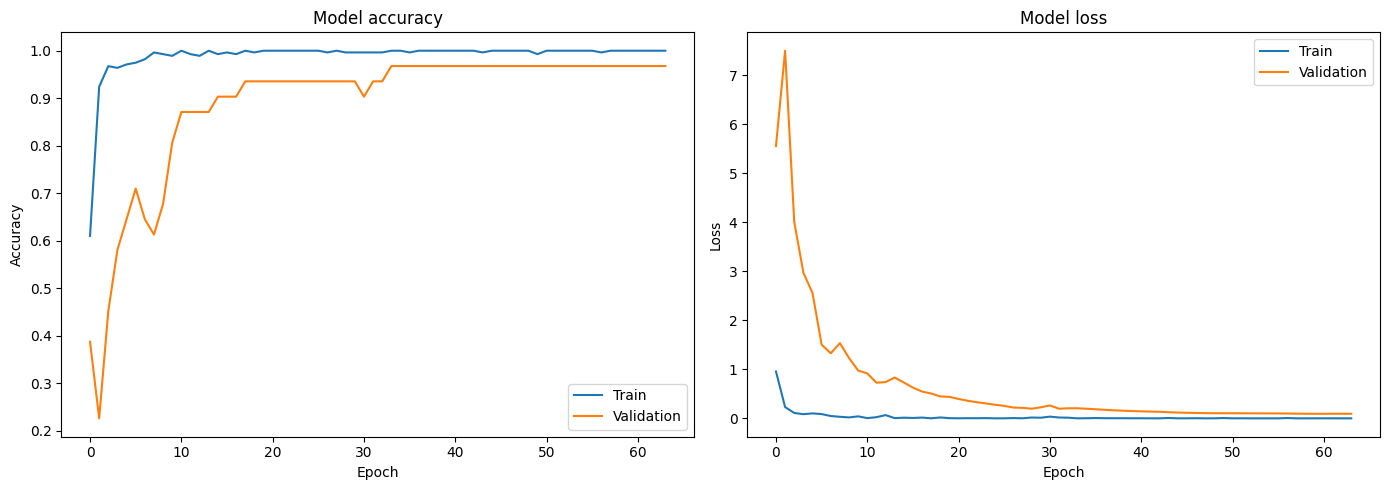

In [ ]:
draw_graphs(history)

3/3 [==============================] - 27s 4s/step
Accuracy: 0.9358974358974359
Precision: 0.9394000335176804
Recall: 0.9358974358974359
F1 Score: 0.9356982359828658
AUC: 0.9894153225806452
Confusion Matrix:
 [[14  1  0  1  0]
 [ 1 15  0  0  0]
 [ 0  1 13  1  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 15]]
Testing Time taken: 27.516552686691284 seconds


AttributeError: 'DataFrame' object has no attribute 'append'

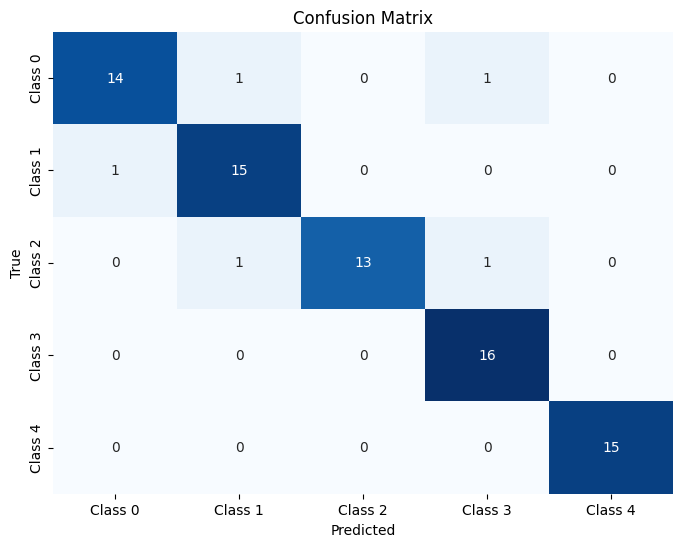

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')


In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimoreresults.csv' successfully.


In [ ]:
visualize_model_architecture(model,filename=save_folder+'Res101-Dense201-ViT.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimoreRes101-Dense201-ViT.png


### Model DenseNet201-MobileNetV3Small-ViT


In [ ]:
model_name="DenseNet201-MobileNetV3Small-ViT"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createCombinedModel3(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

4334752/4334752 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_16[0][0]']            
                                                          4                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_16[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 528.2364344596863 seconds


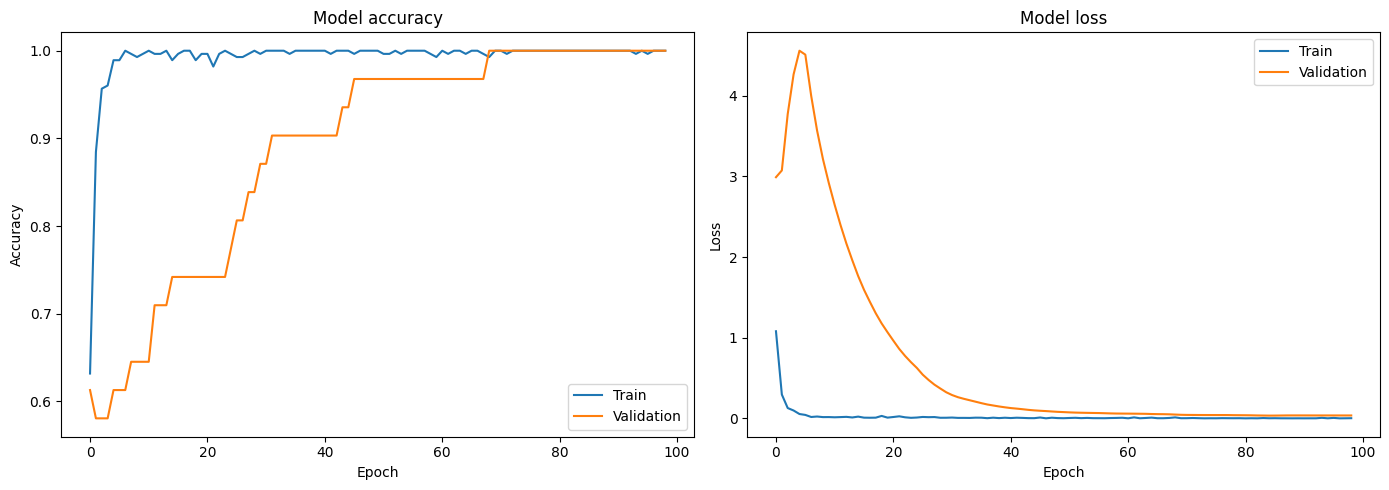

In [ ]:
draw_graphs(history)

3/3 [==============================] - 11s 679ms/step
Accuracy: 0.9358974358974359
Precision: 0.9386930199430201
Recall: 0.9358974358974359
F1 Score: 0.9353222678649624
AUC: 0.9947580645161291
Confusion Matrix:
 [[14  0  0  1  1]
 [ 1 15  0  0  0]
 [ 0  1 13  1  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 15]]
Testing Time taken: 10.71707534790039 seconds


UnboundLocalError: local variable 'headers' referenced before assignment

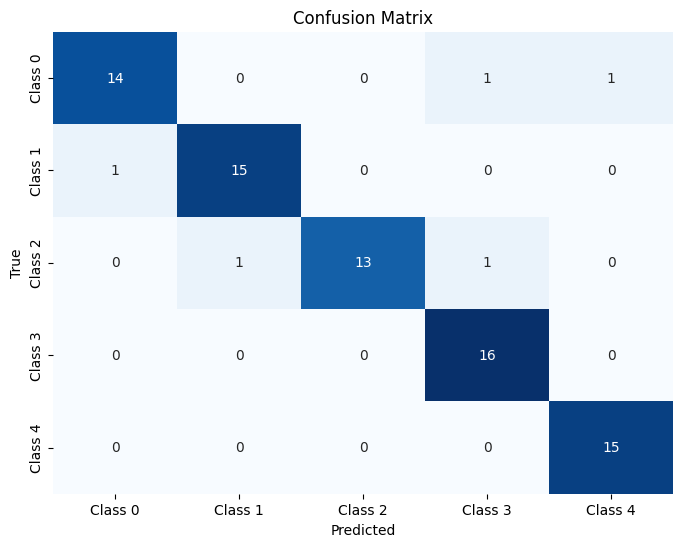

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
visualize_model_architecture(model,filename=save_folder+'res101_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimoreres101_vit_model_architecture.png


In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimoreresults.csv' successfully.


## UIPRMD

In [ ]:
num_classes = 20  # Replace with the actual number of classes in your dataset
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/uiprmd/'
csv_file_path=save_folder+"results.csv"

# Example usage:
Oimagesf, Olabelsf = load_images_and_labels_f('/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/UIPRMD/CWT/Extracted_IMGs')
labelsf = encode_labels(Olabelsf)  # Add your label encoding function
resized_imagesf = resize_images_cv2(Oimagesf)


Loading Images: 100%|██████████| 2001/2001 [01:29<00:00, 22.46it/s]


TypeError: resize_images_cv2() missing 2 required positional arguments: 'wdith' and 'height'

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(resized_imagesf, labelsf, test_size=0.2, validation_size=0.1, random_state=42)

In [ ]:
del Oimagesf, Olabelsf ,resized_imagesf,labelsf#,model

###VGG16 – ViT

In [ ]:
model_name="VGG16"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


58889256/58889256 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_6[0][0]']             
                                                          2                                       
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_6[0][0]']             
                                                          8                                       
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1739.8993411064148 seconds


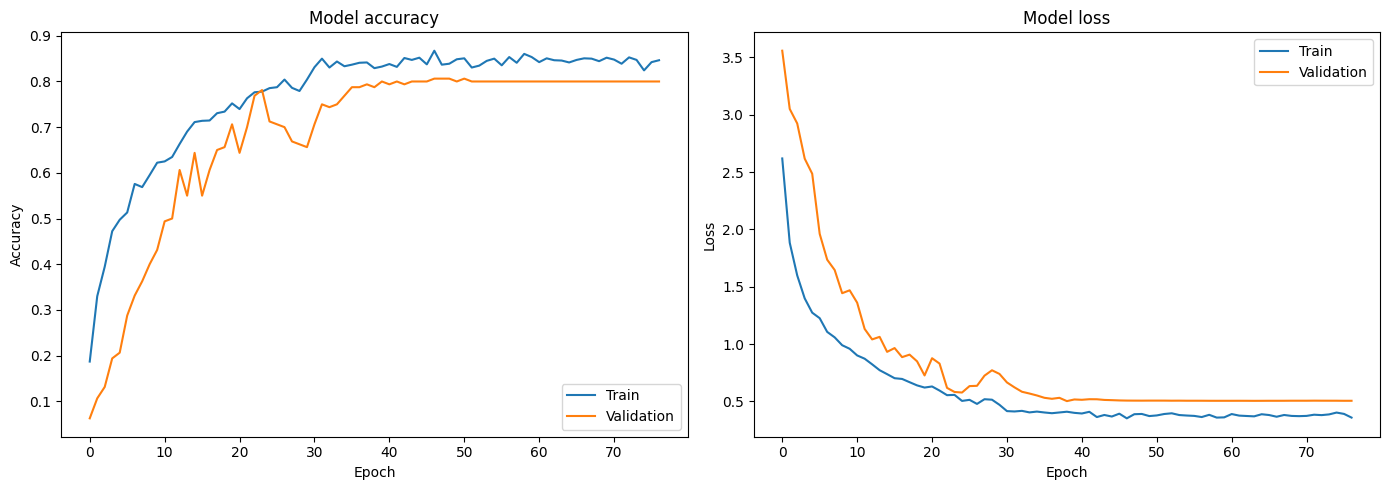

In [ ]:
draw_graphs(history)

13/13 [==============================] - 17s 562ms/step
Accuracy: 0.8425
Precision: 0.8580774128511544
Recall: 0.8425
F1 Score: 0.836193680006804
AUC: 0.993953947368421
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 2  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  1  0  0  0 18  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  2  0  0  0  0  0  0  9  0  0  0  2  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  7  0]
 [ 0  0  0  2  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  7]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  5  0 11  0  0  0  0  0 

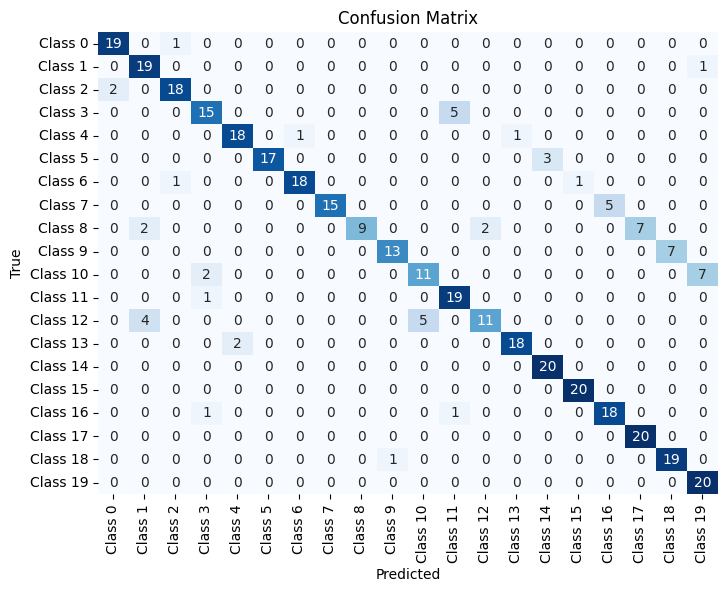

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


In [ ]:
visualize_model_architecture(model,filename=save_folder+'VGG16_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/uiprmd/VGG16_vit_model_architecture.png


###DenseNet121 – ViT

In [ ]:
model_name="DenseNet121"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


29084464/29084464 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_9[0][0]']             
                                                          2                                       
                                                                                                  
 densenet121 (Functional)    (None, 7, 7, 1024)           7037504   ['input_9[0][0]']             
                                                                                                  
 flatten_2 (Flatten)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1419.543499469757 seconds


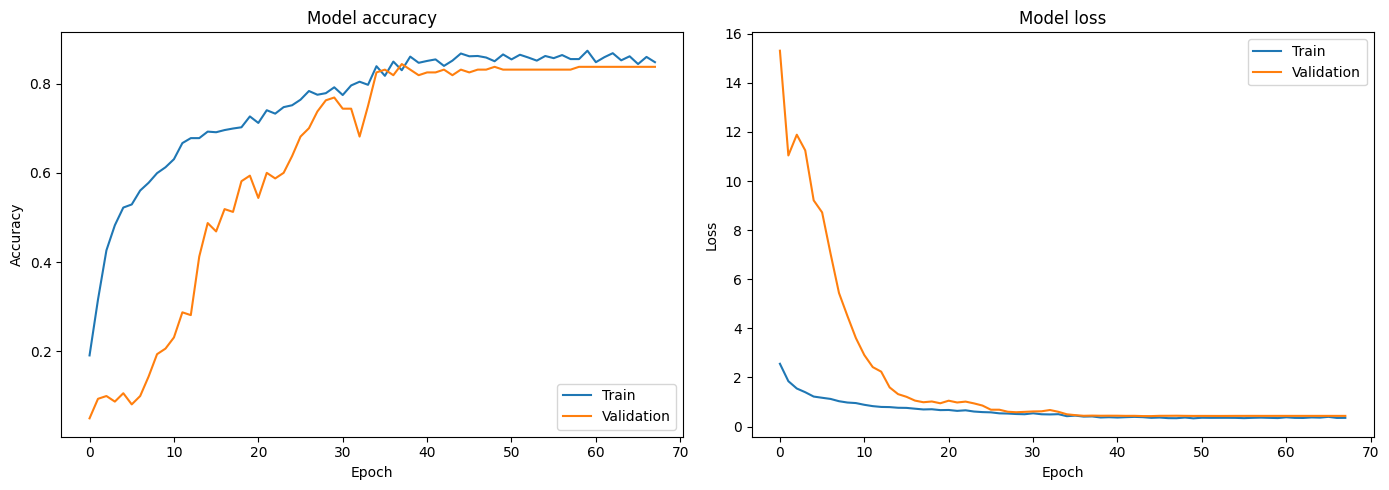

In [ ]:
draw_graphs(history)

13/13 [==============================] - 16s 494ms/step
Accuracy: 0.825
Precision: 0.8333957707370179
Recall: 0.825
F1 Score: 0.8210617328213248
AUC: 0.9929144736842105
Confusion Matrix:
 [[18  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 3  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  3  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  2  0  0  0  0  0  0  0  5  1  0  0  0  0  0]
 [ 0  0  0  0  0 17  1  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  1  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  1  0  1  0  0  0  0 10  1  0  0  3  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  1  0  0  0  0  0  6  0]
 [ 0  0  0  1  0  0  0  0  0  0 15  0  1  0  0  0  0  0  0  3]
 [ 0  0  0  4  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  1  0  0 15  0  0  0  0  1 

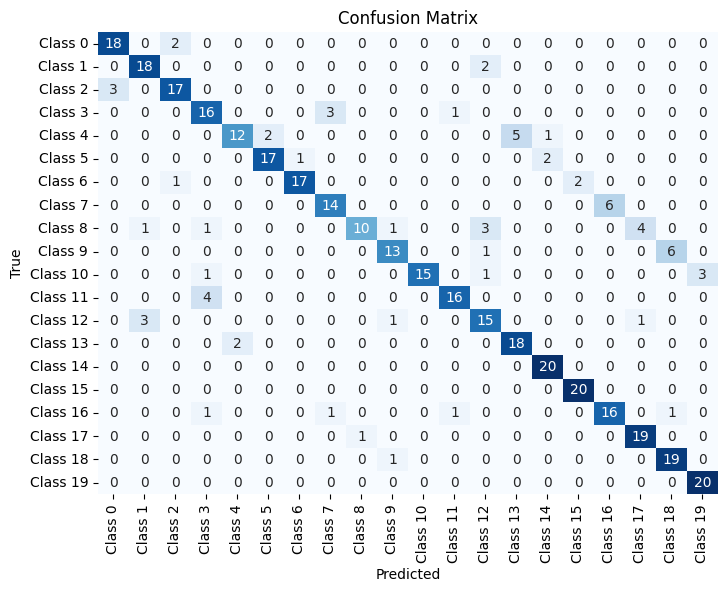

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


In [ ]:
visualize_model_architecture(model,filename=save_folder+'DenseNet121_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/uiprmd/DenseNet121_vit_model_architecture.png


###MobileNetV3Large – ViT

In [ ]:
model_name="MobileNetV3Large"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createTransferViT(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


12683000/12683000 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_12[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_12[0][0]']            
 al)                                                                                              
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1375.7700607776642 seconds


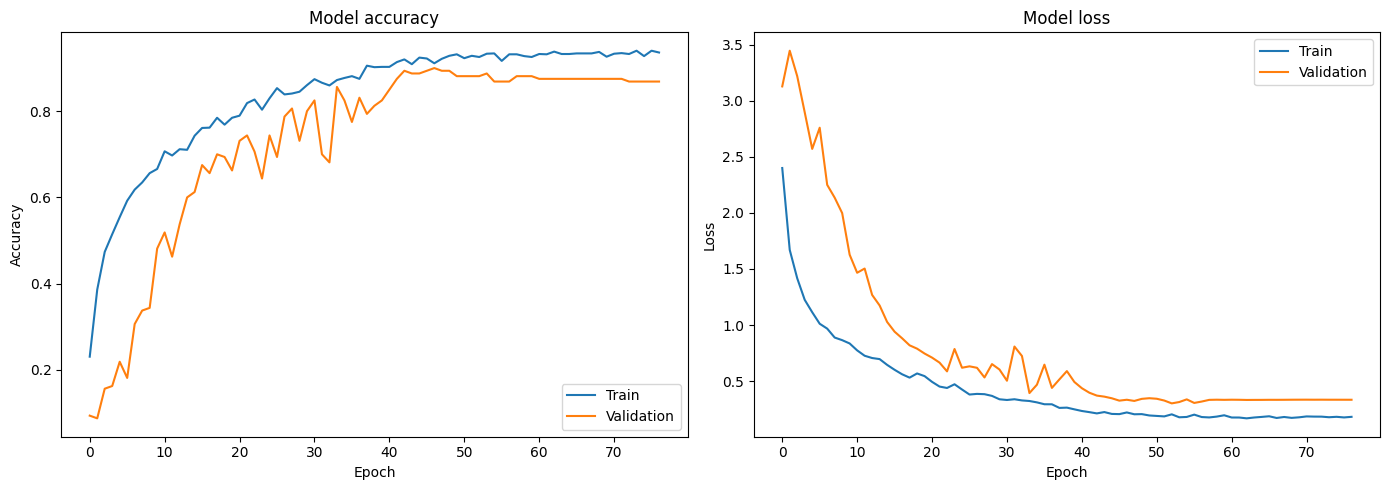

In [ ]:
draw_graphs(history)

13/13 [==============================] - 9s 237ms/step
Accuracy: 0.885
Precision: 0.8911108173246416
Recall: 0.885
F1 Score: 0.8838365619782613
AUC: 0.9960328947368422
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  3  1  0  0  0  0]
 [ 0  0  2  0  0  0 17  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  1  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  1  0  0  0  1  0  0 16  0  1  0  0  0  0  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  1  1  0 14  0  0  0  0  0  

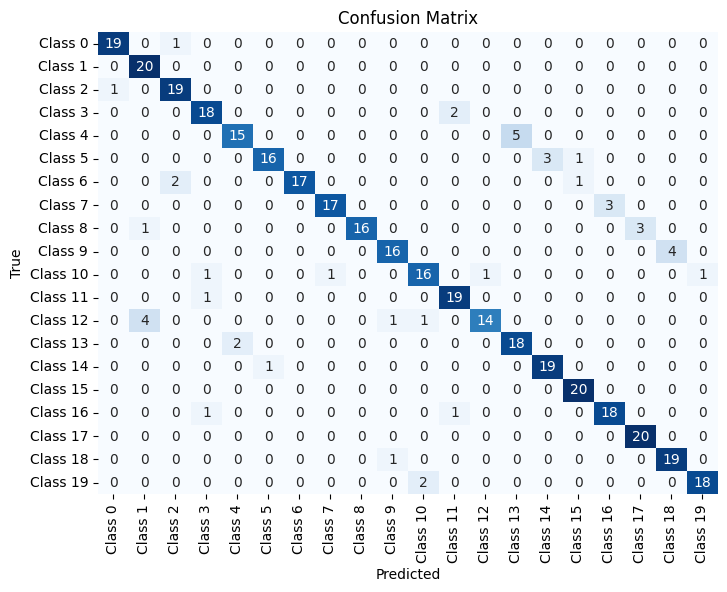

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


In [ ]:
visualize_model_architecture(model,filename=save_folder+'MobileNetV3Large_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/uiprmd/MobileNetV3Large_vit_model_architecture.png


###DenseNet201-MobileNetV3Small-ViT

In [ ]:
model_name="DenseNet201-MobileNetV3Small-ViT"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createCombinedModel3(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_16[0][0]']            
                                                          4                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_16[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1820.41100025177 seconds


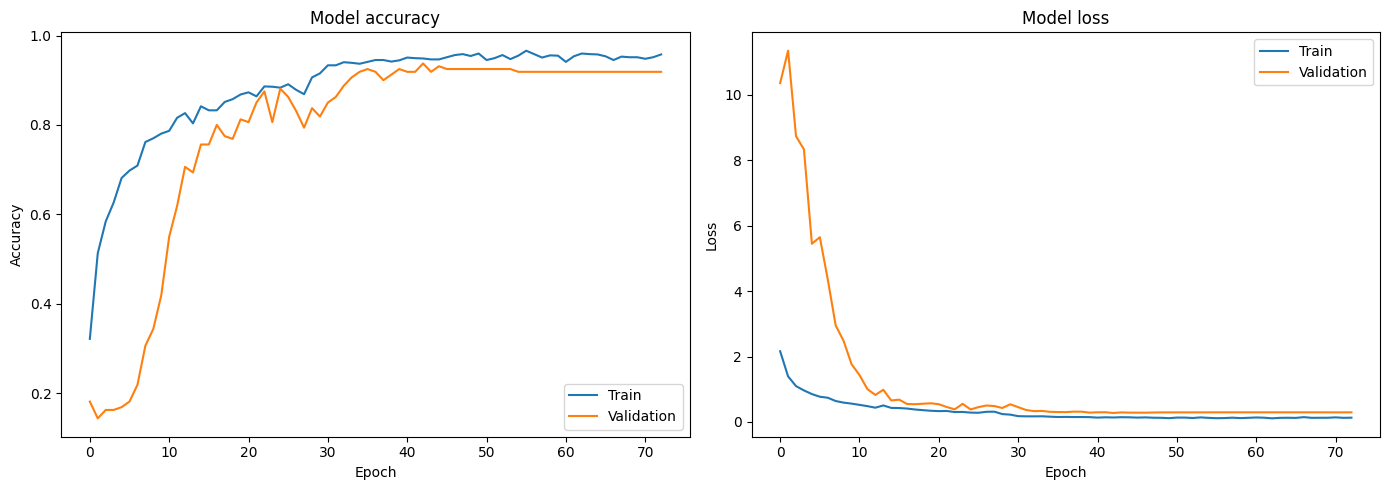

In [ ]:
draw_graphs(history)

13/13 [==============================] - 22s 631ms/step
Accuracy: 0.915
Precision: 0.9196230365109082
Recall: 0.915
F1 Score: 0.9139811366306277
AUC: 0.9980197368421051
Confusion Matrix:
 [[18  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 18  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  1  0  0  0  0  0  0 14  0  0  0  2  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  1 17  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  1  0  0  0  0  0  0 17  0  1  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0 

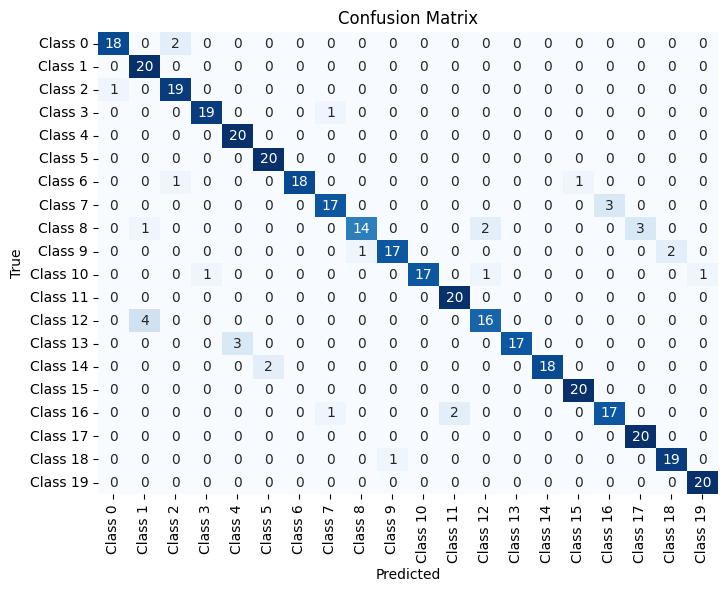

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


In [ ]:
visualize_model_architecture(model,filename=save_folder+'res101_vit_model_architecture.png')

/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/uiprmd/res101_vit_model_architecture.png


###Cross-validation

In [ ]:
del model,history,cf

####UIPRMD

In [ ]:
#we need to add ViT only

In [ ]:
# create top 6 models
model_names=['MobileNetV3Large','Res101-Dense201-ViT']


In [ ]:
class_label_mapping = {
    1: 'Deep Squat',
    2: 'Hurdle Step',
    3: 'Inline Lunge',
    4: 'Side Lunge',
    5: 'Sit to Stand',
    6: 'Standing Leg Raise',
    7: 'Shoulder Abudction',
    8: 'Shoulder Extension',
    9: 'Shoulder Internal-External Rotation',
    10: 'Shoulder Scaption',
    11: 'Incorrect - Deep Squat',
    12: 'Incorrect - Hurdle Step',
    13: 'Incorrect - Inline Lunge',
    14: 'Incorrect - Side Lunge',
    15: 'Incorrect - Sit to Stand',
    16: 'Incorrect - Standing Leg Raise',
    17: 'Incorrect - Shoulder Abudction',
    18: 'Incorrect - Shoulder Extension',
    19: 'Incorrect - Shoulder Internal-External Rotation',
    20: 'Incorrect - Shoulder Scaption'

}
batch_size = 64
num_classes = 20  # Replace with the actual number of classes in your dataset
epochs=150
width=224
height=224
patience=30
img_size=(width, height, 3)
num_folds=5
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/uiprmd/'
csv_file_path=save_folder+"results.csv"
dataset_path='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/UIPRMD/CWT/Extracted_IMGs/'
fold_path='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/UIPRMD/CWT/folds'
save_folder=save_folder+'cv/'
csv_file_path=save_folder+"results_cv.csv"
# create_empty_csv_file(save_folder+"results.csv")

In [ ]:
from sklearn.preprocessing import LabelEncoder

#load data
Oimages, Olabels = load_images_and_labels_f(dataset_path)
# Convert labels from string to numbers
label_encoder = LabelEncoder()
Olabels_numeric = label_encoder.fit_transform(Olabels)


Loading Images: 100%|██████████| 2001/2001 [01:14<00:00, 26.76it/s] 


In [ ]:
Oimages = resize_images_cv2(Oimages,width, height)
Oimages[0].shape

(224, 224, 3)

In [ ]:
load_split_data(1,Oimages, Olabels_numeric,fold_path)

(array([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         ...,
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [255, 255, 255],
          [255, 255, 255],
          [255, 255, 255]],
 
         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
   

In [ ]:
fold_number = 1
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model createCombinedModel3
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 2 : MobileNetV3Large
353253686/353253686 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


12683000/12683000 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_3[0][0]']             
 al)                                                                                              
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 8s 219ms/step
Accuracy: 0.8825
Precision: 0.8965727141233605
Recall: 0.8825
F1 Score: 0.8784762664623664
AUC: 0.9973206385242452
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 17  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  2  0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  1  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 17  0  0  0  1  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  1  0 15  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  1  0  0  0 11  0  0  0  0  1

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_7[0][0]']             
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_7[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 30s 931ms/step
Accuracy: 0.8825
Precision: 0.8891962729536259
Recall: 0.8825
F1 Score: 0.879640836357354
AUC: 0.9965204647999645
Confusion Matrix:
 [[19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 18  0  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  2  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  1  0  0  0  0  0  0  0  3  0  0  1  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  2  0  0  0 15  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  2  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  1 20  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0 17  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0  1  0 12  0  0  0  0  0

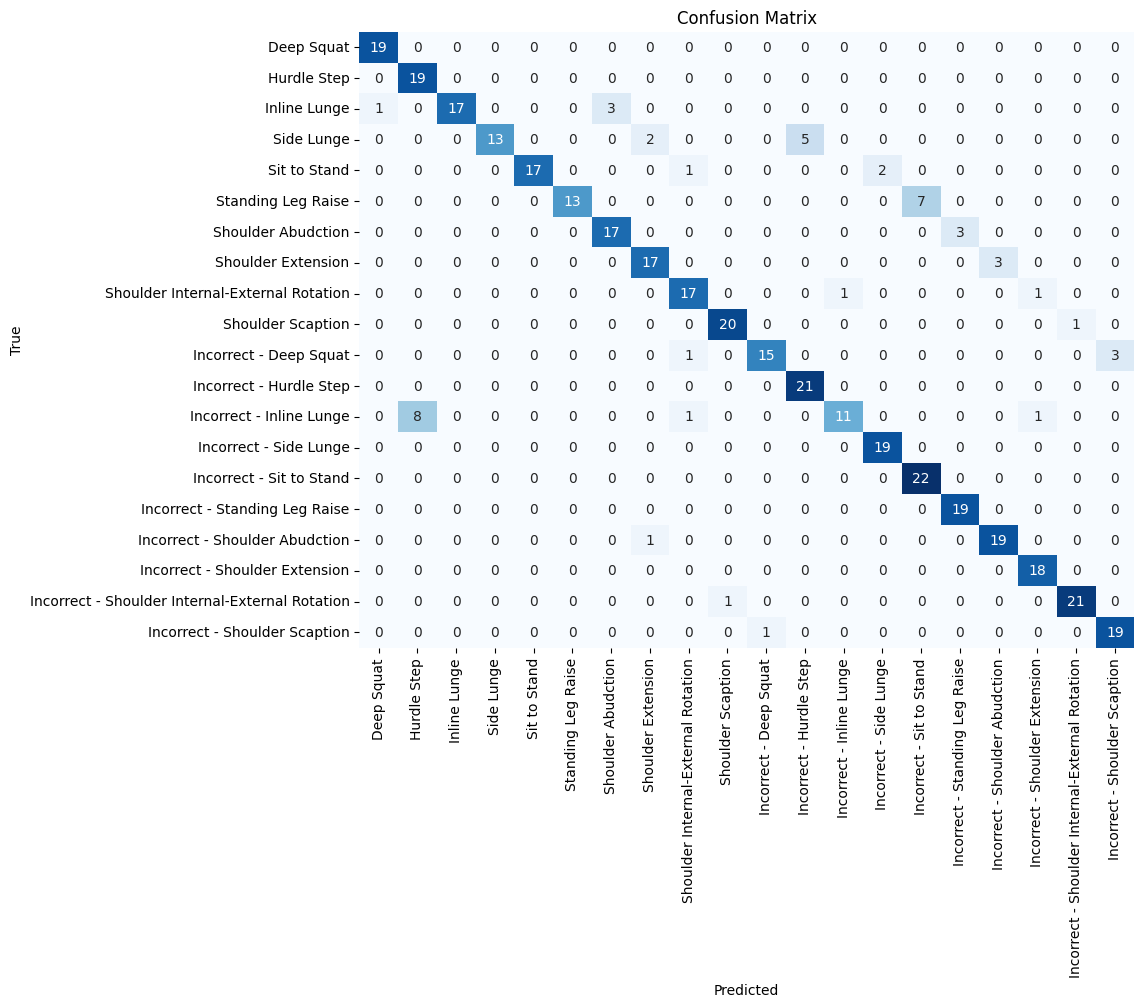

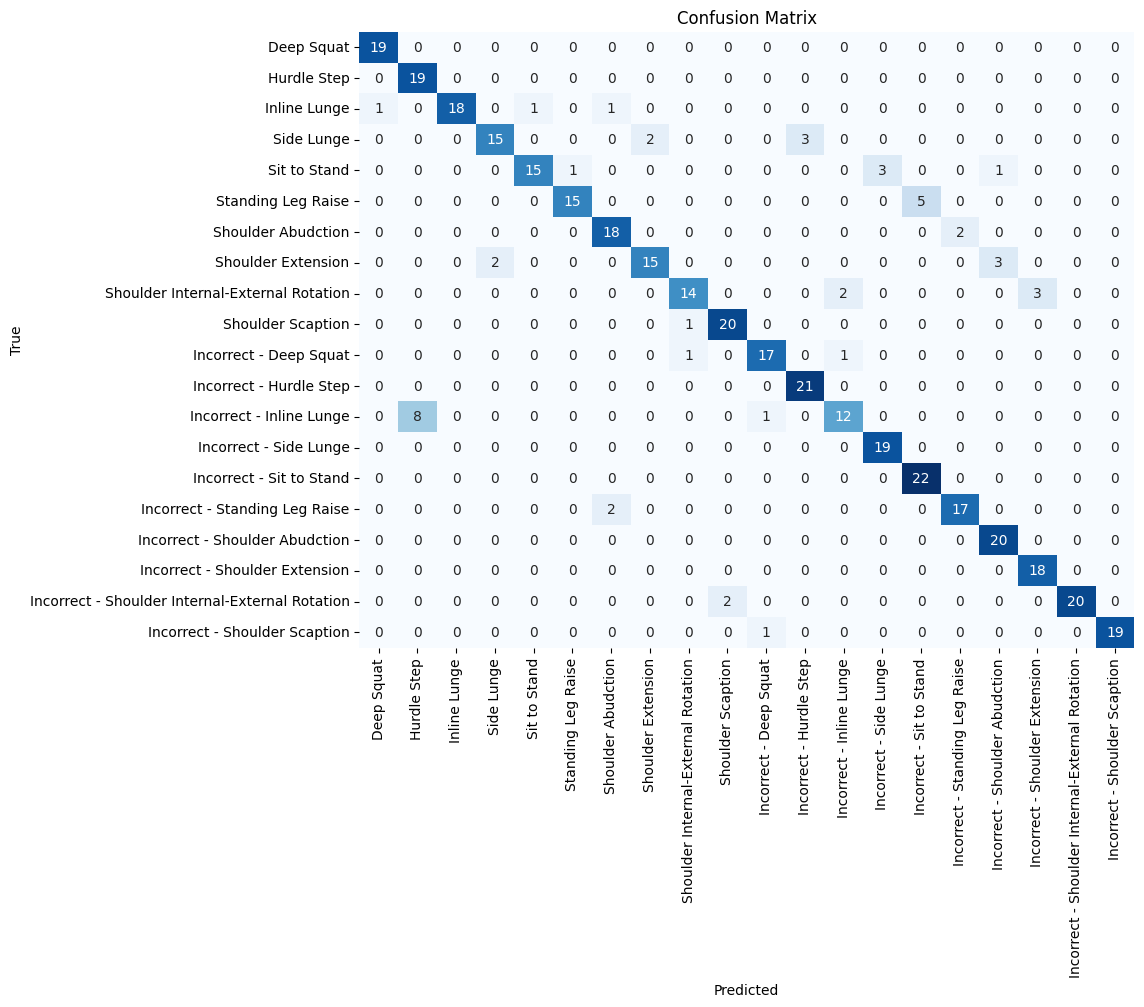

In [ ]:
fold_number = 2
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 2 : MobileNetV3Large
353253686/353253686 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


12683000/12683000 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_3[0][0]']             
 al)                                                                                              
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 8s 244ms/step
Accuracy: 0.855
Precision: 0.8640886963271419
Recall: 0.855
F1 Score: 0.853007303533973
AUC: 0.9951227824406965
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 16  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  1  0  0  0  0  0  0  0  4  1  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  1  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  1  0  0 14  0  0  0  0  0  0  0  0  6]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_7[0][0]']             
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_7[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 32s 967ms/step
Accuracy: 0.885
Precision: 0.8908672670909428
Recall: 0.885
F1 Score: 0.8823874802050661
AUC: 0.9953502934915355
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 16  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  2  0  0  0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  1 12  0  0  0  0  0  0  0  1  5  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0 16  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  1  0  0 16  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  1  0  1  0 13  0  0  0  0  0 

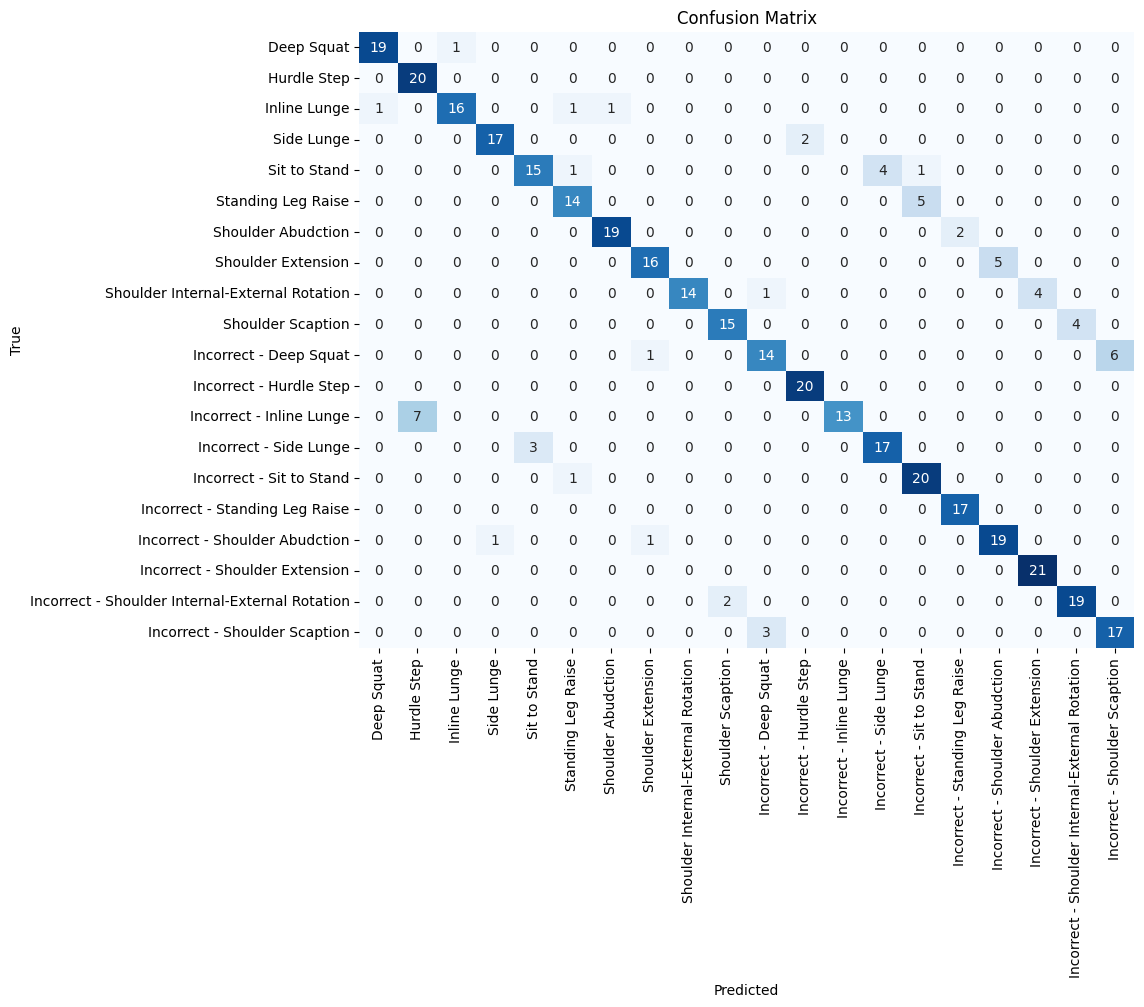

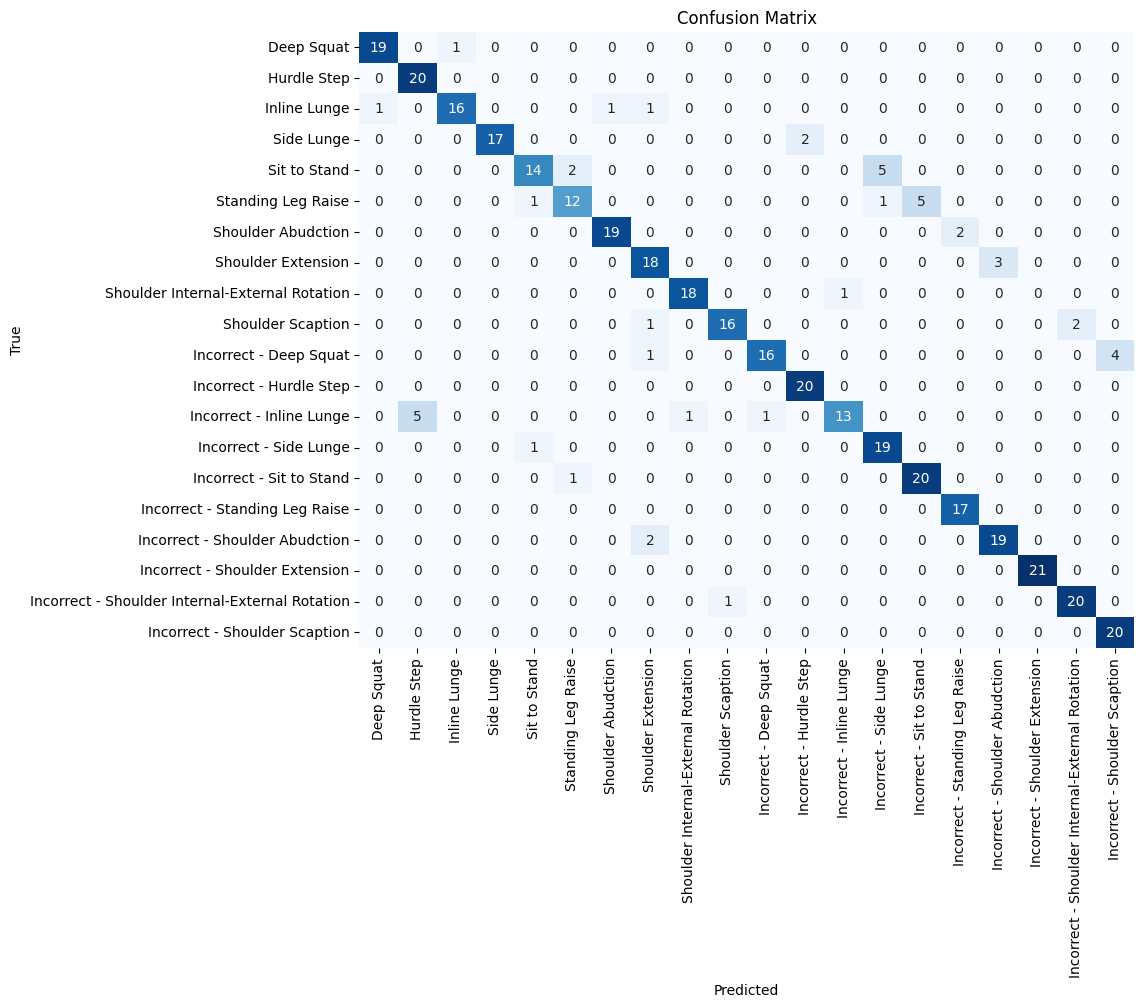

In [ ]:
fold_number = 3
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

In [ ]:
fold_number = 4
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 2 : MobileNetV3Large
353253686/353253686 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


12683000/12683000 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_3[0][0]']             
 al)                                                                                              
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 8s 231ms/step
Accuracy: 0.8825
Precision: 0.8905857700492997
Recall: 0.8825
F1 Score: 0.8792930644154054
AUC: 0.9956138646319367
Confusion Matrix:
 [[21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 19  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  1  0  0  0  0  0  0  1  0  0  0  0  1  0]
 [ 0  0  0  0  1 13  0  0  0  0  0  0  0  0  7  0  0  0  0  0]
 [ 0  0  2  0  0  0 11  0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  0  1  0 17  0  0  1  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  1  0 17  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  1  0  0  0 15  0  0  0  0  0

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_7[0][0]']             
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_7[0][0]']             
                                                          6                                       
                                                                                     

Processing Model 1 of 2 : MobileNetV3Large
353253686/353253686 [==============================] - 3s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


12683000/12683000 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3large (Function  (None, 7, 7, 960)            2996352   ['input_3[0][0]']             
 al)                                                                                              
                    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 9s 238ms/step
Accuracy: 0.8725
Precision: 0.8750410065211855
Recall: 0.8725
F1 Score: 0.87073389821229
AUC: 0.9966481050808103
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0  4  1  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  3  1  0  0  0  0]
 [ 1  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  1 15  0  1  0  1  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  1 15  0  0  1  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  3  0  0  0  0  0  0  4]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  1  0 16  0  0  0  0  0  

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_7[0][0]']             
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_7[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 32s 934ms/step
Accuracy: 0.92
Precision: 0.9207686791501152
Recall: 0.92
F1 Score: 0.9191895997764135
AUC: 0.9983327413346172
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 1  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  2  0 14  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  2  1  0  0  0  0]
 [ 0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 17  1  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  1  0 16  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  1  0 18  0  0  0  0  0  0

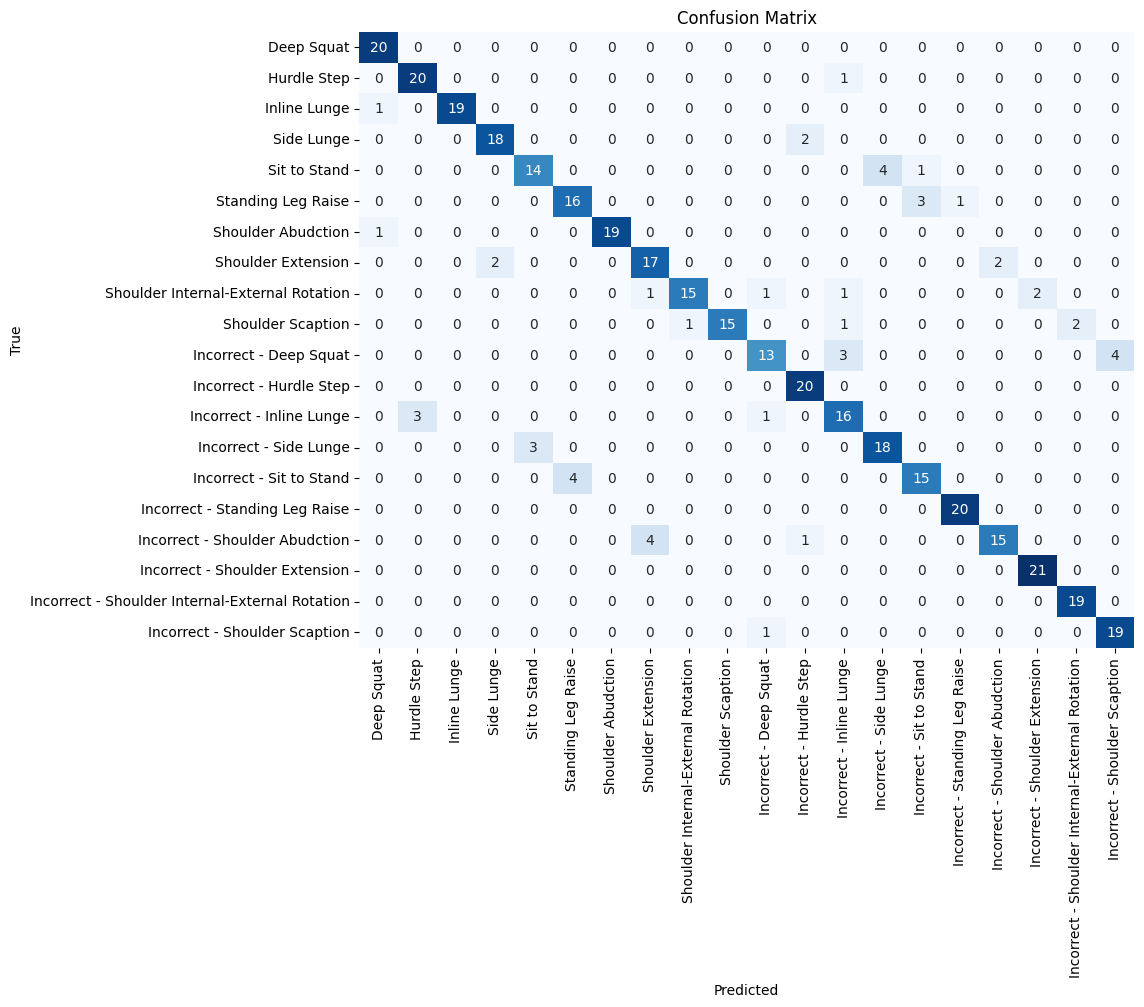

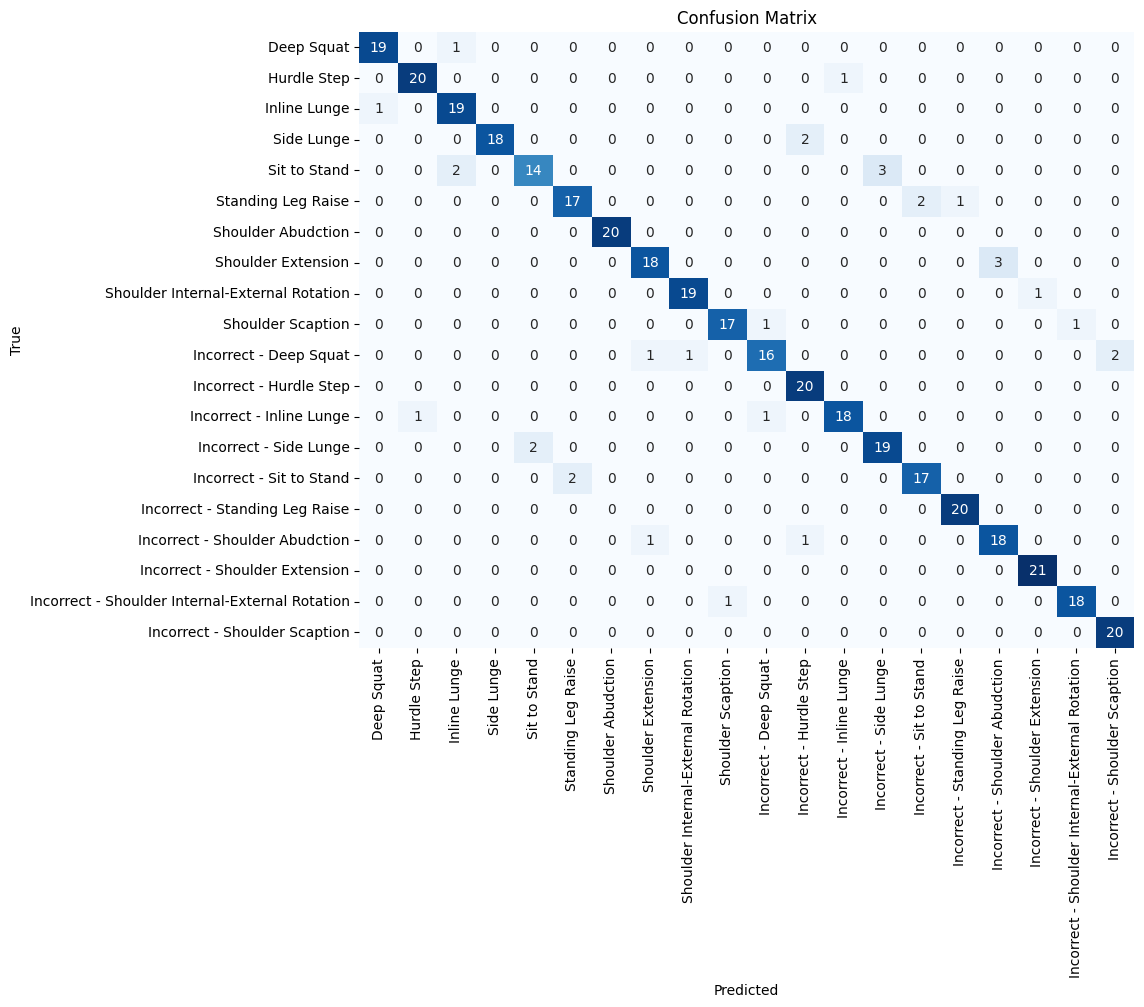

In [ ]:
fold_number = 5
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 1 : Res101-Dense201-ViT
353253686/353253686 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_4[0][0]']             
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_4[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


13/13 [==============================] - 33s 996ms/step
Accuracy: 0.9125
Precision: 0.9179977249263577
Recall: 0.9125
F1 Score: 0.9108256951829695
AUC: 0.9952581061382189
Confusion Matrix:
 [[20  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0  0  0  0  2  0  0  0  0  1  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  1  0  0  0 12  0  0  0  0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  1  0  0  0 14  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0  2  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0 16  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  2  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  1  0  0 18  0  0  0  0  

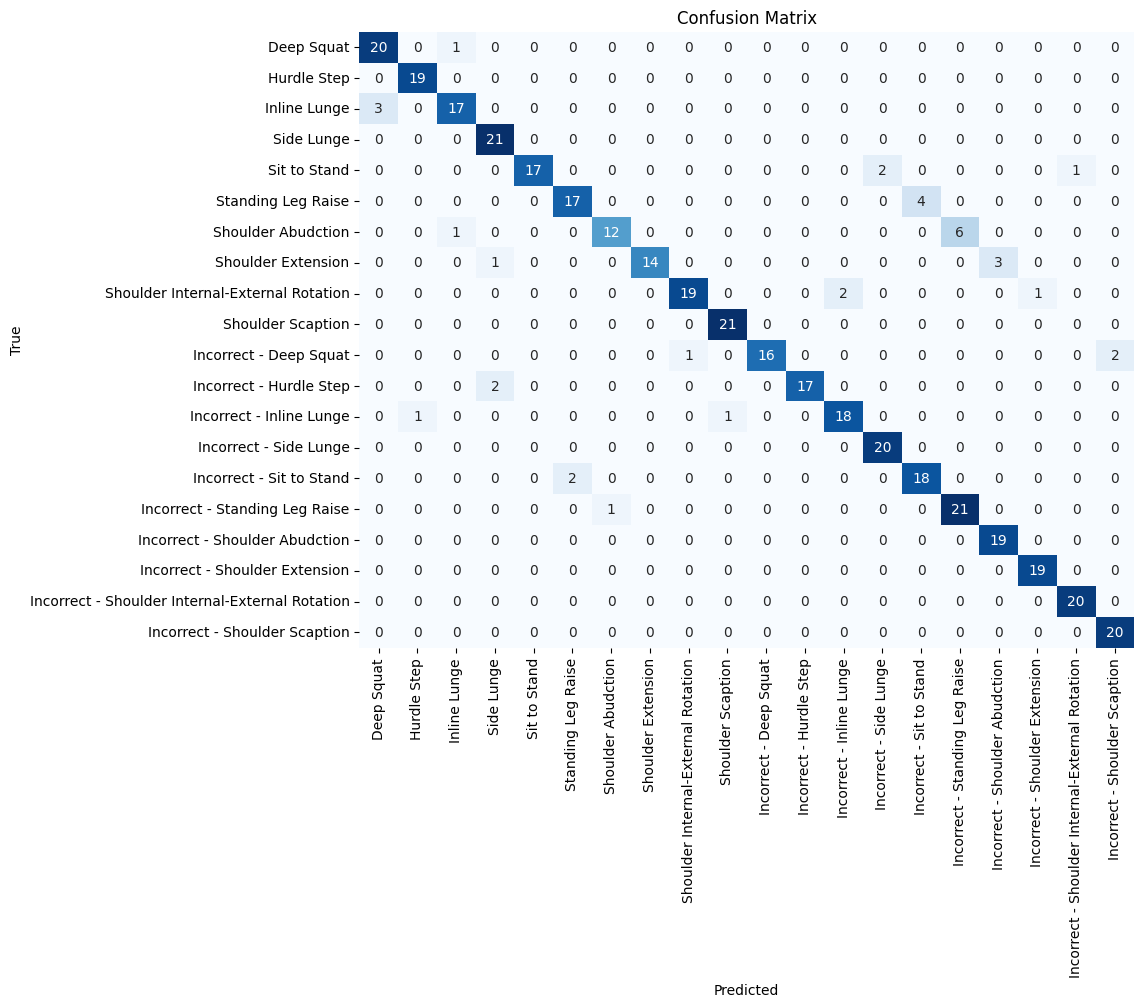

In [ ]:
model_names=['Res101-Dense201-ViT']
fold_number = 4
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

#### Kimore

In [ ]:
class_label_mapping = {
    1: 'Lifting of the arms',
    2: 'Lateral tilt of the trunk with the arms in extension',
    3: 'Trunk rotation',
    4: 'Pelvis rotations on the transverse plane',
    5: 'Squatting'
}
batch_size = 64
num_classes = 5  # Replace with the actual number of classes in your dataset
epochs=150
width=224
height=224
patience=30
img_size=(width, height, 3)
num_folds=5
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/'
csv_file_path=save_folder+"results.csv"
dataset_path='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/KIMORE/images_extracted'
fold_path='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Dataset/KIMORE/folds'
save_folder=save_folder+'cv/'
csv_file_path=save_folder+"results_cv.csv"
# create_empty_csv_file(save_folder+"results.csv")

In [ ]:
# epochs=1

In [ ]:
from sklearn.preprocessing import LabelEncoder

#load data
Oimages, Olabels = load_images_and_labels_f(dataset_path)
# Convert labels from string to numbers
label_encoder = LabelEncoder()
Olabels_numeric = label_encoder.fit_transform(Olabels)


Loading Images: 100%|██████████| 386/386 [00:06<00:00, 58.38it/s]


In [ ]:
Oimages = resize_images_cv2(Oimages,width, height)
Oimages[0].shape

(224, 224, 3)

In [ ]:
load_split_data(1,Oimages, Olabels_numeric,fold_path)

(array([[[[127,   0,   0],
          [127,   0,   0],
          [127,   0,   0],
          ...,
          [129,   0,   0],
          [128,   0,   0],
          [128,   0,   0]],
 
         [[132,   0,   0],
          [132,   0,   0],
          [132,   0,   0],
          ...,
          [141,   0,   0],
          [136,   0,   0],
          [136,   0,   0]],
 
         [[132,   0,   0],
          [133,   0,   0],
          [133,   0,   0],
          ...,
          [156,   0,   0],
          [150,   0,   0],
          [146,   0,   0]],
 
         ...,
 
         [[157, 255,  88],
          [139, 255, 106],
          [115, 255, 130],
          ...,
          [ 80, 255, 165],
          [ 55, 255, 190],
          [ 39, 255, 207]],
 
         [[176, 255,  69],
          [142, 255, 103],
          [ 89, 255, 157],
          ...,
          [ 86, 255, 160],
          [ 40, 255, 205],
          [ 15, 255, 231]],
 
         [[189, 255,  57],
          [143, 255, 102],
          [ 73, 255, 173],
   

#####den201mobvit

In [ ]:
model_names=['DenseNet201-MobileNetV3Small-ViT']

Processing Model 1 of 1 : DenseNet201-MobileNetV3Small-ViT
353253686/353253686 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_4[0][0]']             
                                                          4                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_4[0][0]']             
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 22s 3s/step
Accuracy: 0.9487179487179487
Precision: 0.9527207332637198
Recall: 0.9487179487179487
F1 Score: 0.948879833868491
AUC: 0.9985961955483645
Confusion Matrix:
 [[12  0  0  0  0]
 [ 1 15  0  0  0]
 [ 0  1 18  1  0]
 [ 0  0  0 15  0]
 [ 0  0  0  1 14]]
Testing Time taken: 27.561748266220093 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


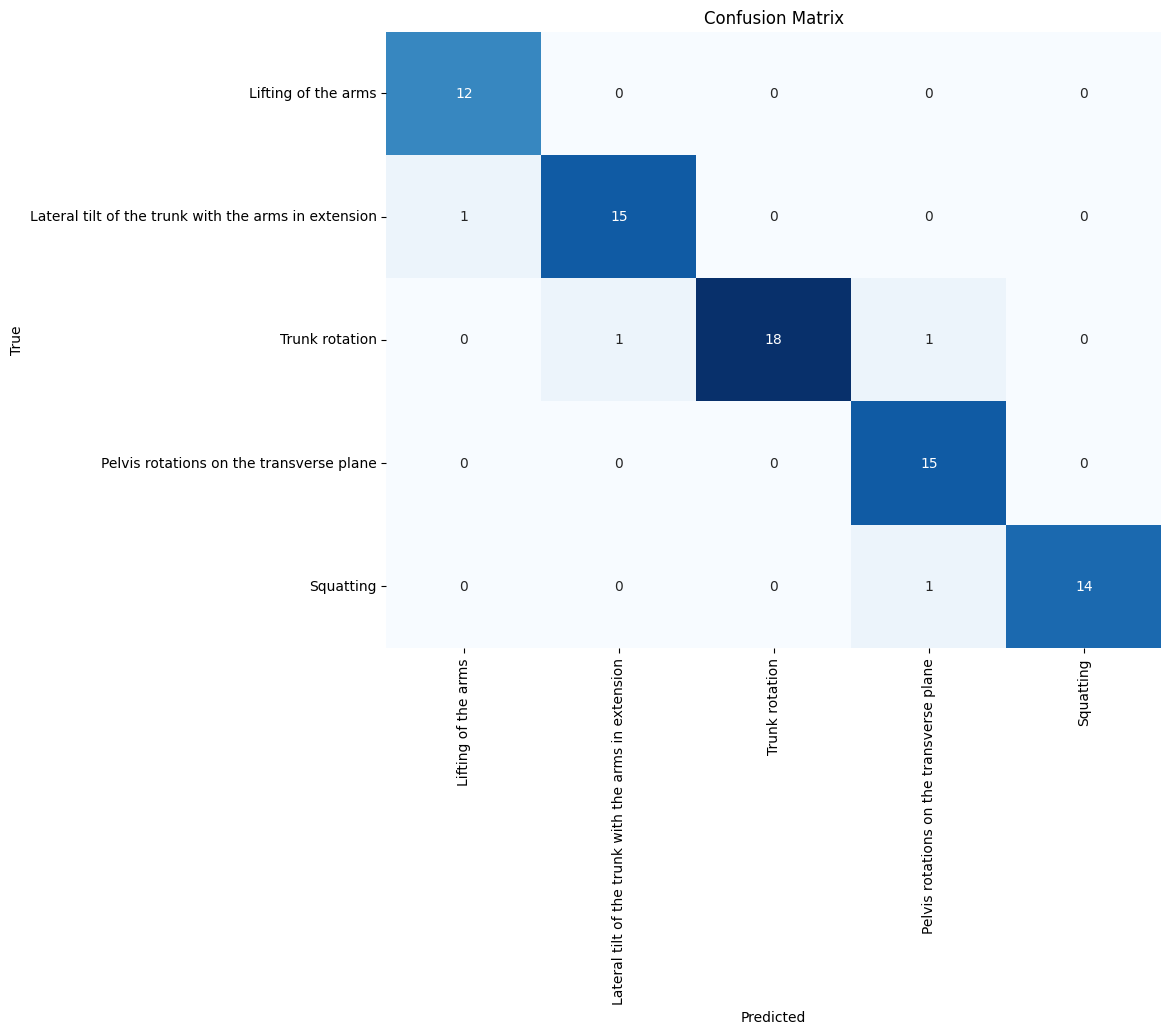

In [ ]:
fold_number = 1
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model createCombinedModel3
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 1 : DenseNet201-MobileNetV3Small-ViT


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_8[0][0]']             
                                                          4                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_8[0][0]']             
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 14s 3s/step
Accuracy: 0.961038961038961
Precision: 0.9627911770768913
Recall: 0.961038961038961
F1 Score: 0.9608525965668824
AUC: 0.9962567433116847
Confusion Matrix:
 [[10  0  0  0  1]
 [ 0 19  0  0  0]
 [ 0  0 11  0  0]
 [ 0  0  0 17  0]
 [ 0  2  0  0 17]]
Testing Time taken: 14.312057971954346 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


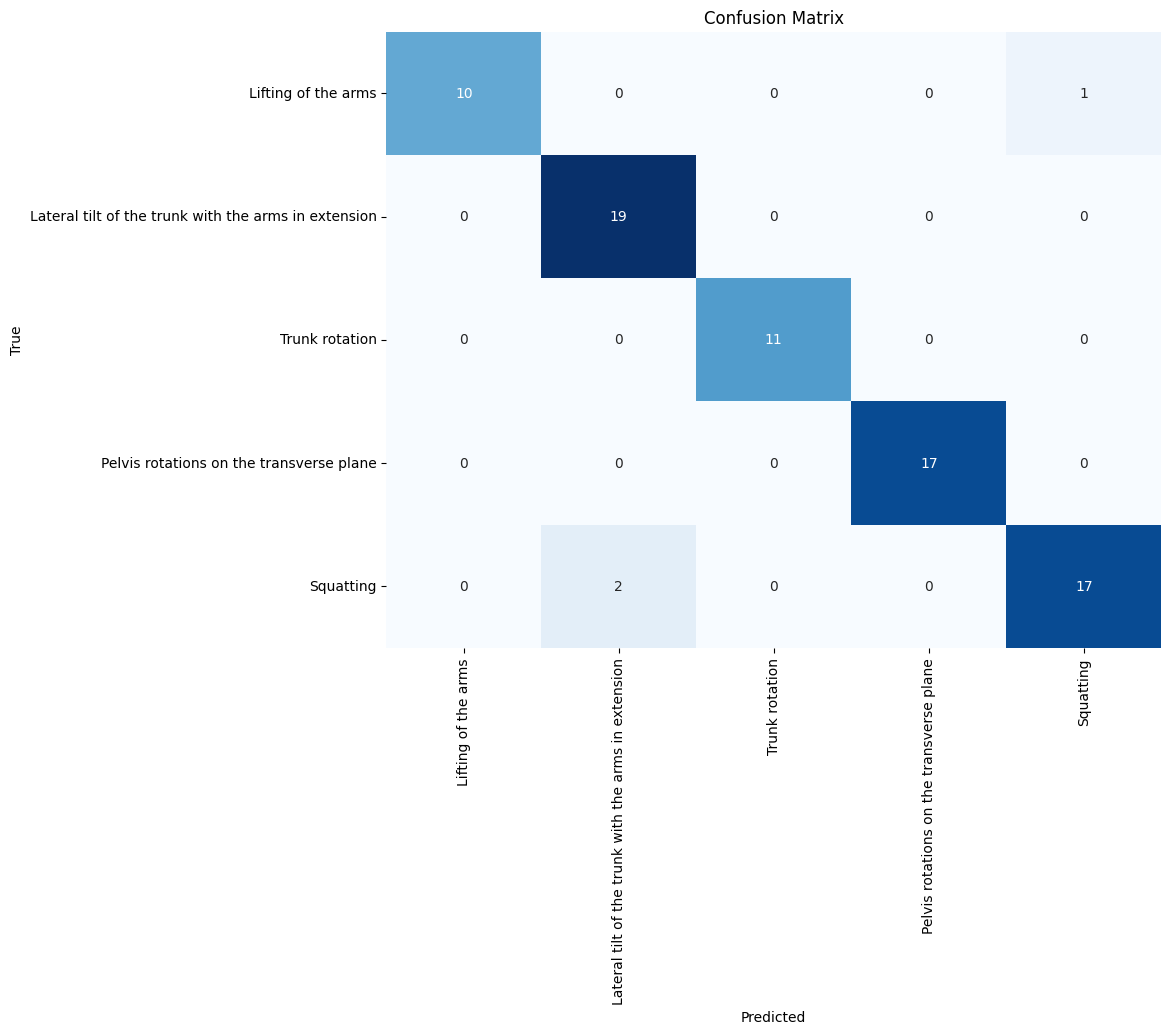

In [ ]:
fold_number = 2
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 1 : DenseNet201-MobileNetV3Small-ViT


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_12[0][0]']            
                                                          4                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_12[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 8s 207ms/step
Accuracy: 0.961038961038961
Precision: 0.9608946608946609
Recall: 0.961038961038961
F1 Score: 0.9605960859417082
AUC: 0.9956155576984893
Confusion Matrix:
 [[14  0  0  1  1]
 [ 0 15  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0 17  0]
 [ 1  0  0  0 16]]
Testing Time taken: 8.49398684501648 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


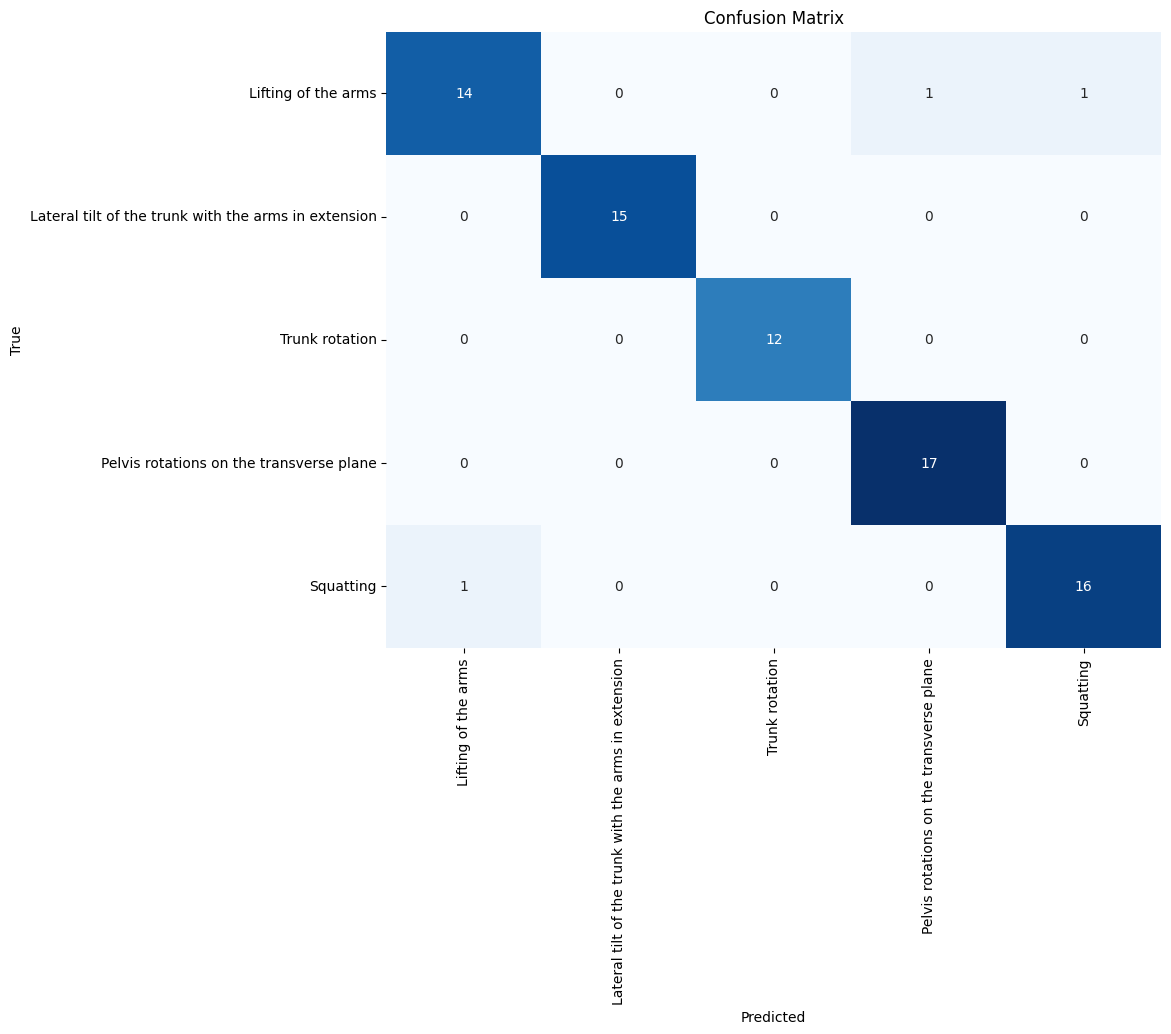

In [ ]:
fold_number = 3
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 1 : DenseNet201-MobileNetV3Small-ViT


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_16[0][0]']            
                                                          4                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_16[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 8s 237ms/step
Accuracy: 0.9090909090909091
Precision: 0.9109760331564841
Recall: 0.9090909090909091
F1 Score: 0.9070386994810958
AUC: 0.993389894419306
Confusion Matrix:
 [[13  1  2  0  1]
 [ 1 11  1  0  0]
 [ 0  0 16  1  0]
 [ 0  0  0 13  0]
 [ 0  0  0  0 17]]
Testing Time taken: 7.975914716720581 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


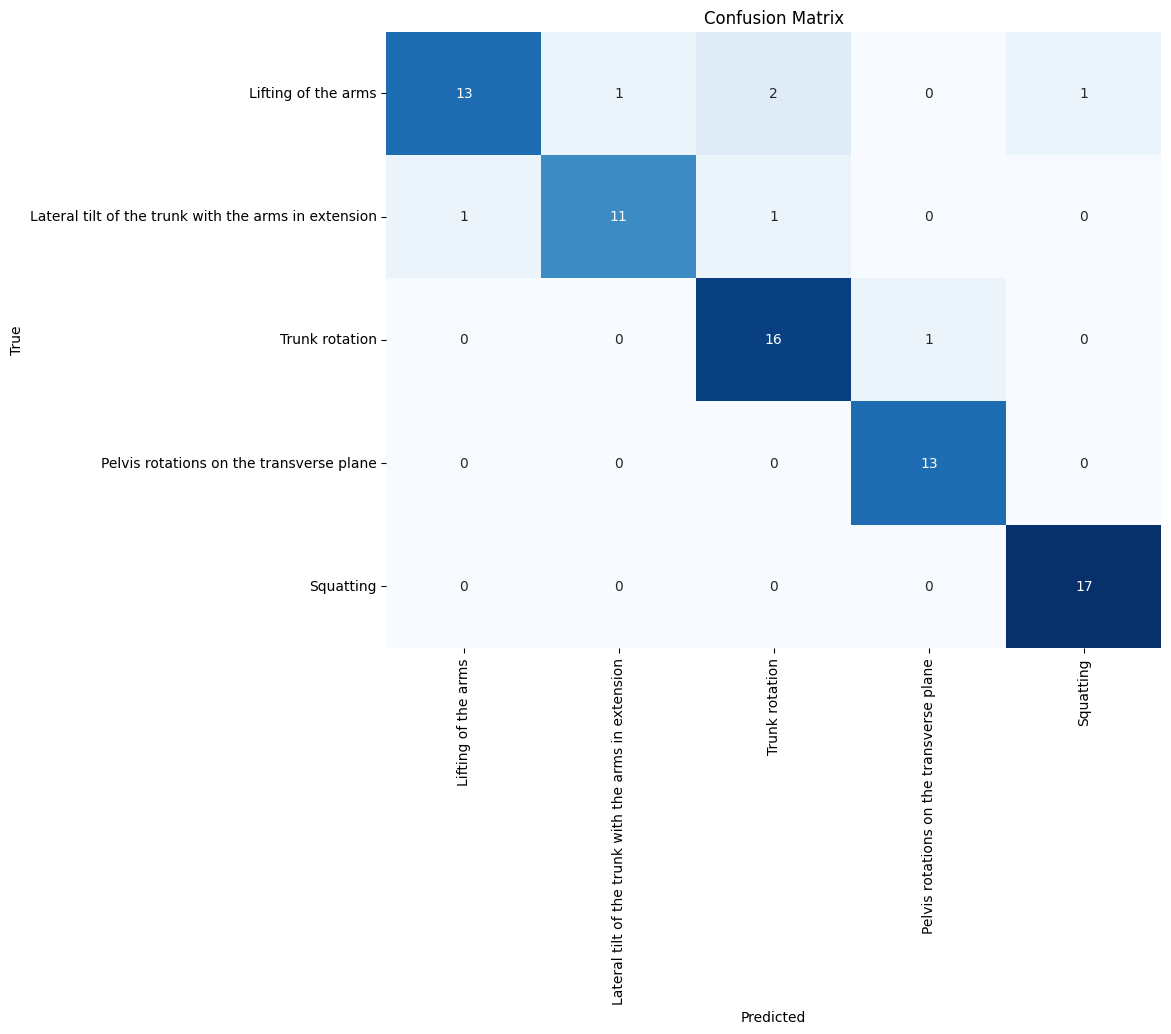

In [ ]:
fold_number = 4
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 1 : DenseNet201-MobileNetV3Small-ViT


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_20 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_20[0][0]']            
                                                          4                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_20[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 9s 210ms/step
Accuracy: 0.935064935064935
Precision: 0.9409090909090909
Recall: 0.935064935064935
F1 Score: 0.9346292104912794
AUC: 0.9880827899642142
Confusion Matrix:
 [[20  0  0  1  0]
 [ 1 13  1  1  0]
 [ 0  0 14  1  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  8]]
Testing Time taken: 9.611149311065674 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


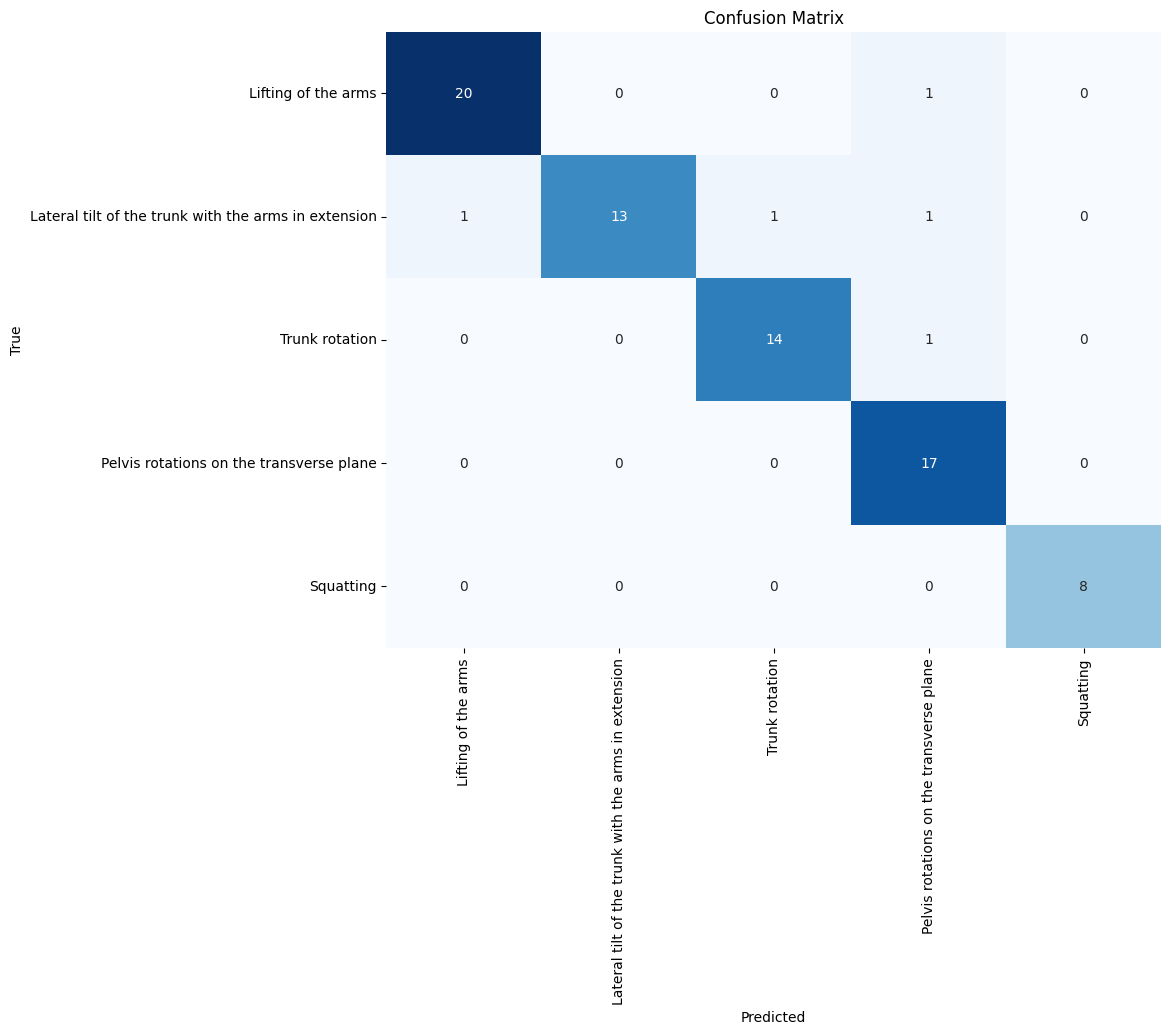

In [ ]:
fold_number = 5
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

#####Rest

In [ ]:
model_names=['MobileNetV3Small','Res101-Dense201-ViT']

Processing Model 1 of 2 : MobileNetV3Small
353253686/353253686 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


4334752/4334752 [==============================] - 0s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_3[0][0]']             
 al)                                                                                              
                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 6s 587ms/step
Accuracy: 0.9615384615384616
Precision: 0.9653092006033183
Recall: 0.9615384615384616
F1 Score: 0.9615805231508893
AUC: 0.9990286204649387
Confusion Matrix:
 [[11  0  0  1  0]
 [ 0 16  0  0  0]
 [ 0  1 18  1  0]
 [ 0  0  0 15  0]
 [ 0  0  0  0 15]]
Testing Time taken: 6.0263450145721436 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 2 : Res101-Dense201-ViT
171446536/171446536 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_7[0][0]']             
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_7[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 26s 4s/step
Accuracy: 0.9487179487179487
Precision: 0.9572115384615384
Recall: 0.9487179487179487
F1 Score: 0.9498213735913743
AUC: 0.9975297328119908
Confusion Matrix:
 [[12  0  0  0  0]
 [ 2 14  0  0  0]
 [ 1  0 19  0  0]
 [ 0  0  0 15  0]
 [ 0  0  0  1 14]]
Testing Time taken: 26.33632493019104 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


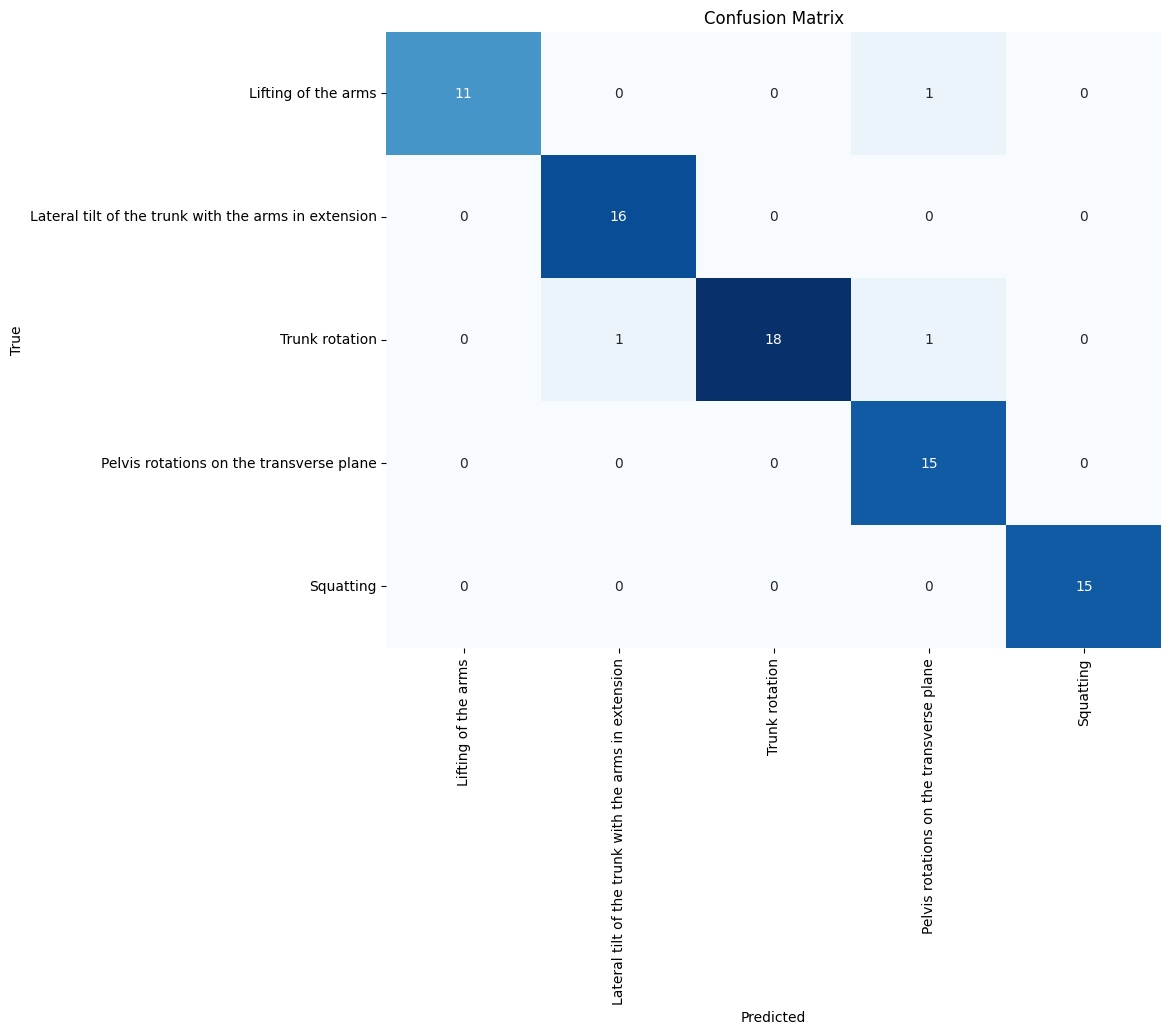

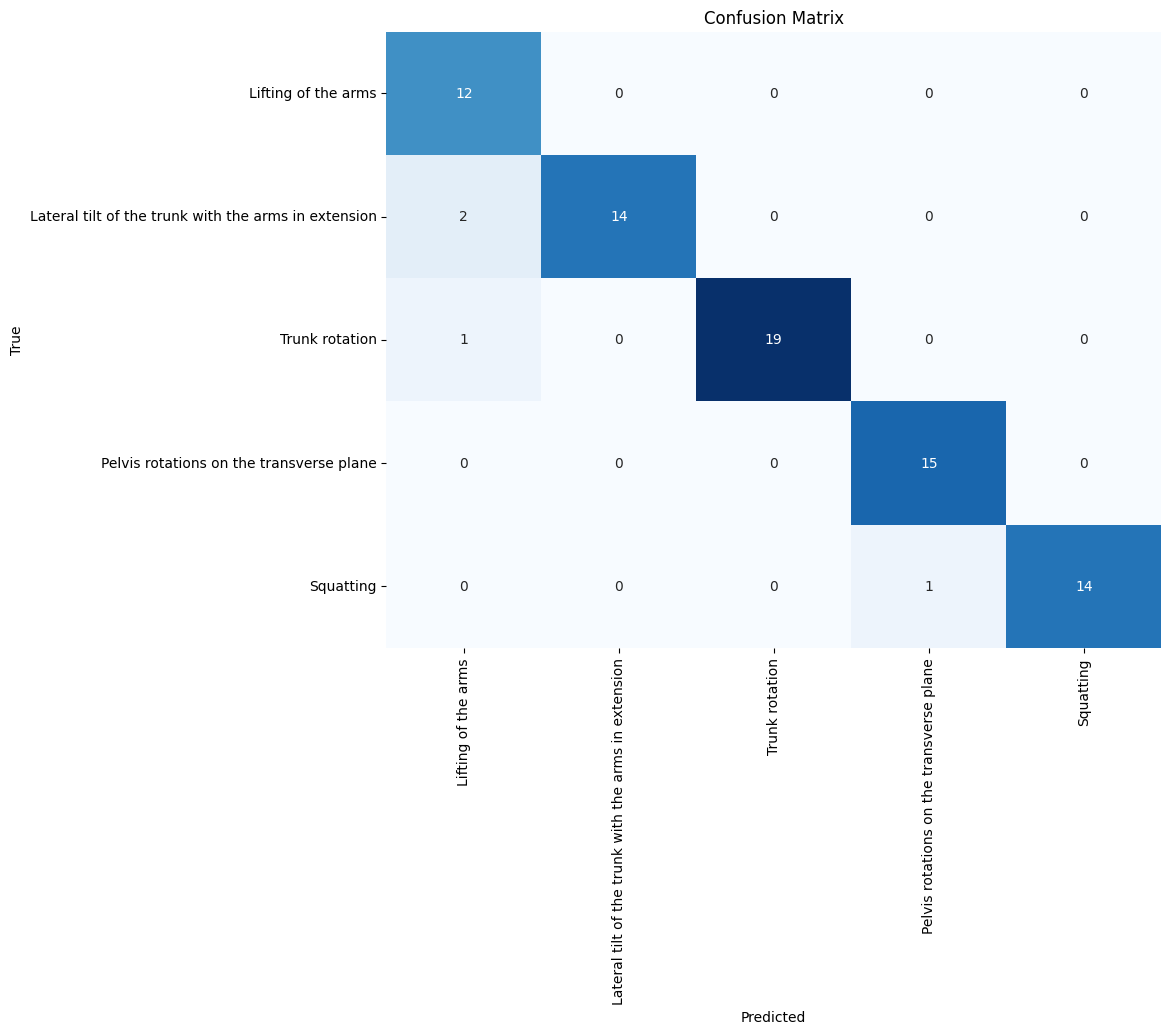

In [ ]:
fold_number = 1
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model createCombinedModel3
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 2 : MobileNetV3Small


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_10[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_10[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 5s 552ms/step
Accuracy: 0.961038961038961
Precision: 0.9645949288806431
Recall: 0.961038961038961
F1 Score: 0.960939922741165
AUC: 0.9973456725312854
Confusion Matrix:
 [[10  1  0  0  0]
 [ 0 19  0  0  0]
 [ 0  0 11  0  0]
 [ 0  0  0 17  0]
 [ 0  1  1  0 17]]
Testing Time taken: 5.933009147644043 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 2 : Res101-Dense201-ViT


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_14[0][0]']            
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_14[0][0]']            
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 17s 4s/step
Accuracy: 0.935064935064935
Precision: 0.9378994021851164
Recall: 0.935064935064935
F1 Score: 0.9341714102583669
AUC: 0.9943283686560374
Confusion Matrix:
 [[ 9  1  0  0  1]
 [ 0 19  0  0  0]
 [ 0  0 11  0  0]
 [ 0  1  0 16  0]
 [ 0  0  1  1 17]]
Testing Time taken: 18.863881826400757 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


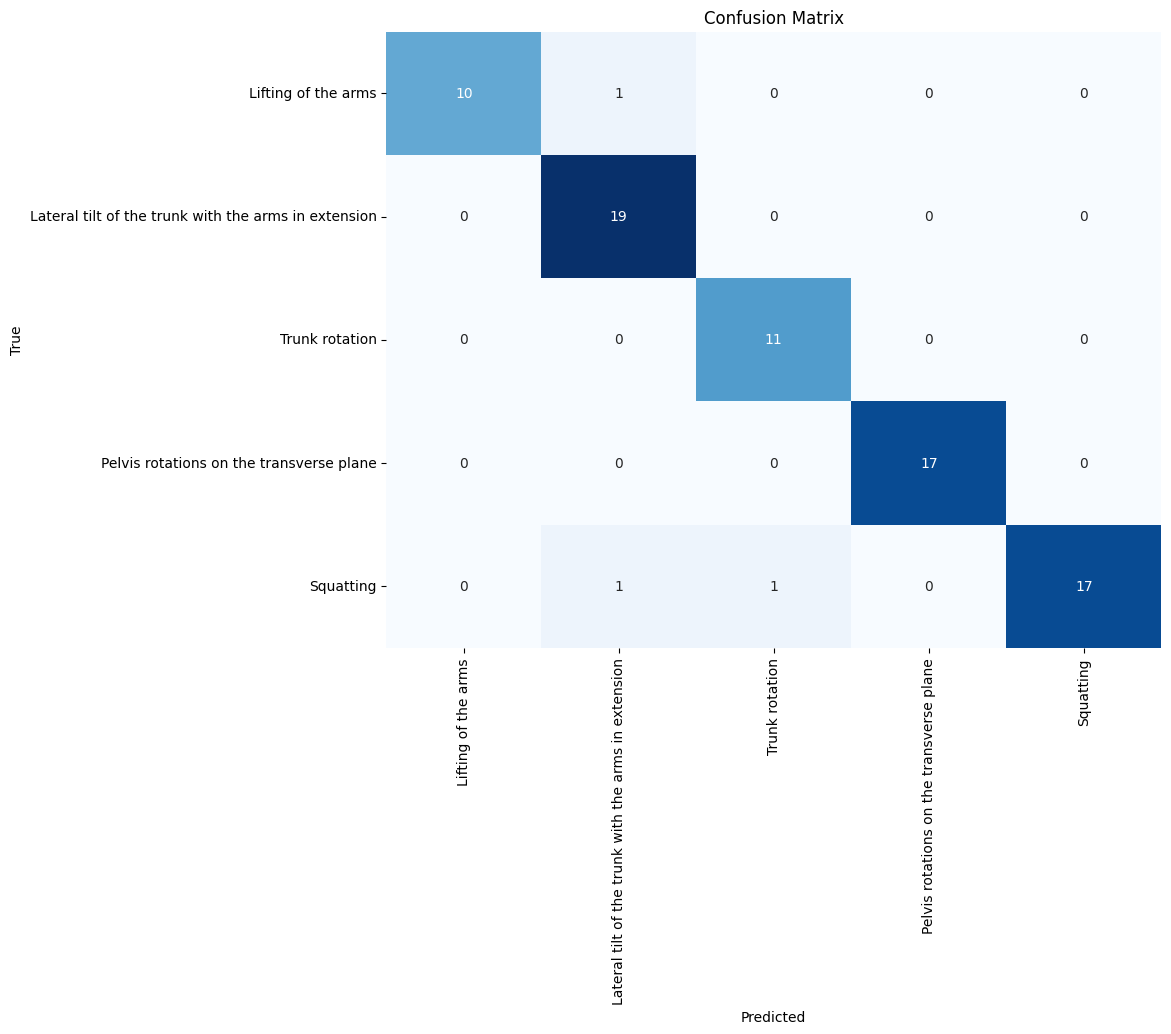

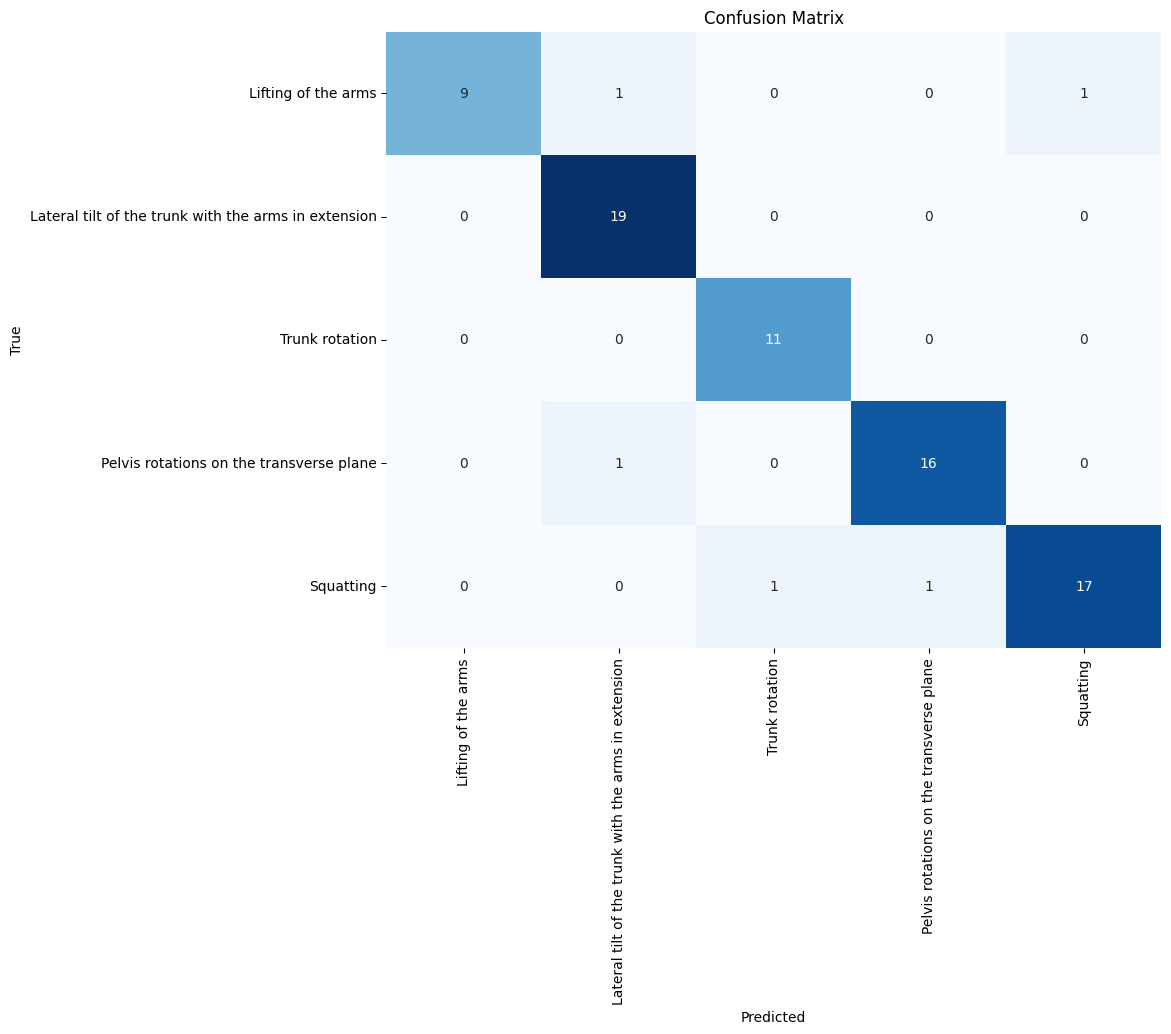

In [ ]:
fold_number = 2
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model createCombinedModel3
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 2 : MobileNetV3Small


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_3[0][0]']             
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 6s 533ms/step
Accuracy: 0.974025974025974
Precision: 0.9747474747474748
Recall: 0.974025974025974
F1 Score: 0.9740147298588858
AUC: 0.9985832529733205
Confusion Matrix:
 [[15  0  0  1  0]
 [ 0 15  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0 17  0]
 [ 1  0  0  0 16]]
Testing Time taken: 6.4485249519348145 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 2 : Res101-Dense201-ViT


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_7[0][0]']             
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_7[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 27s 4s/step
Accuracy: 0.961038961038961
Precision: 0.9619838494838494
Recall: 0.961038961038961
F1 Score: 0.9606829924718487
AUC: 0.9955463862720372
Confusion Matrix:
 [[14  1  1  0  0]
 [ 0 15  0  0  0]
 [ 0  0 12  0  0]
 [ 0  0  0 17  0]
 [ 1  0  0  0 16]]
Testing Time taken: 30.163079977035522 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


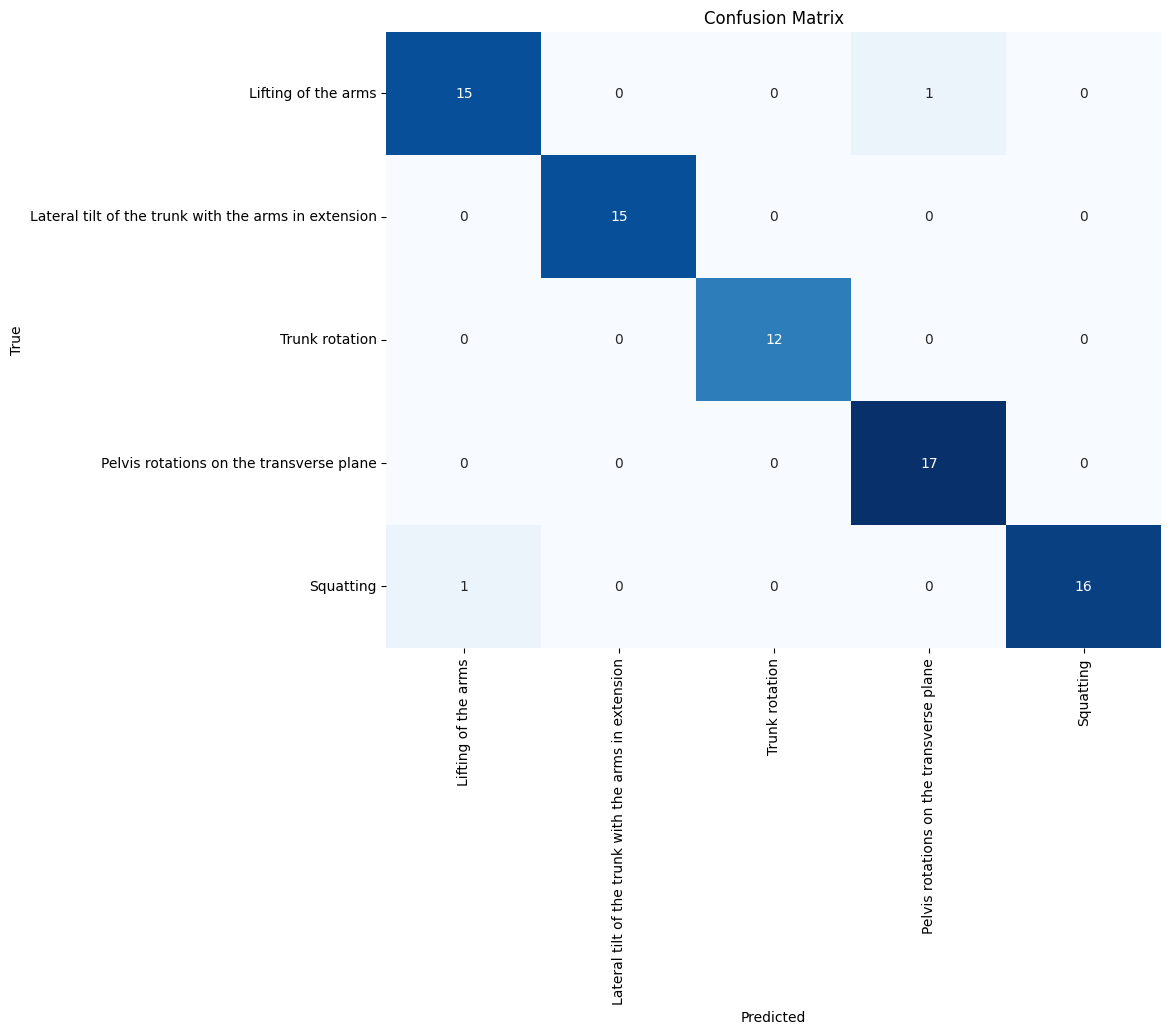

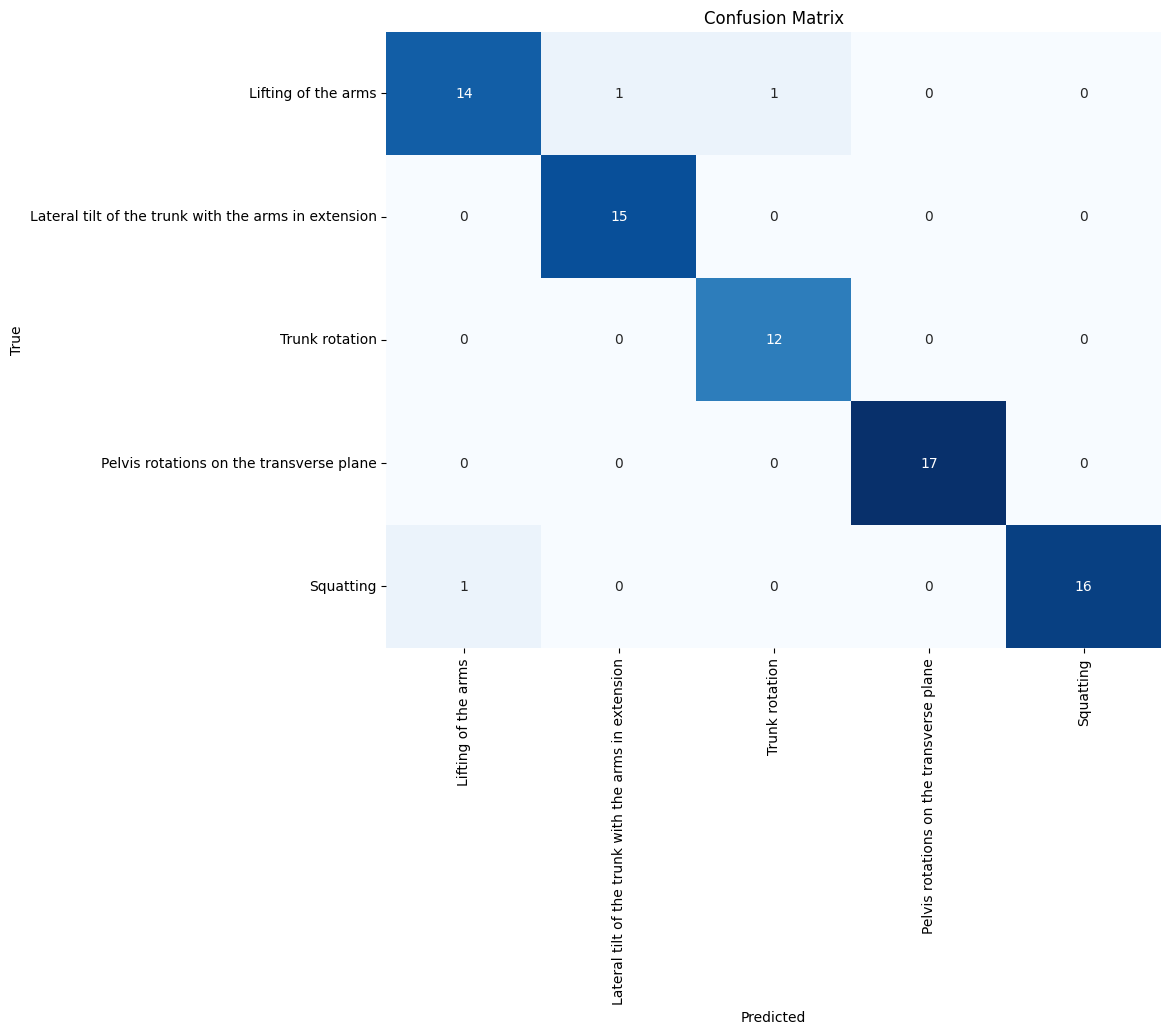

In [ ]:
fold_number = 3
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model createCombinedModel3
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

In [ ]:
fold_number = 4
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model createCombinedModel3
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

Processing Model 1 of 2 : MobileNetV3Small


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_10[0][0]']            
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_10[0][0]']            
 al)                                                                                              
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 4s 116ms/step
Accuracy: 0.9090909090909091
Precision: 0.9204803133374562
Recall: 0.9090909090909091
F1 Score: 0.907277797918192
AUC: 0.9831052036199095
Confusion Matrix:
 [[12  4  0  0  1]
 [ 0 12  1  0  0]
 [ 0  0 16  1  0]
 [ 0  0  0 13  0]
 [ 0  0  0  0 17]]
Testing Time taken: 4.0548436641693115 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 2 : Res101-Dense201-ViT


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_14[0][0]']            
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_14[0][0]']            
                                                          6                                       
                                                                                     

Processing Model 1 of 2 : MobileNetV3Small
353253686/353253686 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


4334752/4334752 [==============================] - 1s 0us/step
Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 MobilenetV3small (Function  (None, 7, 7, 576)            939120    ['input_3[0][0]']             
 al)                                                                                              
                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 7s 580ms/step
Accuracy: 0.961038961038961
Precision: 0.9637730690362271
Recall: 0.961038961038961
F1 Score: 0.9608946608946609
AUC: 0.9913976246236199
Confusion Matrix:
 [[20  0  0  1  0]
 [ 1 14  0  1  0]
 [ 0  0 15  0  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  8]]
Testing Time taken: 6.938098669052124 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.
Processing Model 2 of 2 : Res101-Dense201-ViT
171446536/171446536 [==============================] - 8s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_7[0][0]']             
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_7[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 27s 4s/step
Accuracy: 0.935064935064935
Precision: 0.939326926943026
Recall: 0.935064935064935
F1 Score: 0.9342122523940706
AUC: 0.9900459200073473
Confusion Matrix:
 [[20  0  0  1  0]
 [ 1 15  0  0  0]
 [ 0  2 12  1  0]
 [ 0  0  0 17  0]
 [ 0  0  0  0  8]]
Testing Time taken: 30.310122966766357 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


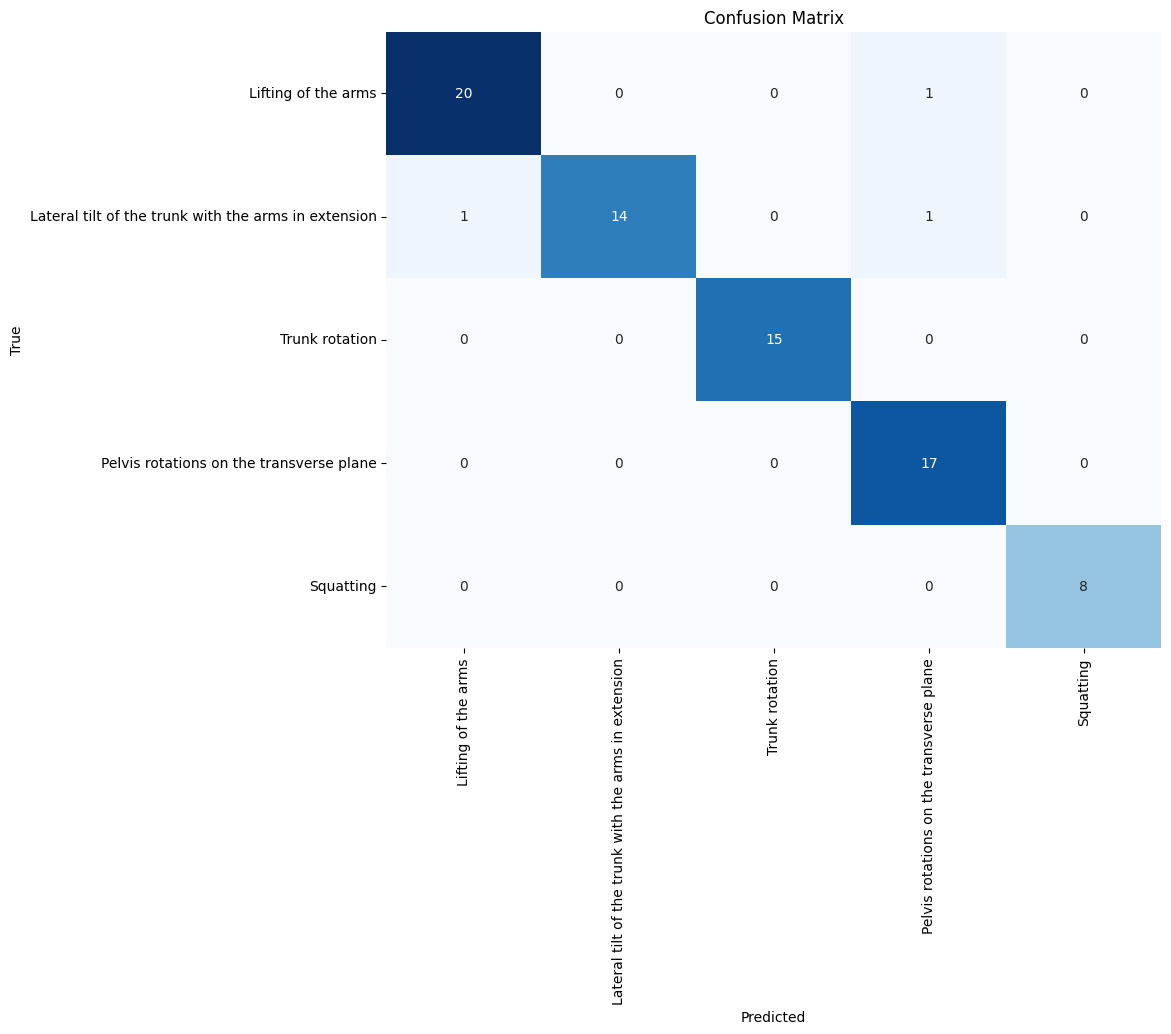

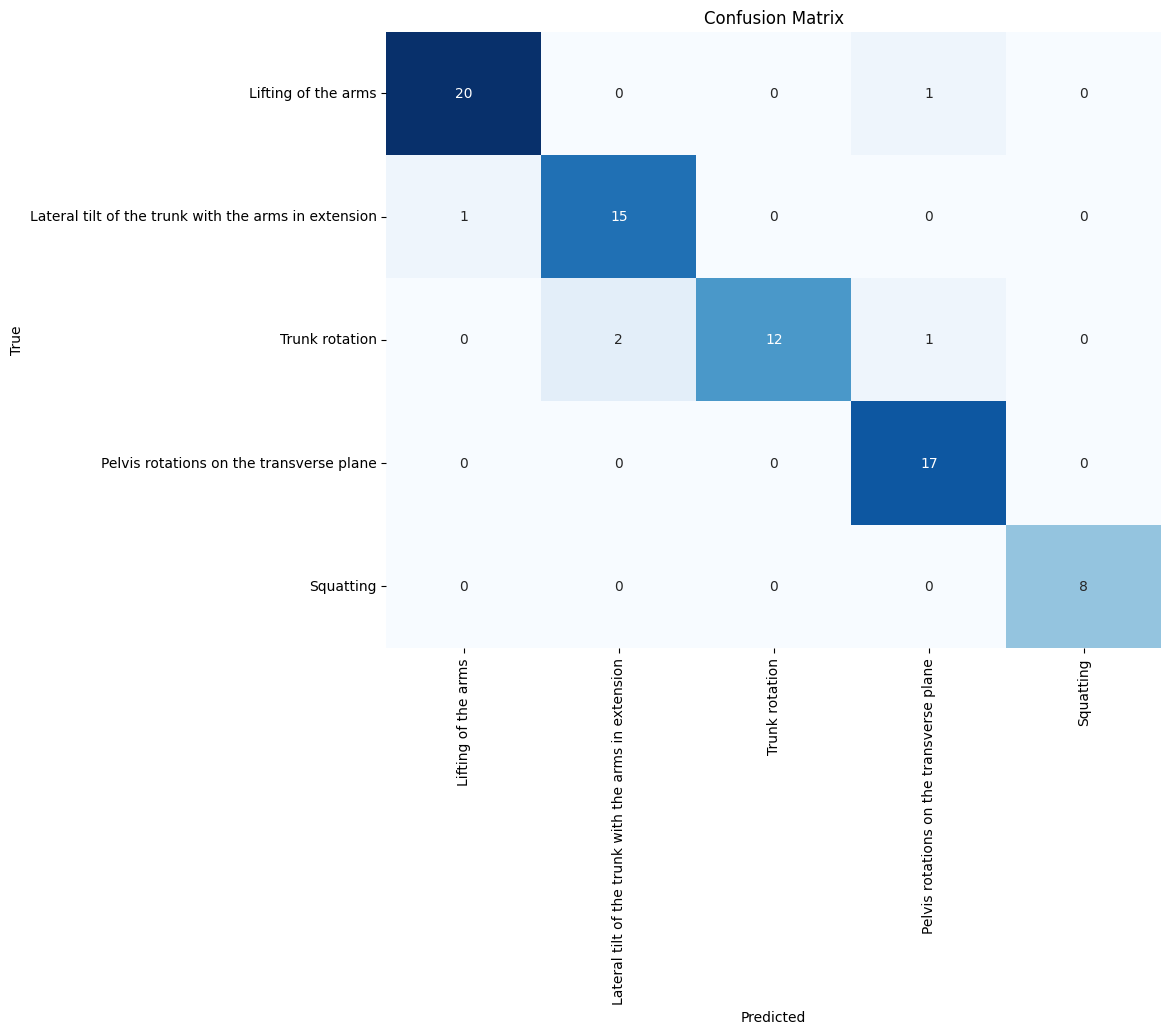

In [ ]:
fold_number = 5
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model createCombinedModel3
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

In [ ]:
model_names=['Res101-Dense201-ViT']

Processing Model 1 of 1 : Res101-Dense201-ViT


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_4[0][0]']             
                                                          4                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_4[0][0]']             
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 27s 4s/step
Accuracy: 0.9090909090909091
Precision: 0.9121830550401979
Recall: 0.9090909090909091
F1 Score: 0.9098025399324101
AUC: 0.9765582579185519
Confusion Matrix:
 [[14  0  0  0  3]
 [ 1 12  0  0  0]
 [ 0  0 16  1  0]
 [ 0  0  0 13  0]
 [ 2  0  0  0 15]]
Testing Time taken: 26.78391194343567 seconds
Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/missing/kimore/cv/results_cv.csv' successfully.


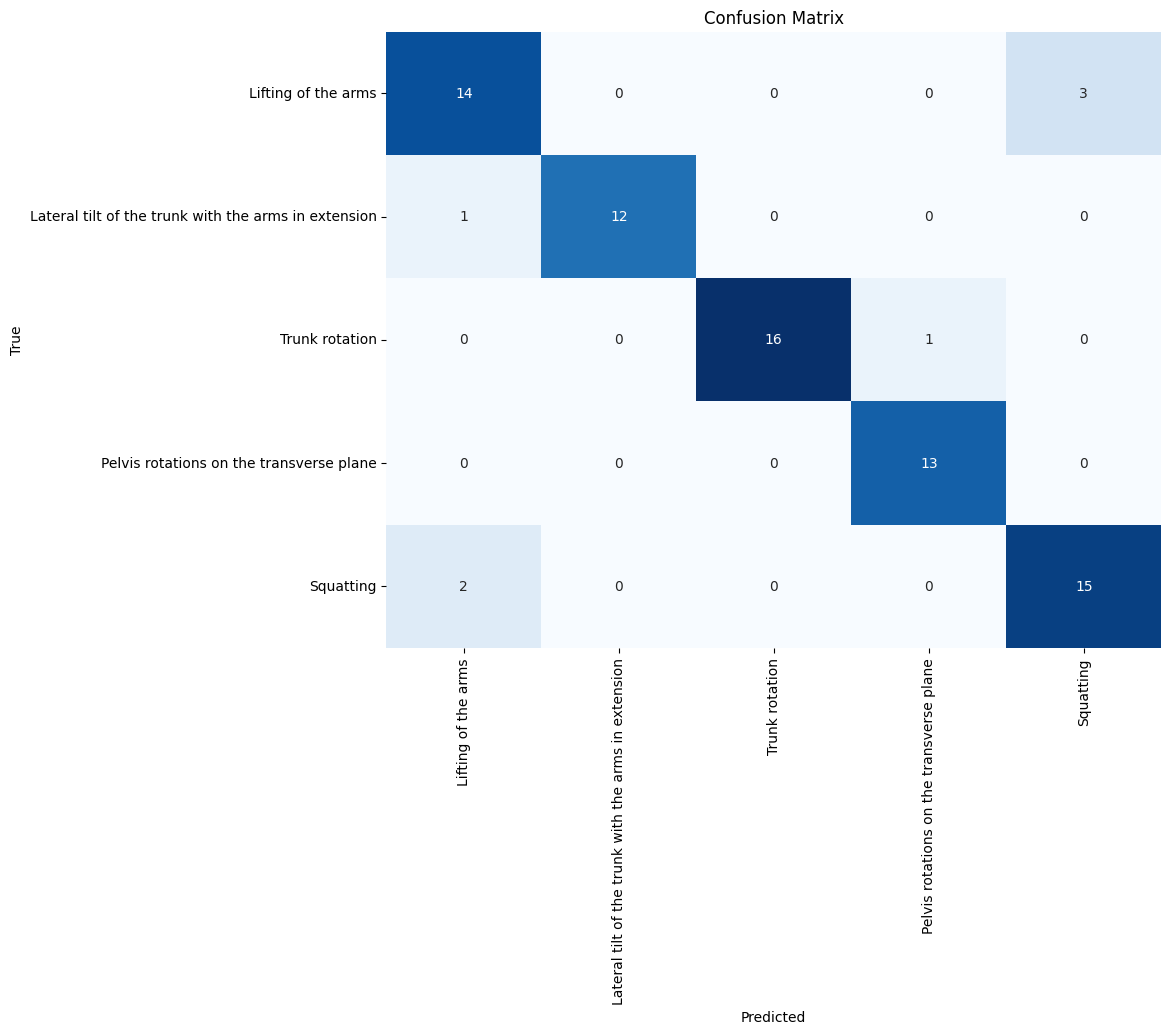

In [ ]:
fold_number = 4
i=1
# create top 6 models
for model_name in model_names:
  print("================================")
  print(f"Processing Model {i} of {len(model_names)} : {model_name}")
  print("================================")
  save_model_dir = save_folder+'arc2_'+model_name+'_'+str(fold_number)+'.h5'
  # Create Model createCombinedModel3
  model,callbacks=create_model_cv(img_size,num_classes,model_name,fold_number)
  X_train,y_train,X_test,y_test,X_val,y_val = load_split_data(fold_number,Oimages, Olabels_numeric,fold_path)
  # start_time = time.time()
  start_time = time.time()
  model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
  end_time = time.time()
  durationt = end_time - start_time
  start_time = time.time()
  cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
  end_time = time.time()
  duration = end_time - start_time
  print(f"Testing Time taken: {duration} seconds")
  plot_confusion_matrix_dic(cf, class_label_mapping,save_path=save_folder+'confusion_matrix_'+model_name+'_'+str(fold_number)+'.png')
  append_to_csv_epochs(csv_file_path, model_name,fold_number, accuracy,precision,recall,f1, duration, durationt,len(history.history['loss']))
  i+=1

## Transfer

#Transfomer on Images from Original Data

In [ ]:
# Example usage:
folder_path = '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images/'
Oimages, Olabels = load_images_and_labels(folder_path)
labels = encode_labels(Olabels)  # Add your label encoding function
resized_images = resize_images_cv2(Oimages)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(resized_images, labels, test_size=0.2, validation_size=0.1, random_state=42)


Loading Images:   0%|          | 0/2 [00:10<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
del Oimages,Olabels,resized_images

##ResVIT

In [ ]:
model_name="ResNetVisionTransformerOriginalData"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createVitWithResNet101(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vit-b32 (Functional)        (None, 768)                  8745523   ['input_10[0][0]']            
                                                          2                                       
                                                                                                  
 resnet101 (Functional)      (None, 7, 7, 2048)           4265817   ['input_10[0][0]']            
                                                          6                                       
                                                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1692.28253531456 seconds


13/13 [==============================] - 10s 320ms/step
Accuracy: 0.305
Precision: 0.29315877225665316
Recall: 0.305
F1 Score: 0.2875652671968199
AUC: 0.8453486842105263
Confusion Matrix:
 [[16  0  0  0  0  1  1  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  2  0  0  1  2  1  2  1  5  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  0  0  0  0  3  8  0  1  3  0  0  0  1  0]
 [ 0  0  3  5  0  0  1  1  0  0  1  2  0  0  1  0  0  0  4  2]
 [ 0  0  0  0 13  5  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  7  6  2  1  1  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  3  0  1  0  1 10  1  1  1  0  0  0  0  0  0  0  2  0  0]
 [ 0  1  1  0  1  4  4  4  1  0  2  1  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  0 15  2  0  0  0  0  0  0  0  0  0  1]
 [ 3  1  0  0  0  0  0  0  3 13  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  1  1  0  0  5  3  2  0  2  1  1  0  0  1]
 [ 0  0  1  1  0  0  1  4  0  0  2  5  1  1  0  0  1  0  2  1]
 [ 0  0  0  0  0  0  1  0  0  0  4  0  6  0  4  0  0  2

<ipython-input-12-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer/results.csv' successfully.


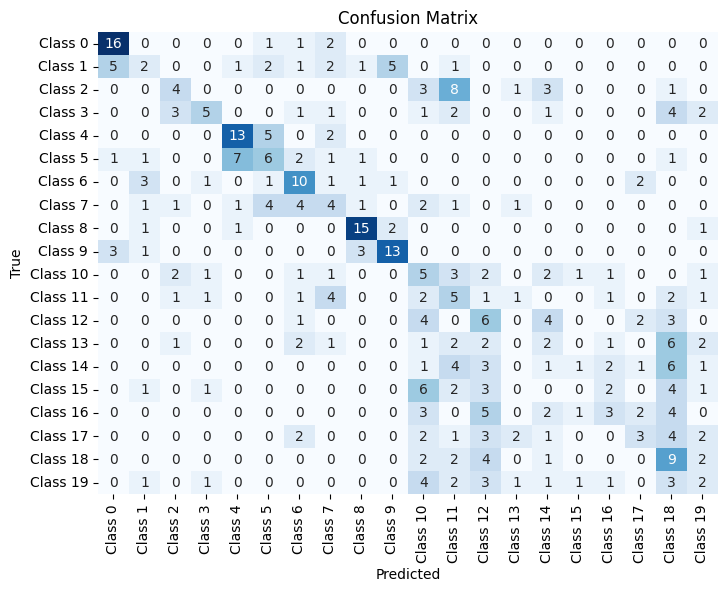

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)


## MobileVit

In [ ]:
model_name="HybridMobileVisionTransformerOriginalData"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createMobileVit(img_size,num_classes)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

NameError: ignored

13/13 [==============================] - 7s 189ms/step
Accuracy: 0.2875
Precision: 0.29804409079764044
Recall: 0.2875
F1 Score: 0.27990495076042504
AUC: 0.8354144736842104
Confusion Matrix:
 [[10  3  0  0  0  5  1  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  5  0  0  0  1  0  2  1  3  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  3  2  1  2  3  1  1  0  1  2]
 [ 0  0  0  6  0  0  1  1  0  0  2  2  1  0  0  0  0  0  3  4]
 [ 2  1  0  0  9  4  2  1  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  1  0  0  5  8  1  3  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  2  9  2  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 2  5  0  1  0  3  0  7  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 2  2  0  0  1  0  0  1  9  4  0  1  0  0  0  0  0  0  0  0]
 [ 3  3  0  0  0  1  0  2  1 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  1  4  0  0  0  2  0  0  4  4  2  0  1  0  0  0  0  1]
 [ 0  1  0  1  0  0  0  3  0  0  5  5  1  0  2  0  0  0  1  1]
 [ 0  0  0  3  0  0  1  0  0  0  2  0  8  0  1  0  0 

<ipython-input-12-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/Transformer/results.csv' successfully.


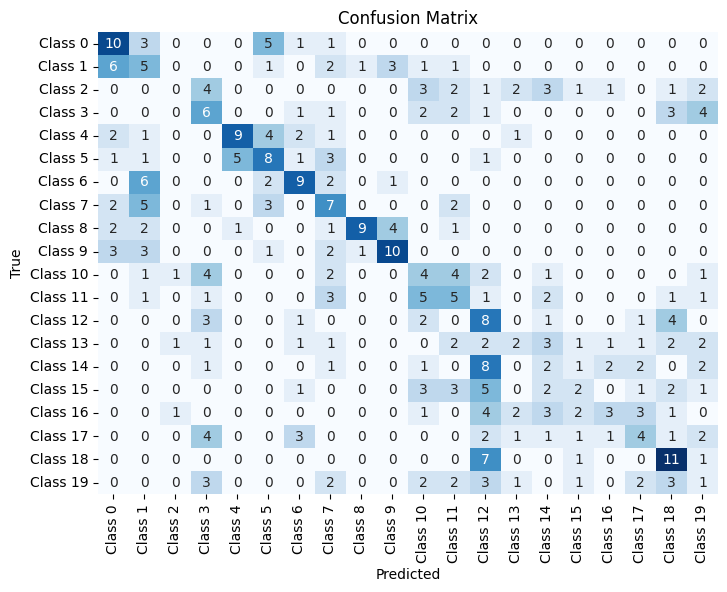

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration,durationt)

# Specs

In [ ]:
!pip install psutil gputil


  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=2e9a20440844545724767252a3bd3ee78857cabcee054e8e19a5fe8fb1f732ef
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil


In [ ]:
import GPUtil

# Get the list of available GPUs
gpus = GPUtil.getGPUs()

# Iterate over each GPU and print information
for i, gpu in enumerate(gpus):
    print(f"GPU {i + 1}:")
    print(f"  Name: {gpu.name}")
    print(f"  ID: {gpu.id}")
    print(f"  Driver: {gpu.driver}")
    print(f"  GPU Memory Total: {gpu.memoryTotal} MB")
    print(f"  GPU Memory Free: {gpu.memoryFree} MB")
    print(f"  GPU Memory Used: {gpu.memoryUsed} MB")
    print(f"  GPU Load: {gpu.load * 100}%")
    print(f"  GPU Temperature: {gpu.temperature} °C")
    print()

# If you just want the name of the first GPU, you can do:
if gpus:
    first_gpu_name = gpus[0].name
    print(f"Name of the first GPU: {first_gpu_name}")


GPU 1:
  Name: Tesla T4
  ID: 0
  Driver: 525.105.17
  GPU Memory Total: 15360.0 MB
  GPU Memory Free: 15101.0 MB
  GPU Memory Used: 0.0 MB
  GPU Load: 0.0%
  GPU Temperature: 56.0 °C

Name of the first GPU: Tesla T4


In [ ]:
import psutil
import platform
import cpuinfo
import GPUtil

# Get basic system information
system_info = platform.uname()
print("System Information:")
print(f"  System: {system_info.system}")
print(f"  Node Name: {system_info.node}")
print(f"  Release: {system_info.release}")
print(f"  Version: {system_info.version}")
print(f"  Machine: {system_info.machine}")
print(f"  Processor: {system_info.processor}")

# Get CPU information
cpu_info = cpuinfo.get_cpu_info()
print("\nCPU Information:")
print(f"  CPU Brand: {cpu_info['brand_raw']}")
print(f"  Architecture: {cpu_info['arch']}")
print(f"  Cores: {psutil.cpu_count(logical=False)} (Physical)")
print(f"  Threads: {psutil.cpu_count(logical=True)} (Logical)")
print(f"  Max Frequency: {psutil.cpu_freq().max:.2f} MHz")

# Get Memory information
memory_info = psutil.virtual_memory()
print("\nMemory Information:")
print(f"  Total Memory: {memory_info.total / (1024 ** 3):.2f} GB")
print(f"  Available Memory: {memory_info.available / (1024 ** 3):.2f} GB")
print(f"  Used Memory: {memory_info.used / (1024 ** 3):.2f} GB")

# Get GPU information
gpus = GPUtil.getGPUs()
if gpus:
    print("\nGPU Information:")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i + 1}:")
        print(f"    Name: {gpu.name}")
        print(f"    Driver: {gpu.driver}")
        print(f"    GPU Memory Total: {gpu.memoryTotal} MB")
        print(f"    GPU Memory Free: {gpu.memoryFree} MB")
        print(f"    GPU Memory Used: {gpu.memoryUsed} MB")
        print(f"    GPU Load: {gpu.load * 100}%")
        print(f"    GPU Temperature: {gpu.temperature} °C")
        print()

# Additional information can be gathered using other psutil functions
# For example, disk information, network information, etc.


System Information:
  System: Linux
  Node Name: 5a32522e0dc7
  Release: 5.15.120+
  Version: #1 SMP Wed Aug 30 11:19:59 UTC 2023
  Machine: x86_64
  Processor: x86_64

CPU Information:
  CPU Brand: Intel(R) Xeon(R) CPU @ 2.00GHz
  Architecture: X86_64
  Cores: 1 (Physical)
  Threads: 2 (Logical)
  Max Frequency: 0.00 MHz

Memory Information:
  Total Memory: 12.68 GB
  Available Memory: 11.82 GB
  Used Memory: 0.59 GB

GPU Information:
  GPU 1:
    Name: Tesla T4
    Driver: 525.105.17
    GPU Memory Total: 15360.0 MB
    GPU Memory Free: 15101.0 MB
    GPU Memory Used: 0.0 MB
    GPU Load: 0.0%
    GPU Temperature: 56.0 °C



#Other Transformers

In [ ]:
TwinSVT
CvT
SimpleViT
MaxViT
NesT
CrossFormer
T2TViT
CaiT
1CCT
DeepViT
MobileVit

In [ ]:
createTransferViT(img_size,num_classes,model_name)#MobileNetV3Small
createTransferViT(img_size,num_classes,model_name)#MobileNetV3Large
createTransferViT(img_size,num_classes,model_name)#ResNet152
createTransferViT(img_size,num_classes,model_name)#DenseNet201
createTransferViT(img_size,num_classes,model_name)#VGG16
createTransferViT(img_size,num_classes,model_name)#InceptionV3
createTransferViT(img_size,num_classes,model_name)#VGG19